In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 1576)
(3944610, 8)
validation
(464344, 1576)
(464344, 8)
test
(574820, 1576)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2304904 (8.79 MB)


Trainable params: 2304904 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:44 - loss: 2.4805 - STD: 0.1025 - MAE: 0.2203

  4/395 [..............................] - ETA: 8s - loss: 2.2060 - STD: 0.0531 - MAE: 0.2188  

  6/395 [..............................] - ETA: 10s - loss: 2.1651 - STD: 0.0582 - MAE: 0.2173

  8/395 [..............................] - ETA: 11s - loss: 2.1507 - STD: 0.0619 - MAE: 0.2166

 10/395 [..............................] - ETA: 11s - loss: 2.1390 - STD: 0.0609 - MAE: 0.2164

 12/395 [..............................] - ETA: 11s - loss: 2.1295 - STD: 0.0576 - MAE: 0.2165

 14/395 [>.............................] - ETA: 11s - loss: 2.1202 - STD: 0.0537 - MAE: 0.2166

 16/395 [>.............................] - ETA: 11s - loss: 2.1123 - STD: 0.0501 - MAE: 0.2167

 18/395 [>.............................] - ETA: 11s - loss: 2.1059 - STD: 0.0476 - MAE: 0.2167

 20/395 [>.............................] - ETA: 11s - loss: 2.1012 - STD: 0.0461 - MAE: 0.2167

 22/395 [>.............................] - ETA: 12s - loss: 2.0975 - STD: 0.0452 - MAE: 0.2167

 24/395 [>.............................] - ETA: 12s - loss: 2.0945 - STD: 0.0446 - MAE: 0.2167

 26/395 [>.............................] - ETA: 12s - loss: 2.0917 - STD: 0.0438 - MAE: 0.2167

 28/395 [=>............................] - ETA: 12s - loss: 2.0891 - STD: 0.0429 - MAE: 0.2167

 30/395 [=>............................] - ETA: 12s - loss: 2.0864 - STD: 0.0420 - MAE: 0.2167

 32/395 [=>............................] - ETA: 11s - loss: 2.0845 - STD: 0.0413 - MAE: 0.2168

 34/395 [=>............................] - ETA: 11s - loss: 2.0827 - STD: 0.0408 - MAE: 0.2168

 36/395 [=>............................] - ETA: 11s - loss: 2.0813 - STD: 0.0404 - MAE: 0.2168

 38/395 [=>............................] - ETA: 11s - loss: 2.0799 - STD: 0.0401 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 11s - loss: 2.0784 - STD: 0.0398 - MAE: 0.2167

 42/395 [==>...........................] - ETA: 11s - loss: 2.0772 - STD: 0.0395 - MAE: 0.2167

 44/395 [==>...........................] - ETA: 11s - loss: 2.0761 - STD: 0.0392 - MAE: 0.2167

 46/395 [==>...........................] - ETA: 11s - loss: 2.0751 - STD: 0.0389 - MAE: 0.2167

 48/395 [==>...........................] - ETA: 11s - loss: 2.0741 - STD: 0.0386 - MAE: 0.2167

 50/395 [==>...........................] - ETA: 11s - loss: 2.0732 - STD: 0.0383 - MAE: 0.2167

 52/395 [==>...........................] - ETA: 11s - loss: 2.0724 - STD: 0.0380 - MAE: 0.2167

 54/395 [===>..........................] - ETA: 11s - loss: 2.0717 - STD: 0.0377 - MAE: 0.2167

 56/395 [===>..........................] - ETA: 11s - loss: 2.0710 - STD: 0.0374 - MAE: 0.2167

 58/395 [===>..........................] - ETA: 11s - loss: 2.0702 - STD: 0.0372 - MAE: 0.2167

 60/395 [===>..........................] - ETA: 11s - loss: 2.0696 - STD: 0.0372 - MAE: 0.2167

 62/395 [===>..........................] - ETA: 11s - loss: 2.0691 - STD: 0.0371 - MAE: 0.2167

 64/395 [===>..........................] - ETA: 11s - loss: 2.0685 - STD: 0.0370 - MAE: 0.2167

 66/395 [====>.........................] - ETA: 11s - loss: 2.0680 - STD: 0.0368 - MAE: 0.2167

 68/395 [====>.........................] - ETA: 10s - loss: 2.0676 - STD: 0.0366 - MAE: 0.2167

 70/395 [====>.........................] - ETA: 10s - loss: 2.0672 - STD: 0.0364 - MAE: 0.2167

 72/395 [====>.........................] - ETA: 10s - loss: 2.0667 - STD: 0.0362 - MAE: 0.2167

 74/395 [====>.........................] - ETA: 10s - loss: 2.0663 - STD: 0.0361 - MAE: 0.2167

 76/395 [====>.........................] - ETA: 10s - loss: 2.0658 - STD: 0.0361 - MAE: 0.2167

 78/395 [====>.........................] - ETA: 10s - loss: 2.0655 - STD: 0.0360 - MAE: 0.2167

 80/395 [=====>........................] - ETA: 10s - loss: 2.0652 - STD: 0.0359 - MAE: 0.2167

 82/395 [=====>........................] - ETA: 10s - loss: 2.0648 - STD: 0.0358 - MAE: 0.2167

 84/395 [=====>........................] - ETA: 10s - loss: 2.0646 - STD: 0.0358 - MAE: 0.2167

 86/395 [=====>........................] - ETA: 10s - loss: 2.0643 - STD: 0.0357 - MAE: 0.2167

 88/395 [=====>........................] - ETA: 10s - loss: 2.0639 - STD: 0.0355 - MAE: 0.2167

 90/395 [=====>........................] - ETA: 10s - loss: 2.0637 - STD: 0.0354 - MAE: 0.2167

 92/395 [=====>........................] - ETA: 10s - loss: 2.0634 - STD: 0.0354 - MAE: 0.2167

 94/395 [======>.......................] - ETA: 10s - loss: 2.0631 - STD: 0.0354 - MAE: 0.2167

 96/395 [======>.......................] - ETA: 10s - loss: 2.0628 - STD: 0.0354 - MAE: 0.2167

 98/395 [======>.......................] - ETA: 10s - loss: 2.0626 - STD: 0.0353 - MAE: 0.2167

100/395 [======>.......................] - ETA: 10s - loss: 2.0623 - STD: 0.0352 - MAE: 0.2167

102/395 [======>.......................] - ETA: 9s - loss: 2.0621 - STD: 0.0351 - MAE: 0.2167 

104/395 [======>.......................] - ETA: 9s - loss: 2.0619 - STD: 0.0350 - MAE: 0.2167

106/395 [=======>......................] - ETA: 9s - loss: 2.0617 - STD: 0.0350 - MAE: 0.2167

108/395 [=======>......................] - ETA: 9s - loss: 2.0615 - STD: 0.0350 - MAE: 0.2167

110/395 [=======>......................] - ETA: 9s - loss: 2.0613 - STD: 0.0350 - MAE: 0.2167

112/395 [=======>......................] - ETA: 9s - loss: 2.0612 - STD: 0.0349 - MAE: 0.2167

114/395 [=======>......................] - ETA: 9s - loss: 2.0610 - STD: 0.0348 - MAE: 0.2167

116/395 [=======>......................] - ETA: 9s - loss: 2.0608 - STD: 0.0348 - MAE: 0.2167

118/395 [=======>......................] - ETA: 9s - loss: 2.0606 - STD: 0.0347 - MAE: 0.2167

120/395 [========>.....................] - ETA: 9s - loss: 2.0604 - STD: 0.0347 - MAE: 0.2167

122/395 [========>.....................] - ETA: 9s - loss: 2.0603 - STD: 0.0347 - MAE: 0.2167

124/395 [========>.....................] - ETA: 9s - loss: 2.0602 - STD: 0.0347 - MAE: 0.2167

126/395 [========>.....................] - ETA: 9s - loss: 2.0599 - STD: 0.0346 - MAE: 0.2167

128/395 [========>.....................] - ETA: 9s - loss: 2.0598 - STD: 0.0345 - MAE: 0.2167

130/395 [========>.....................] - ETA: 9s - loss: 2.0596 - STD: 0.0345 - MAE: 0.2167

132/395 [=========>....................] - ETA: 8s - loss: 2.0594 - STD: 0.0345 - MAE: 0.2167

134/395 [=========>....................] - ETA: 8s - loss: 2.0592 - STD: 0.0345 - MAE: 0.2167

136/395 [=========>....................] - ETA: 8s - loss: 2.0590 - STD: 0.0345 - MAE: 0.2167

138/395 [=========>....................] - ETA: 8s - loss: 2.0589 - STD: 0.0345 - MAE: 0.2167

140/395 [=========>....................] - ETA: 8s - loss: 2.0587 - STD: 0.0344 - MAE: 0.2167

142/395 [=========>....................] - ETA: 8s - loss: 2.0585 - STD: 0.0344 - MAE: 0.2167

144/395 [=========>....................] - ETA: 8s - loss: 2.0583 - STD: 0.0344 - MAE: 0.2167

146/395 [==========>...................] - ETA: 8s - loss: 2.0580 - STD: 0.0343 - MAE: 0.2167

148/395 [==========>...................] - ETA: 8s - loss: 2.0578 - STD: 0.0343 - MAE: 0.2167

150/395 [==========>...................] - ETA: 8s - loss: 2.0575 - STD: 0.0343 - MAE: 0.2167

152/395 [==========>...................] - ETA: 8s - loss: 2.0572 - STD: 0.0343 - MAE: 0.2167

154/395 [==========>...................] - ETA: 8s - loss: 2.0568 - STD: 0.0343 - MAE: 0.2166

156/395 [==========>...................] - ETA: 8s - loss: 2.0564 - STD: 0.0343 - MAE: 0.2166

158/395 [===========>..................] - ETA: 8s - loss: 2.0559 - STD: 0.0343 - MAE: 0.2166

160/395 [===========>..................] - ETA: 8s - loss: 2.0554 - STD: 0.0343 - MAE: 0.2166

162/395 [===========>..................] - ETA: 7s - loss: 2.0547 - STD: 0.0343 - MAE: 0.2166

164/395 [===========>..................] - ETA: 7s - loss: 2.0539 - STD: 0.0344 - MAE: 0.2166

166/395 [===========>..................] - ETA: 7s - loss: 2.0532 - STD: 0.0345 - MAE: 0.2165

168/395 [===========>..................] - ETA: 7s - loss: 2.0523 - STD: 0.0346 - MAE: 0.2165

170/395 [===========>..................] - ETA: 7s - loss: 2.0513 - STD: 0.0348 - MAE: 0.2164

172/395 [============>.................] - ETA: 7s - loss: 2.0504 - STD: 0.0350 - MAE: 0.2164

174/395 [============>.................] - ETA: 7s - loss: 2.0494 - STD: 0.0353 - MAE: 0.2164

176/395 [============>.................] - ETA: 7s - loss: 2.0484 - STD: 0.0355 - MAE: 0.2163

178/395 [============>.................] - ETA: 7s - loss: 2.0473 - STD: 0.0358 - MAE: 0.2162

179/395 [============>.................] - ETA: 8s - loss: 2.0471 - STD: 0.0359 - MAE: 0.2162

182/395 [============>.................] - ETA: 8s - loss: 2.0454 - STD: 0.0364 - MAE: 0.2161

185/395 [=============>................] - ETA: 7s - loss: 2.0438 - STD: 0.0369 - MAE: 0.2160

187/395 [=============>................] - ETA: 7s - loss: 2.0427 - STD: 0.0371 - MAE: 0.2160

189/395 [=============>................] - ETA: 7s - loss: 2.0417 - STD: 0.0374 - MAE: 0.2159

191/395 [=============>................] - ETA: 7s - loss: 2.0406 - STD: 0.0377 - MAE: 0.2159

193/395 [=============>................] - ETA: 7s - loss: 2.0395 - STD: 0.0380 - MAE: 0.2158

195/395 [=============>................] - ETA: 7s - loss: 2.0385 - STD: 0.0382 - MAE: 0.2158

197/395 [=============>................] - ETA: 7s - loss: 2.0375 - STD: 0.0385 - MAE: 0.2157

199/395 [==============>...............] - ETA: 7s - loss: 2.0364 - STD: 0.0387 - MAE: 0.2157

201/395 [==============>...............] - ETA: 7s - loss: 2.0354 - STD: 0.0390 - MAE: 0.2156

203/395 [==============>...............] - ETA: 7s - loss: 2.0344 - STD: 0.0392 - MAE: 0.2156

205/395 [==============>...............] - ETA: 7s - loss: 2.0334 - STD: 0.0395 - MAE: 0.2155

207/395 [==============>...............] - ETA: 6s - loss: 2.0324 - STD: 0.0397 - MAE: 0.2155

209/395 [==============>...............] - ETA: 6s - loss: 2.0314 - STD: 0.0400 - MAE: 0.2154

211/395 [===============>..............] - ETA: 6s - loss: 2.0305 - STD: 0.0402 - MAE: 0.2154

213/395 [===============>..............] - ETA: 6s - loss: 2.0295 - STD: 0.0405 - MAE: 0.2153

215/395 [===============>..............] - ETA: 6s - loss: 2.0286 - STD: 0.0407 - MAE: 0.2153

217/395 [===============>..............] - ETA: 6s - loss: 2.0278 - STD: 0.0409 - MAE: 0.2152

219/395 [===============>..............] - ETA: 6s - loss: 2.0268 - STD: 0.0411 - MAE: 0.2152

221/395 [===============>..............] - ETA: 6s - loss: 2.0259 - STD: 0.0413 - MAE: 0.2151

223/395 [===============>..............] - ETA: 6s - loss: 2.0250 - STD: 0.0415 - MAE: 0.2151

225/395 [================>.............] - ETA: 6s - loss: 2.0240 - STD: 0.0418 - MAE: 0.2150

227/395 [================>.............] - ETA: 6s - loss: 2.0231 - STD: 0.0420 - MAE: 0.2150

229/395 [================>.............] - ETA: 6s - loss: 2.0222 - STD: 0.0422 - MAE: 0.2149

231/395 [================>.............] - ETA: 6s - loss: 2.0213 - STD: 0.0424 - MAE: 0.2149

233/395 [================>.............] - ETA: 5s - loss: 2.0204 - STD: 0.0426 - MAE: 0.2148

235/395 [================>.............] - ETA: 5s - loss: 2.0195 - STD: 0.0428 - MAE: 0.2148

237/395 [=================>............] - ETA: 5s - loss: 2.0186 - STD: 0.0430 - MAE: 0.2147

239/395 [=================>............] - ETA: 5s - loss: 2.0176 - STD: 0.0432 - MAE: 0.2147

241/395 [=================>............] - ETA: 5s - loss: 2.0167 - STD: 0.0434 - MAE: 0.2146

243/395 [=================>............] - ETA: 5s - loss: 2.0157 - STD: 0.0436 - MAE: 0.2146

245/395 [=================>............] - ETA: 5s - loss: 2.0147 - STD: 0.0438 - MAE: 0.2145

247/395 [=================>............] - ETA: 5s - loss: 2.0138 - STD: 0.0440 - MAE: 0.2145

249/395 [=================>............] - ETA: 5s - loss: 2.0128 - STD: 0.0442 - MAE: 0.2144

251/395 [==================>...........] - ETA: 5s - loss: 2.0119 - STD: 0.0445 - MAE: 0.2144

253/395 [==================>...........] - ETA: 5s - loss: 2.0109 - STD: 0.0447 - MAE: 0.2143

255/395 [==================>...........] - ETA: 5s - loss: 2.0099 - STD: 0.0449 - MAE: 0.2143

257/395 [==================>...........] - ETA: 5s - loss: 2.0089 - STD: 0.0451 - MAE: 0.2142

259/395 [==================>...........] - ETA: 4s - loss: 2.0079 - STD: 0.0454 - MAE: 0.2141

261/395 [==================>...........] - ETA: 4s - loss: 2.0068 - STD: 0.0457 - MAE: 0.2141

263/395 [==================>...........] - ETA: 4s - loss: 2.0058 - STD: 0.0459 - MAE: 0.2140

265/395 [===================>..........] - ETA: 4s - loss: 2.0050 - STD: 0.0461 - MAE: 0.2139

267/395 [===================>..........] - ETA: 4s - loss: 2.0040 - STD: 0.0464 - MAE: 0.2139

269/395 [===================>..........] - ETA: 4s - loss: 2.0030 - STD: 0.0467 - MAE: 0.2138

271/395 [===================>..........] - ETA: 4s - loss: 2.0021 - STD: 0.0469 - MAE: 0.2137

273/395 [===================>..........] - ETA: 4s - loss: 2.0013 - STD: 0.0472 - MAE: 0.2137

275/395 [===================>..........] - ETA: 4s - loss: 2.0003 - STD: 0.0474 - MAE: 0.2136

277/395 [====================>.........] - ETA: 4s - loss: 1.9993 - STD: 0.0477 - MAE: 0.2136

279/395 [====================>.........] - ETA: 4s - loss: 1.9985 - STD: 0.0479 - MAE: 0.2135

281/395 [====================>.........] - ETA: 4s - loss: 1.9975 - STD: 0.0482 - MAE: 0.2134

283/395 [====================>.........] - ETA: 4s - loss: 1.9966 - STD: 0.0484 - MAE: 0.2134

285/395 [====================>.........] - ETA: 3s - loss: 1.9956 - STD: 0.0486 - MAE: 0.2133

287/395 [====================>.........] - ETA: 3s - loss: 1.9946 - STD: 0.0489 - MAE: 0.2133

289/395 [====================>.........] - ETA: 3s - loss: 1.9937 - STD: 0.0491 - MAE: 0.2132

291/395 [=====================>........] - ETA: 3s - loss: 1.9927 - STD: 0.0494 - MAE: 0.2131

293/395 [=====================>........] - ETA: 3s - loss: 1.9918 - STD: 0.0496 - MAE: 0.2131

295/395 [=====================>........] - ETA: 3s - loss: 1.9908 - STD: 0.0498 - MAE: 0.2130

297/395 [=====================>........] - ETA: 3s - loss: 1.9898 - STD: 0.0501 - MAE: 0.2130

299/395 [=====================>........] - ETA: 3s - loss: 1.9888 - STD: 0.0503 - MAE: 0.2129

301/395 [=====================>........] - ETA: 3s - loss: 1.9878 - STD: 0.0505 - MAE: 0.2128

303/395 [======================>.......] - ETA: 3s - loss: 1.9869 - STD: 0.0507 - MAE: 0.2128

305/395 [======================>.......] - ETA: 3s - loss: 1.9859 - STD: 0.0510 - MAE: 0.2127

307/395 [======================>.......] - ETA: 3s - loss: 1.9849 - STD: 0.0512 - MAE: 0.2126

309/395 [======================>.......] - ETA: 3s - loss: 1.9839 - STD: 0.0514 - MAE: 0.2126

311/395 [======================>.......] - ETA: 3s - loss: 1.9829 - STD: 0.0517 - MAE: 0.2125

313/395 [======================>.......] - ETA: 2s - loss: 1.9819 - STD: 0.0519 - MAE: 0.2125

315/395 [======================>.......] - ETA: 2s - loss: 1.9808 - STD: 0.0521 - MAE: 0.2124

317/395 [=======================>......] - ETA: 2s - loss: 1.9798 - STD: 0.0523 - MAE: 0.2123

319/395 [=======================>......] - ETA: 2s - loss: 1.9789 - STD: 0.0526 - MAE: 0.2123

321/395 [=======================>......] - ETA: 2s - loss: 1.9779 - STD: 0.0528 - MAE: 0.2122

323/395 [=======================>......] - ETA: 2s - loss: 1.9769 - STD: 0.0530 - MAE: 0.2121

325/395 [=======================>......] - ETA: 2s - loss: 1.9759 - STD: 0.0532 - MAE: 0.2121

327/395 [=======================>......] - ETA: 2s - loss: 1.9749 - STD: 0.0535 - MAE: 0.2120

329/395 [=======================>......] - ETA: 2s - loss: 1.9738 - STD: 0.0537 - MAE: 0.2120

331/395 [========================>.....] - ETA: 2s - loss: 1.9728 - STD: 0.0539 - MAE: 0.2119

333/395 [========================>.....] - ETA: 2s - loss: 1.9718 - STD: 0.0542 - MAE: 0.2118

335/395 [========================>.....] - ETA: 2s - loss: 1.9711 - STD: 0.0544 - MAE: 0.2118

337/395 [========================>.....] - ETA: 2s - loss: 1.9702 - STD: 0.0546 - MAE: 0.2117

339/395 [========================>.....] - ETA: 2s - loss: 1.9695 - STD: 0.0549 - MAE: 0.2116

341/395 [========================>.....] - ETA: 1s - loss: 1.9689 - STD: 0.0551 - MAE: 0.2116

343/395 [=========================>....] - ETA: 1s - loss: 1.9681 - STD: 0.0553 - MAE: 0.2115

345/395 [=========================>....] - ETA: 1s - loss: 1.9672 - STD: 0.0555 - MAE: 0.2115

347/395 [=========================>....] - ETA: 1s - loss: 1.9662 - STD: 0.0556 - MAE: 0.2114

349/395 [=========================>....] - ETA: 1s - loss: 1.9653 - STD: 0.0558 - MAE: 0.2114

351/395 [=========================>....] - ETA: 1s - loss: 1.9643 - STD: 0.0561 - MAE: 0.2113

353/395 [=========================>....] - ETA: 1s - loss: 1.9634 - STD: 0.0563 - MAE: 0.2112

355/395 [=========================>....] - ETA: 1s - loss: 1.9625 - STD: 0.0565 - MAE: 0.2112

357/395 [==========================>...] - ETA: 1s - loss: 1.9616 - STD: 0.0567 - MAE: 0.2111

359/395 [==========================>...] - ETA: 1s - loss: 1.9606 - STD: 0.0569 - MAE: 0.2111

361/395 [==========================>...] - ETA: 1s - loss: 1.9596 - STD: 0.0571 - MAE: 0.2110

363/395 [==========================>...] - ETA: 1s - loss: 1.9587 - STD: 0.0574 - MAE: 0.2109

365/395 [==========================>...] - ETA: 1s - loss: 1.9578 - STD: 0.0576 - MAE: 0.2109

367/395 [==========================>...] - ETA: 0s - loss: 1.9568 - STD: 0.0578 - MAE: 0.2108

369/395 [===========================>..] - ETA: 0s - loss: 1.9559 - STD: 0.0580 - MAE: 0.2108

371/395 [===========================>..] - ETA: 0s - loss: 1.9550 - STD: 0.0581 - MAE: 0.2107

373/395 [===========================>..] - ETA: 0s - loss: 1.9540 - STD: 0.0583 - MAE: 0.2106

375/395 [===========================>..] - ETA: 0s - loss: 1.9531 - STD: 0.0585 - MAE: 0.2106

377/395 [===========================>..] - ETA: 0s - loss: 1.9522 - STD: 0.0587 - MAE: 0.2105

379/395 [===========================>..] - ETA: 0s - loss: 1.9512 - STD: 0.0589 - MAE: 0.2105

381/395 [===========================>..] - ETA: 0s - loss: 1.9503 - STD: 0.0591 - MAE: 0.2104

383/395 [============================>.] - ETA: 0s - loss: 1.9494 - STD: 0.0594 - MAE: 0.2103

385/395 [============================>.] - ETA: 0s - loss: 1.9485 - STD: 0.0596 - MAE: 0.2103

387/395 [============================>.] - ETA: 0s - loss: 1.9476 - STD: 0.0598 - MAE: 0.2102

389/395 [============================>.] - ETA: 0s - loss: 1.9467 - STD: 0.0600 - MAE: 0.2102

391/395 [============================>.] - ETA: 0s - loss: 1.9457 - STD: 0.0601 - MAE: 0.2101

393/395 [============================>.] - ETA: 0s - loss: 1.9448 - STD: 0.0603 - MAE: 0.2100

395/395 [==============================] - ETA: 0s - loss: 1.9439 - STD: 0.0605 - MAE: 0.2100

395/395 [==============================] - 18s 41ms/step - loss: 1.9439 - STD: 0.0605 - MAE: 0.2100 - val_loss: 1.7748 - val_STD: 0.0957 - val_MAE: 0.1985


Epoch 2/10000


  1/395 [..............................] - ETA: 28s - loss: 1.7737 - STD: 0.0994 - MAE: 0.1984

  3/395 [..............................] - ETA: 14s - loss: 1.7674 - STD: 0.0992 - MAE: 0.1983

  5/395 [..............................] - ETA: 13s - loss: 1.7716 - STD: 0.0999 - MAE: 0.1982

  7/395 [..............................] - ETA: 13s - loss: 1.7707 - STD: 0.1006 - MAE: 0.1981

  9/395 [..............................] - ETA: 13s - loss: 1.7704 - STD: 0.1002 - MAE: 0.1981

 11/395 [..............................] - ETA: 13s - loss: 1.7675 - STD: 0.0999 - MAE: 0.1981

 13/395 [..............................] - ETA: 13s - loss: 1.7682 - STD: 0.0997 - MAE: 0.1982

 15/395 [>.............................] - ETA: 13s - loss: 1.7659 - STD: 0.0998 - MAE: 0.1981

 17/395 [>.............................] - ETA: 12s - loss: 1.7656 - STD: 0.0998 - MAE: 0.1980

 19/395 [>.............................] - ETA: 12s - loss: 1.7640 - STD: 0.0998 - MAE: 0.1980

 21/395 [>.............................] - ETA: 12s - loss: 1.7634 - STD: 0.0999 - MAE: 0.1979

 23/395 [>.............................] - ETA: 12s - loss: 1.7621 - STD: 0.1000 - MAE: 0.1978

 25/395 [>.............................] - ETA: 12s - loss: 1.7617 - STD: 0.1001 - MAE: 0.1978

 27/395 [=>............................] - ETA: 12s - loss: 1.7620 - STD: 0.1004 - MAE: 0.1978

 29/395 [=>............................] - ETA: 12s - loss: 1.7656 - STD: 0.1008 - MAE: 0.1978

 31/395 [=>............................] - ETA: 12s - loss: 1.7645 - STD: 0.1006 - MAE: 0.1978

 33/395 [=>............................] - ETA: 12s - loss: 1.7654 - STD: 0.1007 - MAE: 0.1978

 35/395 [=>............................] - ETA: 12s - loss: 1.7639 - STD: 0.1006 - MAE: 0.1978

 37/395 [=>............................] - ETA: 12s - loss: 1.7628 - STD: 0.1006 - MAE: 0.1977

 39/395 [=>............................] - ETA: 12s - loss: 1.7623 - STD: 0.1008 - MAE: 0.1977

 41/395 [==>...........................] - ETA: 12s - loss: 1.7616 - STD: 0.1010 - MAE: 0.1976

 43/395 [==>...........................] - ETA: 12s - loss: 1.7607 - STD: 0.1010 - MAE: 0.1976

 45/395 [==>...........................] - ETA: 11s - loss: 1.7599 - STD: 0.1011 - MAE: 0.1975

 47/395 [==>...........................] - ETA: 11s - loss: 1.7591 - STD: 0.1012 - MAE: 0.1975

 49/395 [==>...........................] - ETA: 11s - loss: 1.7582 - STD: 0.1012 - MAE: 0.1975

 51/395 [==>...........................] - ETA: 11s - loss: 1.7576 - STD: 0.1013 - MAE: 0.1974

 53/395 [===>..........................] - ETA: 11s - loss: 1.7568 - STD: 0.1013 - MAE: 0.1974

 55/395 [===>..........................] - ETA: 11s - loss: 1.7561 - STD: 0.1015 - MAE: 0.1973

 57/395 [===>..........................] - ETA: 11s - loss: 1.7553 - STD: 0.1015 - MAE: 0.1973

 59/395 [===>..........................] - ETA: 11s - loss: 1.7547 - STD: 0.1015 - MAE: 0.1973

 61/395 [===>..........................] - ETA: 11s - loss: 1.7537 - STD: 0.1016 - MAE: 0.1972

 63/395 [===>..........................] - ETA: 11s - loss: 1.7531 - STD: 0.1018 - MAE: 0.1972

 65/395 [===>..........................] - ETA: 11s - loss: 1.7524 - STD: 0.1019 - MAE: 0.1971

 67/395 [====>.........................] - ETA: 11s - loss: 1.7514 - STD: 0.1020 - MAE: 0.1971

 69/395 [====>.........................] - ETA: 11s - loss: 1.7506 - STD: 0.1020 - MAE: 0.1970

 71/395 [====>.........................] - ETA: 11s - loss: 1.7500 - STD: 0.1022 - MAE: 0.1970

 73/395 [====>.........................] - ETA: 10s - loss: 1.7492 - STD: 0.1023 - MAE: 0.1969

 75/395 [====>.........................] - ETA: 10s - loss: 1.7485 - STD: 0.1024 - MAE: 0.1968

 77/395 [====>.........................] - ETA: 10s - loss: 1.7482 - STD: 0.1025 - MAE: 0.1968

 79/395 [=====>........................] - ETA: 10s - loss: 1.7491 - STD: 0.1027 - MAE: 0.1968

 81/395 [=====>........................] - ETA: 10s - loss: 1.7486 - STD: 0.1027 - MAE: 0.1968

 83/395 [=====>........................] - ETA: 10s - loss: 1.7481 - STD: 0.1028 - MAE: 0.1968

 85/395 [=====>........................] - ETA: 10s - loss: 1.7476 - STD: 0.1029 - MAE: 0.1967

 87/395 [=====>........................] - ETA: 10s - loss: 1.7473 - STD: 0.1030 - MAE: 0.1967

 89/395 [=====>........................] - ETA: 10s - loss: 1.7466 - STD: 0.1031 - MAE: 0.1966

 91/395 [=====>........................] - ETA: 10s - loss: 1.7458 - STD: 0.1031 - MAE: 0.1966

 93/395 [======>.......................] - ETA: 10s - loss: 1.7451 - STD: 0.1032 - MAE: 0.1965

 95/395 [======>.......................] - ETA: 10s - loss: 1.7443 - STD: 0.1033 - MAE: 0.1965

 97/395 [======>.......................] - ETA: 10s - loss: 1.7436 - STD: 0.1034 - MAE: 0.1964

 99/395 [======>.......................] - ETA: 10s - loss: 1.7430 - STD: 0.1035 - MAE: 0.1964

101/395 [======>.......................] - ETA: 10s - loss: 1.7422 - STD: 0.1036 - MAE: 0.1963

103/395 [======>.......................] - ETA: 9s - loss: 1.7415 - STD: 0.1037 - MAE: 0.1963 

105/395 [======>.......................] - ETA: 9s - loss: 1.7406 - STD: 0.1038 - MAE: 0.1963

107/395 [=======>......................] - ETA: 9s - loss: 1.7398 - STD: 0.1038 - MAE: 0.1962

109/395 [=======>......................] - ETA: 9s - loss: 1.7392 - STD: 0.1040 - MAE: 0.1962

111/395 [=======>......................] - ETA: 9s - loss: 1.7383 - STD: 0.1041 - MAE: 0.1961

113/395 [=======>......................] - ETA: 9s - loss: 1.7397 - STD: 0.1042 - MAE: 0.1961

115/395 [=======>......................] - ETA: 9s - loss: 1.7418 - STD: 0.1045 - MAE: 0.1961

117/395 [=======>......................] - ETA: 9s - loss: 1.7431 - STD: 0.1048 - MAE: 0.1961

119/395 [========>.....................] - ETA: 9s - loss: 1.7436 - STD: 0.1048 - MAE: 0.1961

121/395 [========>.....................] - ETA: 9s - loss: 1.7437 - STD: 0.1049 - MAE: 0.1961

123/395 [========>.....................] - ETA: 9s - loss: 1.7437 - STD: 0.1048 - MAE: 0.1961

125/395 [========>.....................] - ETA: 9s - loss: 1.7437 - STD: 0.1048 - MAE: 0.1961

127/395 [========>.....................] - ETA: 9s - loss: 1.7436 - STD: 0.1049 - MAE: 0.1961

129/395 [========>.....................] - ETA: 9s - loss: 1.7433 - STD: 0.1050 - MAE: 0.1961

131/395 [========>.....................] - ETA: 8s - loss: 1.7430 - STD: 0.1050 - MAE: 0.1961

133/395 [=========>....................] - ETA: 8s - loss: 1.7427 - STD: 0.1050 - MAE: 0.1960

135/395 [=========>....................] - ETA: 8s - loss: 1.7421 - STD: 0.1051 - MAE: 0.1960

137/395 [=========>....................] - ETA: 8s - loss: 1.7417 - STD: 0.1051 - MAE: 0.1960

139/395 [=========>....................] - ETA: 8s - loss: 1.7412 - STD: 0.1052 - MAE: 0.1960

141/395 [=========>....................] - ETA: 8s - loss: 1.7406 - STD: 0.1052 - MAE: 0.1959

143/395 [=========>....................] - ETA: 8s - loss: 1.7401 - STD: 0.1053 - MAE: 0.1959

145/395 [==========>...................] - ETA: 8s - loss: 1.7396 - STD: 0.1054 - MAE: 0.1959

147/395 [==========>...................] - ETA: 8s - loss: 1.7391 - STD: 0.1054 - MAE: 0.1958

149/395 [==========>...................] - ETA: 8s - loss: 1.7385 - STD: 0.1055 - MAE: 0.1958

151/395 [==========>...................] - ETA: 8s - loss: 1.7380 - STD: 0.1055 - MAE: 0.1958

153/395 [==========>...................] - ETA: 8s - loss: 1.7374 - STD: 0.1056 - MAE: 0.1957

155/395 [==========>...................] - ETA: 8s - loss: 1.7367 - STD: 0.1056 - MAE: 0.1957

157/395 [==========>...................] - ETA: 8s - loss: 1.7361 - STD: 0.1057 - MAE: 0.1957

159/395 [===========>..................] - ETA: 8s - loss: 1.7356 - STD: 0.1058 - MAE: 0.1956

161/395 [===========>..................] - ETA: 7s - loss: 1.7350 - STD: 0.1058 - MAE: 0.1956

163/395 [===========>..................] - ETA: 7s - loss: 1.7343 - STD: 0.1059 - MAE: 0.1956

165/395 [===========>..................] - ETA: 7s - loss: 1.7336 - STD: 0.1060 - MAE: 0.1955

167/395 [===========>..................] - ETA: 7s - loss: 1.7331 - STD: 0.1061 - MAE: 0.1955

169/395 [===========>..................] - ETA: 7s - loss: 1.7324 - STD: 0.1061 - MAE: 0.1954

171/395 [===========>..................] - ETA: 7s - loss: 1.7319 - STD: 0.1062 - MAE: 0.1954

173/395 [============>.................] - ETA: 7s - loss: 1.7315 - STD: 0.1063 - MAE: 0.1954

175/395 [============>.................] - ETA: 7s - loss: 1.7312 - STD: 0.1064 - MAE: 0.1953

177/395 [============>.................] - ETA: 7s - loss: 1.7305 - STD: 0.1065 - MAE: 0.1953

179/395 [============>.................] - ETA: 7s - loss: 1.7301 - STD: 0.1066 - MAE: 0.1953

181/395 [============>.................] - ETA: 7s - loss: 1.7296 - STD: 0.1066 - MAE: 0.1952

183/395 [============>.................] - ETA: 7s - loss: 1.7290 - STD: 0.1067 - MAE: 0.1952

185/395 [=============>................] - ETA: 7s - loss: 1.7284 - STD: 0.1068 - MAE: 0.1952

187/395 [=============>................] - ETA: 7s - loss: 1.7279 - STD: 0.1068 - MAE: 0.1951

189/395 [=============>................] - ETA: 7s - loss: 1.7272 - STD: 0.1069 - MAE: 0.1951

191/395 [=============>................] - ETA: 6s - loss: 1.7266 - STD: 0.1070 - MAE: 0.1950

193/395 [=============>................] - ETA: 6s - loss: 1.7260 - STD: 0.1071 - MAE: 0.1950

195/395 [=============>................] - ETA: 6s - loss: 1.7254 - STD: 0.1072 - MAE: 0.1950

197/395 [=============>................] - ETA: 6s - loss: 1.7248 - STD: 0.1073 - MAE: 0.1949

199/395 [==============>...............] - ETA: 6s - loss: 1.7243 - STD: 0.1074 - MAE: 0.1949

201/395 [==============>...............] - ETA: 6s - loss: 1.7240 - STD: 0.1075 - MAE: 0.1948

203/395 [==============>...............] - ETA: 6s - loss: 1.7237 - STD: 0.1076 - MAE: 0.1948

205/395 [==============>...............] - ETA: 6s - loss: 1.7232 - STD: 0.1076 - MAE: 0.1948

207/395 [==============>...............] - ETA: 6s - loss: 1.7230 - STD: 0.1077 - MAE: 0.1948

209/395 [==============>...............] - ETA: 6s - loss: 1.7226 - STD: 0.1078 - MAE: 0.1947

211/395 [===============>..............] - ETA: 6s - loss: 1.7224 - STD: 0.1079 - MAE: 0.1947

213/395 [===============>..............] - ETA: 6s - loss: 1.7221 - STD: 0.1079 - MAE: 0.1947

215/395 [===============>..............] - ETA: 6s - loss: 1.7220 - STD: 0.1080 - MAE: 0.1946

217/395 [===============>..............] - ETA: 6s - loss: 1.7217 - STD: 0.1081 - MAE: 0.1946

219/395 [===============>..............] - ETA: 6s - loss: 1.7216 - STD: 0.1082 - MAE: 0.1946

221/395 [===============>..............] - ETA: 5s - loss: 1.7217 - STD: 0.1083 - MAE: 0.1946

223/395 [===============>..............] - ETA: 5s - loss: 1.7217 - STD: 0.1084 - MAE: 0.1946

225/395 [================>.............] - ETA: 5s - loss: 1.7214 - STD: 0.1084 - MAE: 0.1945

227/395 [================>.............] - ETA: 5s - loss: 1.7211 - STD: 0.1084 - MAE: 0.1945

229/395 [================>.............] - ETA: 5s - loss: 1.7208 - STD: 0.1084 - MAE: 0.1945

231/395 [================>.............] - ETA: 5s - loss: 1.7206 - STD: 0.1085 - MAE: 0.1945

233/395 [================>.............] - ETA: 5s - loss: 1.7203 - STD: 0.1086 - MAE: 0.1945

235/395 [================>.............] - ETA: 5s - loss: 1.7199 - STD: 0.1086 - MAE: 0.1944

237/395 [=================>............] - ETA: 5s - loss: 1.7196 - STD: 0.1087 - MAE: 0.1944

239/395 [=================>............] - ETA: 5s - loss: 1.7192 - STD: 0.1087 - MAE: 0.1944

241/395 [=================>............] - ETA: 5s - loss: 1.7188 - STD: 0.1088 - MAE: 0.1944

243/395 [=================>............] - ETA: 5s - loss: 1.7184 - STD: 0.1089 - MAE: 0.1943

245/395 [=================>............] - ETA: 5s - loss: 1.7180 - STD: 0.1089 - MAE: 0.1943

247/395 [=================>............] - ETA: 5s - loss: 1.7177 - STD: 0.1090 - MAE: 0.1943

249/395 [=================>............] - ETA: 4s - loss: 1.7173 - STD: 0.1090 - MAE: 0.1943

251/395 [==================>...........] - ETA: 4s - loss: 1.7168 - STD: 0.1090 - MAE: 0.1942

253/395 [==================>...........] - ETA: 4s - loss: 1.7164 - STD: 0.1091 - MAE: 0.1942

255/395 [==================>...........] - ETA: 4s - loss: 1.7161 - STD: 0.1092 - MAE: 0.1942

257/395 [==================>...........] - ETA: 4s - loss: 1.7156 - STD: 0.1092 - MAE: 0.1941

259/395 [==================>...........] - ETA: 4s - loss: 1.7153 - STD: 0.1093 - MAE: 0.1941

261/395 [==================>...........] - ETA: 4s - loss: 1.7149 - STD: 0.1093 - MAE: 0.1941

263/395 [==================>...........] - ETA: 4s - loss: 1.7145 - STD: 0.1094 - MAE: 0.1941

265/395 [===================>..........] - ETA: 4s - loss: 1.7141 - STD: 0.1095 - MAE: 0.1940

267/395 [===================>..........] - ETA: 4s - loss: 1.7136 - STD: 0.1095 - MAE: 0.1940

269/395 [===================>..........] - ETA: 4s - loss: 1.7132 - STD: 0.1096 - MAE: 0.1940

271/395 [===================>..........] - ETA: 4s - loss: 1.7128 - STD: 0.1096 - MAE: 0.1940

273/395 [===================>..........] - ETA: 4s - loss: 1.7124 - STD: 0.1097 - MAE: 0.1939

275/395 [===================>..........] - ETA: 4s - loss: 1.7119 - STD: 0.1098 - MAE: 0.1939

277/395 [====================>.........] - ETA: 4s - loss: 1.7115 - STD: 0.1098 - MAE: 0.1939

279/395 [====================>.........] - ETA: 3s - loss: 1.7110 - STD: 0.1099 - MAE: 0.1938

281/395 [====================>.........] - ETA: 3s - loss: 1.7106 - STD: 0.1100 - MAE: 0.1938

283/395 [====================>.........] - ETA: 3s - loss: 1.7102 - STD: 0.1100 - MAE: 0.1938

285/395 [====================>.........] - ETA: 3s - loss: 1.7098 - STD: 0.1101 - MAE: 0.1937

287/395 [====================>.........] - ETA: 3s - loss: 1.7095 - STD: 0.1101 - MAE: 0.1937

289/395 [====================>.........] - ETA: 3s - loss: 1.7090 - STD: 0.1102 - MAE: 0.1937

291/395 [=====================>........] - ETA: 3s - loss: 1.7087 - STD: 0.1102 - MAE: 0.1937

293/395 [=====================>........] - ETA: 3s - loss: 1.7083 - STD: 0.1103 - MAE: 0.1936

295/395 [=====================>........] - ETA: 3s - loss: 1.7079 - STD: 0.1104 - MAE: 0.1936

297/395 [=====================>........] - ETA: 3s - loss: 1.7076 - STD: 0.1104 - MAE: 0.1936

299/395 [=====================>........] - ETA: 3s - loss: 1.7073 - STD: 0.1105 - MAE: 0.1936

301/395 [=====================>........] - ETA: 3s - loss: 1.7069 - STD: 0.1105 - MAE: 0.1935

303/395 [======================>.......] - ETA: 3s - loss: 1.7066 - STD: 0.1106 - MAE: 0.1935

306/395 [======================>.......] - ETA: 3s - loss: 1.7061 - STD: 0.1107 - MAE: 0.1935

308/395 [======================>.......] - ETA: 2s - loss: 1.7057 - STD: 0.1107 - MAE: 0.1934

310/395 [======================>.......] - ETA: 2s - loss: 1.7053 - STD: 0.1108 - MAE: 0.1934

312/395 [======================>.......] - ETA: 2s - loss: 1.7049 - STD: 0.1109 - MAE: 0.1934

314/395 [======================>.......] - ETA: 2s - loss: 1.7046 - STD: 0.1109 - MAE: 0.1933

316/395 [=======================>......] - ETA: 2s - loss: 1.7042 - STD: 0.1110 - MAE: 0.1933

318/395 [=======================>......] - ETA: 2s - loss: 1.7038 - STD: 0.1110 - MAE: 0.1933

320/395 [=======================>......] - ETA: 2s - loss: 1.7035 - STD: 0.1111 - MAE: 0.1933

322/395 [=======================>......] - ETA: 2s - loss: 1.7031 - STD: 0.1112 - MAE: 0.1932

324/395 [=======================>......] - ETA: 2s - loss: 1.7027 - STD: 0.1112 - MAE: 0.1932

326/395 [=======================>......] - ETA: 2s - loss: 1.7023 - STD: 0.1113 - MAE: 0.1932

328/395 [=======================>......] - ETA: 2s - loss: 1.7020 - STD: 0.1113 - MAE: 0.1932

330/395 [========================>.....] - ETA: 2s - loss: 1.7016 - STD: 0.1114 - MAE: 0.1931

332/395 [========================>.....] - ETA: 2s - loss: 1.7013 - STD: 0.1115 - MAE: 0.1931

334/395 [========================>.....] - ETA: 2s - loss: 1.7011 - STD: 0.1115 - MAE: 0.1931

336/395 [========================>.....] - ETA: 2s - loss: 1.7008 - STD: 0.1116 - MAE: 0.1930

338/395 [========================>.....] - ETA: 1s - loss: 1.7005 - STD: 0.1116 - MAE: 0.1930

340/395 [========================>.....] - ETA: 1s - loss: 1.7002 - STD: 0.1117 - MAE: 0.1930

342/395 [========================>.....] - ETA: 1s - loss: 1.6999 - STD: 0.1118 - MAE: 0.1930

344/395 [=========================>....] - ETA: 1s - loss: 1.6995 - STD: 0.1118 - MAE: 0.1929

346/395 [=========================>....] - ETA: 1s - loss: 1.6991 - STD: 0.1119 - MAE: 0.1929

348/395 [=========================>....] - ETA: 1s - loss: 1.6987 - STD: 0.1119 - MAE: 0.1929

350/395 [=========================>....] - ETA: 1s - loss: 1.6983 - STD: 0.1120 - MAE: 0.1929

352/395 [=========================>....] - ETA: 1s - loss: 1.6979 - STD: 0.1120 - MAE: 0.1928

354/395 [=========================>....] - ETA: 1s - loss: 1.6975 - STD: 0.1121 - MAE: 0.1928

356/395 [==========================>...] - ETA: 1s - loss: 1.6971 - STD: 0.1122 - MAE: 0.1928

358/395 [==========================>...] - ETA: 1s - loss: 1.6968 - STD: 0.1122 - MAE: 0.1928

360/395 [==========================>...] - ETA: 1s - loss: 1.6964 - STD: 0.1123 - MAE: 0.1927

362/395 [==========================>...] - ETA: 1s - loss: 1.6961 - STD: 0.1123 - MAE: 0.1927

364/395 [==========================>...] - ETA: 1s - loss: 1.6959 - STD: 0.1124 - MAE: 0.1927

366/395 [==========================>...] - ETA: 0s - loss: 1.6955 - STD: 0.1125 - MAE: 0.1926

368/395 [==========================>...] - ETA: 0s - loss: 1.6951 - STD: 0.1125 - MAE: 0.1926

370/395 [===========================>..] - ETA: 0s - loss: 1.6949 - STD: 0.1126 - MAE: 0.1926

372/395 [===========================>..] - ETA: 0s - loss: 1.6945 - STD: 0.1126 - MAE: 0.1926

374/395 [===========================>..] - ETA: 0s - loss: 1.6943 - STD: 0.1127 - MAE: 0.1926

376/395 [===========================>..] - ETA: 0s - loss: 1.6940 - STD: 0.1127 - MAE: 0.1925

378/395 [===========================>..] - ETA: 0s - loss: 1.6937 - STD: 0.1128 - MAE: 0.1925

380/395 [===========================>..] - ETA: 0s - loss: 1.6933 - STD: 0.1128 - MAE: 0.1925

382/395 [============================>.] - ETA: 0s - loss: 1.6930 - STD: 0.1129 - MAE: 0.1925

384/395 [============================>.] - ETA: 0s - loss: 1.6927 - STD: 0.1129 - MAE: 0.1924

386/395 [============================>.] - ETA: 0s - loss: 1.6925 - STD: 0.1130 - MAE: 0.1924

388/395 [============================>.] - ETA: 0s - loss: 1.6921 - STD: 0.1130 - MAE: 0.1924

390/395 [============================>.] - ETA: 0s - loss: 1.6919 - STD: 0.1131 - MAE: 0.1924

392/395 [============================>.] - ETA: 0s - loss: 1.6916 - STD: 0.1131 - MAE: 0.1923

394/395 [============================>.] - ETA: 0s - loss: 1.6913 - STD: 0.1132 - MAE: 0.1923

395/395 [==============================] - 15s 38ms/step - loss: 1.6911 - STD: 0.1132 - MAE: 0.1923 - val_loss: 1.6515 - val_STD: 0.1138 - val_MAE: 0.1892


Epoch 3/10000


  1/395 [..............................] - ETA: 26s - loss: 1.6415 - STD: 0.1207 - MAE: 0.1886

  3/395 [..............................] - ETA: 13s - loss: 1.6282 - STD: 0.1243 - MAE: 0.1872

  5/395 [..............................] - ETA: 13s - loss: 1.6359 - STD: 0.1250 - MAE: 0.1874

  7/395 [..............................] - ETA: 13s - loss: 1.6408 - STD: 0.1246 - MAE: 0.1877

  9/395 [..............................] - ETA: 13s - loss: 1.6449 - STD: 0.1242 - MAE: 0.1879

 11/395 [..............................] - ETA: 13s - loss: 1.6432 - STD: 0.1240 - MAE: 0.1879

 13/395 [..............................] - ETA: 12s - loss: 1.6423 - STD: 0.1242 - MAE: 0.1878

 15/395 [>.............................] - ETA: 12s - loss: 1.6430 - STD: 0.1238 - MAE: 0.1880

 17/395 [>.............................] - ETA: 12s - loss: 1.6435 - STD: 0.1237 - MAE: 0.1880

 19/395 [>.............................] - ETA: 12s - loss: 1.6434 - STD: 0.1235 - MAE: 0.1880

 21/395 [>.............................] - ETA: 12s - loss: 1.6415 - STD: 0.1234 - MAE: 0.1880

 23/395 [>.............................] - ETA: 12s - loss: 1.6400 - STD: 0.1234 - MAE: 0.1879

 25/395 [>.............................] - ETA: 12s - loss: 1.6393 - STD: 0.1233 - MAE: 0.1879

 27/395 [=>............................] - ETA: 12s - loss: 1.6385 - STD: 0.1232 - MAE: 0.1880

 29/395 [=>............................] - ETA: 12s - loss: 1.6381 - STD: 0.1234 - MAE: 0.1879

 31/395 [=>............................] - ETA: 12s - loss: 1.6370 - STD: 0.1234 - MAE: 0.1878

 33/395 [=>............................] - ETA: 12s - loss: 1.6363 - STD: 0.1233 - MAE: 0.1879

 35/395 [=>............................] - ETA: 12s - loss: 1.6359 - STD: 0.1233 - MAE: 0.1878

 37/395 [=>............................] - ETA: 12s - loss: 1.6349 - STD: 0.1234 - MAE: 0.1878

 39/395 [=>............................] - ETA: 12s - loss: 1.6347 - STD: 0.1234 - MAE: 0.1878

 41/395 [==>...........................] - ETA: 12s - loss: 1.6340 - STD: 0.1234 - MAE: 0.1878

 43/395 [==>...........................] - ETA: 12s - loss: 1.6336 - STD: 0.1233 - MAE: 0.1878

 45/395 [==>...........................] - ETA: 12s - loss: 1.6330 - STD: 0.1233 - MAE: 0.1877

 47/395 [==>...........................] - ETA: 11s - loss: 1.6321 - STD: 0.1235 - MAE: 0.1877

 49/395 [==>...........................] - ETA: 11s - loss: 1.6323 - STD: 0.1235 - MAE: 0.1877

 51/395 [==>...........................] - ETA: 11s - loss: 1.6317 - STD: 0.1235 - MAE: 0.1876

 53/395 [===>..........................] - ETA: 11s - loss: 1.6316 - STD: 0.1235 - MAE: 0.1876

 55/395 [===>..........................] - ETA: 11s - loss: 1.6313 - STD: 0.1236 - MAE: 0.1876

 57/395 [===>..........................] - ETA: 11s - loss: 1.6305 - STD: 0.1237 - MAE: 0.1875

 59/395 [===>..........................] - ETA: 11s - loss: 1.6297 - STD: 0.1237 - MAE: 0.1875

 61/395 [===>..........................] - ETA: 11s - loss: 1.6296 - STD: 0.1237 - MAE: 0.1875

 63/395 [===>..........................] - ETA: 11s - loss: 1.6296 - STD: 0.1238 - MAE: 0.1875

 65/395 [===>..........................] - ETA: 11s - loss: 1.6290 - STD: 0.1238 - MAE: 0.1875

 67/395 [====>.........................] - ETA: 11s - loss: 1.6290 - STD: 0.1238 - MAE: 0.1875

 69/395 [====>.........................] - ETA: 11s - loss: 1.6286 - STD: 0.1238 - MAE: 0.1874

 71/395 [====>.........................] - ETA: 11s - loss: 1.6283 - STD: 0.1239 - MAE: 0.1874

 73/395 [====>.........................] - ETA: 11s - loss: 1.6285 - STD: 0.1239 - MAE: 0.1874

 75/395 [====>.........................] - ETA: 10s - loss: 1.6279 - STD: 0.1239 - MAE: 0.1874

 77/395 [====>.........................] - ETA: 10s - loss: 1.6275 - STD: 0.1239 - MAE: 0.1874

 79/395 [=====>........................] - ETA: 10s - loss: 1.6274 - STD: 0.1240 - MAE: 0.1873

 81/395 [=====>........................] - ETA: 10s - loss: 1.6271 - STD: 0.1240 - MAE: 0.1873

 83/395 [=====>........................] - ETA: 10s - loss: 1.6267 - STD: 0.1241 - MAE: 0.1873

 85/395 [=====>........................] - ETA: 10s - loss: 1.6265 - STD: 0.1242 - MAE: 0.1873

 87/395 [=====>........................] - ETA: 10s - loss: 1.6261 - STD: 0.1242 - MAE: 0.1872

 89/395 [=====>........................] - ETA: 10s - loss: 1.6260 - STD: 0.1242 - MAE: 0.1872

 91/395 [=====>........................] - ETA: 10s - loss: 1.6260 - STD: 0.1243 - MAE: 0.1872

 93/395 [======>.......................] - ETA: 10s - loss: 1.6261 - STD: 0.1243 - MAE: 0.1872

 95/395 [======>.......................] - ETA: 10s - loss: 1.6257 - STD: 0.1243 - MAE: 0.1872

 97/395 [======>.......................] - ETA: 10s - loss: 1.6255 - STD: 0.1243 - MAE: 0.1872

 99/395 [======>.......................] - ETA: 10s - loss: 1.6254 - STD: 0.1244 - MAE: 0.1872

101/395 [======>.......................] - ETA: 10s - loss: 1.6253 - STD: 0.1245 - MAE: 0.1871

103/395 [======>.......................] - ETA: 10s - loss: 1.6255 - STD: 0.1245 - MAE: 0.1871

105/395 [======>.......................] - ETA: 10s - loss: 1.6257 - STD: 0.1246 - MAE: 0.1871

107/395 [=======>......................] - ETA: 10s - loss: 1.6258 - STD: 0.1246 - MAE: 0.1871

109/395 [=======>......................] - ETA: 9s - loss: 1.6266 - STD: 0.1246 - MAE: 0.1871 

111/395 [=======>......................] - ETA: 9s - loss: 1.6267 - STD: 0.1247 - MAE: 0.1871

113/395 [=======>......................] - ETA: 9s - loss: 1.6278 - STD: 0.1247 - MAE: 0.1872

115/395 [=======>......................] - ETA: 9s - loss: 1.6285 - STD: 0.1246 - MAE: 0.1872

117/395 [=======>......................] - ETA: 9s - loss: 1.6291 - STD: 0.1247 - MAE: 0.1872

119/395 [========>.....................] - ETA: 9s - loss: 1.6298 - STD: 0.1245 - MAE: 0.1873

121/395 [========>.....................] - ETA: 9s - loss: 1.6305 - STD: 0.1245 - MAE: 0.1873

123/395 [========>.....................] - ETA: 9s - loss: 1.6307 - STD: 0.1245 - MAE: 0.1873

125/395 [========>.....................] - ETA: 9s - loss: 1.6308 - STD: 0.1245 - MAE: 0.1873

127/395 [========>.....................] - ETA: 9s - loss: 1.6309 - STD: 0.1245 - MAE: 0.1873

129/395 [========>.....................] - ETA: 9s - loss: 1.6308 - STD: 0.1244 - MAE: 0.1873

131/395 [========>.....................] - ETA: 9s - loss: 1.6309 - STD: 0.1244 - MAE: 0.1873

133/395 [=========>....................] - ETA: 9s - loss: 1.6308 - STD: 0.1245 - MAE: 0.1873

135/395 [=========>....................] - ETA: 9s - loss: 1.6306 - STD: 0.1244 - MAE: 0.1873

137/395 [=========>....................] - ETA: 8s - loss: 1.6303 - STD: 0.1244 - MAE: 0.1873

139/395 [=========>....................] - ETA: 8s - loss: 1.6302 - STD: 0.1244 - MAE: 0.1873

141/395 [=========>....................] - ETA: 8s - loss: 1.6298 - STD: 0.1244 - MAE: 0.1873

143/395 [=========>....................] - ETA: 8s - loss: 1.6296 - STD: 0.1244 - MAE: 0.1873

145/395 [==========>...................] - ETA: 8s - loss: 1.6293 - STD: 0.1244 - MAE: 0.1873

147/395 [==========>...................] - ETA: 8s - loss: 1.6290 - STD: 0.1244 - MAE: 0.1873

149/395 [==========>...................] - ETA: 8s - loss: 1.6286 - STD: 0.1244 - MAE: 0.1873

151/395 [==========>...................] - ETA: 8s - loss: 1.6283 - STD: 0.1244 - MAE: 0.1872

153/395 [==========>...................] - ETA: 8s - loss: 1.6281 - STD: 0.1244 - MAE: 0.1872

155/395 [==========>...................] - ETA: 8s - loss: 1.6277 - STD: 0.1244 - MAE: 0.1872

157/395 [==========>...................] - ETA: 8s - loss: 1.6274 - STD: 0.1244 - MAE: 0.1872

159/395 [===========>..................] - ETA: 8s - loss: 1.6270 - STD: 0.1245 - MAE: 0.1872

161/395 [===========>..................] - ETA: 8s - loss: 1.6267 - STD: 0.1245 - MAE: 0.1872

163/395 [===========>..................] - ETA: 8s - loss: 1.6264 - STD: 0.1245 - MAE: 0.1871

165/395 [===========>..................] - ETA: 7s - loss: 1.6261 - STD: 0.1246 - MAE: 0.1871

167/395 [===========>..................] - ETA: 7s - loss: 1.6257 - STD: 0.1246 - MAE: 0.1871

169/395 [===========>..................] - ETA: 7s - loss: 1.6253 - STD: 0.1246 - MAE: 0.1871

171/395 [===========>..................] - ETA: 7s - loss: 1.6251 - STD: 0.1247 - MAE: 0.1871

173/395 [============>.................] - ETA: 7s - loss: 1.6249 - STD: 0.1247 - MAE: 0.1870

175/395 [============>.................] - ETA: 7s - loss: 1.6245 - STD: 0.1247 - MAE: 0.1870

177/395 [============>.................] - ETA: 7s - loss: 1.6244 - STD: 0.1247 - MAE: 0.1870

179/395 [============>.................] - ETA: 7s - loss: 1.6241 - STD: 0.1248 - MAE: 0.1870

181/395 [============>.................] - ETA: 7s - loss: 1.6237 - STD: 0.1248 - MAE: 0.1870

183/395 [============>.................] - ETA: 7s - loss: 1.6235 - STD: 0.1248 - MAE: 0.1869

185/395 [=============>................] - ETA: 7s - loss: 1.6232 - STD: 0.1249 - MAE: 0.1869

187/395 [=============>................] - ETA: 7s - loss: 1.6231 - STD: 0.1249 - MAE: 0.1869

189/395 [=============>................] - ETA: 7s - loss: 1.6229 - STD: 0.1249 - MAE: 0.1869

191/395 [=============>................] - ETA: 7s - loss: 1.6226 - STD: 0.1250 - MAE: 0.1869

193/395 [=============>................] - ETA: 6s - loss: 1.6224 - STD: 0.1250 - MAE: 0.1869

195/395 [=============>................] - ETA: 6s - loss: 1.6223 - STD: 0.1251 - MAE: 0.1868

198/395 [==============>...............] - ETA: 6s - loss: 1.6222 - STD: 0.1251 - MAE: 0.1868

200/395 [==============>...............] - ETA: 6s - loss: 1.6226 - STD: 0.1251 - MAE: 0.1868

202/395 [==============>...............] - ETA: 6s - loss: 1.6239 - STD: 0.1252 - MAE: 0.1868

204/395 [==============>...............] - ETA: 6s - loss: 1.6251 - STD: 0.1253 - MAE: 0.1869

206/395 [==============>...............] - ETA: 6s - loss: 1.6257 - STD: 0.1252 - MAE: 0.1869

208/395 [==============>...............] - ETA: 6s - loss: 1.6261 - STD: 0.1252 - MAE: 0.1869

210/395 [==============>...............] - ETA: 6s - loss: 1.6266 - STD: 0.1251 - MAE: 0.1870

212/395 [===============>..............] - ETA: 6s - loss: 1.6268 - STD: 0.1251 - MAE: 0.1870

214/395 [===============>..............] - ETA: 6s - loss: 1.6270 - STD: 0.1250 - MAE: 0.1870

216/395 [===============>..............] - ETA: 6s - loss: 1.6268 - STD: 0.1250 - MAE: 0.1870

218/395 [===============>..............] - ETA: 6s - loss: 1.6267 - STD: 0.1250 - MAE: 0.1870

220/395 [===============>..............] - ETA: 6s - loss: 1.6265 - STD: 0.1251 - MAE: 0.1870

222/395 [===============>..............] - ETA: 5s - loss: 1.6263 - STD: 0.1251 - MAE: 0.1870

224/395 [================>.............] - ETA: 5s - loss: 1.6260 - STD: 0.1251 - MAE: 0.1870

226/395 [================>.............] - ETA: 5s - loss: 1.6259 - STD: 0.1251 - MAE: 0.1869

228/395 [================>.............] - ETA: 5s - loss: 1.6257 - STD: 0.1252 - MAE: 0.1869

230/395 [================>.............] - ETA: 5s - loss: 1.6254 - STD: 0.1252 - MAE: 0.1869

232/395 [================>.............] - ETA: 5s - loss: 1.6251 - STD: 0.1252 - MAE: 0.1869

234/395 [================>.............] - ETA: 5s - loss: 1.6249 - STD: 0.1252 - MAE: 0.1869

236/395 [================>.............] - ETA: 5s - loss: 1.6247 - STD: 0.1252 - MAE: 0.1869

238/395 [=================>............] - ETA: 5s - loss: 1.6245 - STD: 0.1252 - MAE: 0.1869

240/395 [=================>............] - ETA: 5s - loss: 1.6243 - STD: 0.1252 - MAE: 0.1869

242/395 [=================>............] - ETA: 5s - loss: 1.6241 - STD: 0.1252 - MAE: 0.1869

244/395 [=================>............] - ETA: 5s - loss: 1.6239 - STD: 0.1252 - MAE: 0.1868

246/395 [=================>............] - ETA: 5s - loss: 1.6236 - STD: 0.1252 - MAE: 0.1868

248/395 [=================>............] - ETA: 5s - loss: 1.6235 - STD: 0.1252 - MAE: 0.1868

250/395 [=================>............] - ETA: 4s - loss: 1.6233 - STD: 0.1253 - MAE: 0.1868

252/395 [==================>...........] - ETA: 4s - loss: 1.6231 - STD: 0.1253 - MAE: 0.1868

254/395 [==================>...........] - ETA: 4s - loss: 1.6229 - STD: 0.1253 - MAE: 0.1868

256/395 [==================>...........] - ETA: 4s - loss: 1.6226 - STD: 0.1253 - MAE: 0.1868

258/395 [==================>...........] - ETA: 4s - loss: 1.6224 - STD: 0.1254 - MAE: 0.1868

260/395 [==================>...........] - ETA: 4s - loss: 1.6223 - STD: 0.1254 - MAE: 0.1867

262/395 [==================>...........] - ETA: 4s - loss: 1.6223 - STD: 0.1254 - MAE: 0.1867

264/395 [===================>..........] - ETA: 4s - loss: 1.6222 - STD: 0.1255 - MAE: 0.1867

266/395 [===================>..........] - ETA: 4s - loss: 1.6222 - STD: 0.1254 - MAE: 0.1867

268/395 [===================>..........] - ETA: 4s - loss: 1.6223 - STD: 0.1255 - MAE: 0.1867

270/395 [===================>..........] - ETA: 4s - loss: 1.6223 - STD: 0.1255 - MAE: 0.1867

272/395 [===================>..........] - ETA: 4s - loss: 1.6221 - STD: 0.1255 - MAE: 0.1867

274/395 [===================>..........] - ETA: 4s - loss: 1.6219 - STD: 0.1255 - MAE: 0.1867

276/395 [===================>..........] - ETA: 4s - loss: 1.6217 - STD: 0.1255 - MAE: 0.1867

278/395 [====================>.........] - ETA: 4s - loss: 1.6217 - STD: 0.1255 - MAE: 0.1867

280/395 [====================>.........] - ETA: 3s - loss: 1.6216 - STD: 0.1255 - MAE: 0.1867

282/395 [====================>.........] - ETA: 3s - loss: 1.6213 - STD: 0.1256 - MAE: 0.1867

284/395 [====================>.........] - ETA: 3s - loss: 1.6211 - STD: 0.1256 - MAE: 0.1866

286/395 [====================>.........] - ETA: 3s - loss: 1.6210 - STD: 0.1256 - MAE: 0.1866

288/395 [====================>.........] - ETA: 3s - loss: 1.6208 - STD: 0.1256 - MAE: 0.1866

290/395 [=====================>........] - ETA: 3s - loss: 1.6206 - STD: 0.1256 - MAE: 0.1866

292/395 [=====================>........] - ETA: 3s - loss: 1.6204 - STD: 0.1256 - MAE: 0.1866

294/395 [=====================>........] - ETA: 3s - loss: 1.6201 - STD: 0.1257 - MAE: 0.1866

296/395 [=====================>........] - ETA: 3s - loss: 1.6198 - STD: 0.1257 - MAE: 0.1866

298/395 [=====================>........] - ETA: 3s - loss: 1.6196 - STD: 0.1257 - MAE: 0.1866

300/395 [=====================>........] - ETA: 3s - loss: 1.6194 - STD: 0.1257 - MAE: 0.1865

302/395 [=====================>........] - ETA: 3s - loss: 1.6192 - STD: 0.1257 - MAE: 0.1865

304/395 [======================>.......] - ETA: 3s - loss: 1.6190 - STD: 0.1257 - MAE: 0.1865

306/395 [======================>.......] - ETA: 3s - loss: 1.6188 - STD: 0.1258 - MAE: 0.1865

308/395 [======================>.......] - ETA: 2s - loss: 1.6187 - STD: 0.1258 - MAE: 0.1865

310/395 [======================>.......] - ETA: 2s - loss: 1.6185 - STD: 0.1258 - MAE: 0.1865

312/395 [======================>.......] - ETA: 2s - loss: 1.6183 - STD: 0.1258 - MAE: 0.1865

314/395 [======================>.......] - ETA: 2s - loss: 1.6181 - STD: 0.1259 - MAE: 0.1864

316/395 [=======================>......] - ETA: 2s - loss: 1.6178 - STD: 0.1259 - MAE: 0.1864

318/395 [=======================>......] - ETA: 2s - loss: 1.6177 - STD: 0.1259 - MAE: 0.1864

320/395 [=======================>......] - ETA: 2s - loss: 1.6174 - STD: 0.1259 - MAE: 0.1864

322/395 [=======================>......] - ETA: 2s - loss: 1.6172 - STD: 0.1260 - MAE: 0.1864

324/395 [=======================>......] - ETA: 2s - loss: 1.6169 - STD: 0.1260 - MAE: 0.1864

326/395 [=======================>......] - ETA: 2s - loss: 1.6166 - STD: 0.1260 - MAE: 0.1863

328/395 [=======================>......] - ETA: 2s - loss: 1.6164 - STD: 0.1260 - MAE: 0.1863

330/395 [========================>.....] - ETA: 2s - loss: 1.6162 - STD: 0.1261 - MAE: 0.1863

332/395 [========================>.....] - ETA: 2s - loss: 1.6161 - STD: 0.1261 - MAE: 0.1863

334/395 [========================>.....] - ETA: 2s - loss: 1.6159 - STD: 0.1261 - MAE: 0.1863

336/395 [========================>.....] - ETA: 2s - loss: 1.6157 - STD: 0.1261 - MAE: 0.1863

338/395 [========================>.....] - ETA: 1s - loss: 1.6155 - STD: 0.1262 - MAE: 0.1863

340/395 [========================>.....] - ETA: 1s - loss: 1.6153 - STD: 0.1262 - MAE: 0.1863

342/395 [========================>.....] - ETA: 1s - loss: 1.6151 - STD: 0.1262 - MAE: 0.1862

344/395 [=========================>....] - ETA: 1s - loss: 1.6149 - STD: 0.1262 - MAE: 0.1862

346/395 [=========================>....] - ETA: 1s - loss: 1.6147 - STD: 0.1263 - MAE: 0.1862

348/395 [=========================>....] - ETA: 1s - loss: 1.6145 - STD: 0.1263 - MAE: 0.1862

350/395 [=========================>....] - ETA: 1s - loss: 1.6144 - STD: 0.1263 - MAE: 0.1862

352/395 [=========================>....] - ETA: 1s - loss: 1.6142 - STD: 0.1263 - MAE: 0.1862

354/395 [=========================>....] - ETA: 1s - loss: 1.6142 - STD: 0.1264 - MAE: 0.1862

356/395 [==========================>...] - ETA: 1s - loss: 1.6141 - STD: 0.1264 - MAE: 0.1862

358/395 [==========================>...] - ETA: 1s - loss: 1.6141 - STD: 0.1264 - MAE: 0.1862

360/395 [==========================>...] - ETA: 1s - loss: 1.6141 - STD: 0.1264 - MAE: 0.1861

362/395 [==========================>...] - ETA: 1s - loss: 1.6141 - STD: 0.1265 - MAE: 0.1861

364/395 [==========================>...] - ETA: 1s - loss: 1.6139 - STD: 0.1265 - MAE: 0.1861

366/395 [==========================>...] - ETA: 0s - loss: 1.6138 - STD: 0.1265 - MAE: 0.1861

368/395 [==========================>...] - ETA: 0s - loss: 1.6135 - STD: 0.1265 - MAE: 0.1861

370/395 [===========================>..] - ETA: 0s - loss: 1.6134 - STD: 0.1265 - MAE: 0.1861

372/395 [===========================>..] - ETA: 0s - loss: 1.6132 - STD: 0.1266 - MAE: 0.1861

374/395 [===========================>..] - ETA: 0s - loss: 1.6131 - STD: 0.1266 - MAE: 0.1861

376/395 [===========================>..] - ETA: 0s - loss: 1.6129 - STD: 0.1266 - MAE: 0.1861

378/395 [===========================>..] - ETA: 0s - loss: 1.6127 - STD: 0.1266 - MAE: 0.1860

380/395 [===========================>..] - ETA: 0s - loss: 1.6126 - STD: 0.1266 - MAE: 0.1860

382/395 [============================>.] - ETA: 0s - loss: 1.6124 - STD: 0.1267 - MAE: 0.1860

384/395 [============================>.] - ETA: 0s - loss: 1.6122 - STD: 0.1267 - MAE: 0.1860

386/395 [============================>.] - ETA: 0s - loss: 1.6120 - STD: 0.1267 - MAE: 0.1860

388/395 [============================>.] - ETA: 0s - loss: 1.6119 - STD: 0.1267 - MAE: 0.1860

390/395 [============================>.] - ETA: 0s - loss: 1.6117 - STD: 0.1267 - MAE: 0.1860

392/395 [============================>.] - ETA: 0s - loss: 1.6114 - STD: 0.1268 - MAE: 0.1859

394/395 [============================>.] - ETA: 0s - loss: 1.6112 - STD: 0.1268 - MAE: 0.1859

395/395 [==============================] - 15s 38ms/step - loss: 1.6111 - STD: 0.1268 - MAE: 0.1859 - val_loss: 1.6172 - val_STD: 0.1188 - val_MAE: 0.1868


Epoch 4/10000


  1/395 [..............................] - ETA: 27s - loss: 1.5777 - STD: 0.1271 - MAE: 0.1846

  3/395 [..............................] - ETA: 13s - loss: 1.5710 - STD: 0.1316 - MAE: 0.1830

  5/395 [..............................] - ETA: 14s - loss: 1.5702 - STD: 0.1303 - MAE: 0.1834

  7/395 [..............................] - ETA: 13s - loss: 1.5688 - STD: 0.1307 - MAE: 0.1832

  9/395 [..............................] - ETA: 13s - loss: 1.5680 - STD: 0.1314 - MAE: 0.1830

 11/395 [..............................] - ETA: 13s - loss: 1.5693 - STD: 0.1310 - MAE: 0.1831

 13/395 [..............................] - ETA: 13s - loss: 1.5682 - STD: 0.1312 - MAE: 0.1831

 15/395 [>.............................] - ETA: 13s - loss: 1.5685 - STD: 0.1312 - MAE: 0.1831

 17/395 [>.............................] - ETA: 13s - loss: 1.5676 - STD: 0.1311 - MAE: 0.1831

 19/395 [>.............................] - ETA: 12s - loss: 1.5678 - STD: 0.1312 - MAE: 0.1831

 21/395 [>.............................] - ETA: 12s - loss: 1.5678 - STD: 0.1313 - MAE: 0.1830

 23/395 [>.............................] - ETA: 12s - loss: 1.5684 - STD: 0.1316 - MAE: 0.1830

 25/395 [>.............................] - ETA: 12s - loss: 1.5673 - STD: 0.1316 - MAE: 0.1829

 27/395 [=>............................] - ETA: 12s - loss: 1.5671 - STD: 0.1316 - MAE: 0.1829

 29/395 [=>............................] - ETA: 12s - loss: 1.5664 - STD: 0.1317 - MAE: 0.1829

 31/395 [=>............................] - ETA: 12s - loss: 1.5659 - STD: 0.1317 - MAE: 0.1828

 33/395 [=>............................] - ETA: 12s - loss: 1.5651 - STD: 0.1318 - MAE: 0.1828

 35/395 [=>............................] - ETA: 12s - loss: 1.5642 - STD: 0.1320 - MAE: 0.1827

 37/395 [=>............................] - ETA: 12s - loss: 1.5635 - STD: 0.1321 - MAE: 0.1826

 39/395 [=>............................] - ETA: 12s - loss: 1.5638 - STD: 0.1323 - MAE: 0.1826

 41/395 [==>...........................] - ETA: 12s - loss: 1.5631 - STD: 0.1324 - MAE: 0.1825

 44/395 [==>...........................] - ETA: 11s - loss: 1.5629 - STD: 0.1325 - MAE: 0.1825

 46/395 [==>...........................] - ETA: 11s - loss: 1.5633 - STD: 0.1325 - MAE: 0.1825

 48/395 [==>...........................] - ETA: 11s - loss: 1.5633 - STD: 0.1325 - MAE: 0.1825

 50/395 [==>...........................] - ETA: 11s - loss: 1.5632 - STD: 0.1325 - MAE: 0.1825

 52/395 [==>...........................] - ETA: 11s - loss: 1.5627 - STD: 0.1326 - MAE: 0.1825

 54/395 [===>..........................] - ETA: 11s - loss: 1.5623 - STD: 0.1327 - MAE: 0.1824

 56/395 [===>..........................] - ETA: 11s - loss: 1.5619 - STD: 0.1327 - MAE: 0.1824

 58/395 [===>..........................] - ETA: 11s - loss: 1.5615 - STD: 0.1328 - MAE: 0.1824

 60/395 [===>..........................] - ETA: 11s - loss: 1.5614 - STD: 0.1328 - MAE: 0.1824

 62/395 [===>..........................] - ETA: 11s - loss: 1.5616 - STD: 0.1328 - MAE: 0.1824

 64/395 [===>..........................] - ETA: 11s - loss: 1.5616 - STD: 0.1329 - MAE: 0.1824

 66/395 [====>.........................] - ETA: 11s - loss: 1.5619 - STD: 0.1329 - MAE: 0.1824

 68/395 [====>.........................] - ETA: 11s - loss: 1.5622 - STD: 0.1329 - MAE: 0.1824

 70/395 [====>.........................] - ETA: 11s - loss: 1.5621 - STD: 0.1329 - MAE: 0.1824

 72/395 [====>.........................] - ETA: 10s - loss: 1.5620 - STD: 0.1329 - MAE: 0.1823

 74/395 [====>.........................] - ETA: 10s - loss: 1.5620 - STD: 0.1329 - MAE: 0.1824

 76/395 [====>.........................] - ETA: 10s - loss: 1.5618 - STD: 0.1329 - MAE: 0.1823

 78/395 [====>.........................] - ETA: 10s - loss: 1.5617 - STD: 0.1330 - MAE: 0.1823

 80/395 [=====>........................] - ETA: 10s - loss: 1.5617 - STD: 0.1330 - MAE: 0.1823

 82/395 [=====>........................] - ETA: 10s - loss: 1.5616 - STD: 0.1330 - MAE: 0.1823

 84/395 [=====>........................] - ETA: 10s - loss: 1.5612 - STD: 0.1330 - MAE: 0.1823

 86/395 [=====>........................] - ETA: 10s - loss: 1.5611 - STD: 0.1331 - MAE: 0.1823

 88/395 [=====>........................] - ETA: 10s - loss: 1.5613 - STD: 0.1331 - MAE: 0.1823

 90/395 [=====>........................] - ETA: 10s - loss: 1.5609 - STD: 0.1330 - MAE: 0.1823

 92/395 [=====>........................] - ETA: 10s - loss: 1.5609 - STD: 0.1331 - MAE: 0.1823

 94/395 [======>.......................] - ETA: 10s - loss: 1.5609 - STD: 0.1331 - MAE: 0.1823

 96/395 [======>.......................] - ETA: 10s - loss: 1.5612 - STD: 0.1331 - MAE: 0.1823

 98/395 [======>.......................] - ETA: 10s - loss: 1.5611 - STD: 0.1331 - MAE: 0.1822

100/395 [======>.......................] - ETA: 10s - loss: 1.5611 - STD: 0.1331 - MAE: 0.1822

102/395 [======>.......................] - ETA: 9s - loss: 1.5612 - STD: 0.1332 - MAE: 0.1822 

104/395 [======>.......................] - ETA: 9s - loss: 1.5612 - STD: 0.1332 - MAE: 0.1822

106/395 [=======>......................] - ETA: 9s - loss: 1.5611 - STD: 0.1332 - MAE: 0.1822

108/395 [=======>......................] - ETA: 9s - loss: 1.5610 - STD: 0.1332 - MAE: 0.1822

110/395 [=======>......................] - ETA: 9s - loss: 1.5607 - STD: 0.1333 - MAE: 0.1822

112/395 [=======>......................] - ETA: 9s - loss: 1.5604 - STD: 0.1332 - MAE: 0.1822

114/395 [=======>......................] - ETA: 9s - loss: 1.5602 - STD: 0.1333 - MAE: 0.1822

116/395 [=======>......................] - ETA: 9s - loss: 1.5599 - STD: 0.1333 - MAE: 0.1822

118/395 [=======>......................] - ETA: 9s - loss: 1.5599 - STD: 0.1334 - MAE: 0.1821

120/395 [========>.....................] - ETA: 9s - loss: 1.5599 - STD: 0.1334 - MAE: 0.1821

122/395 [========>.....................] - ETA: 9s - loss: 1.5598 - STD: 0.1334 - MAE: 0.1821

124/395 [========>.....................] - ETA: 9s - loss: 1.5597 - STD: 0.1334 - MAE: 0.1821

126/395 [========>.....................] - ETA: 9s - loss: 1.5596 - STD: 0.1334 - MAE: 0.1821

128/395 [========>.....................] - ETA: 9s - loss: 1.5594 - STD: 0.1334 - MAE: 0.1821

130/395 [========>.....................] - ETA: 9s - loss: 1.5594 - STD: 0.1334 - MAE: 0.1821

132/395 [=========>....................] - ETA: 8s - loss: 1.5594 - STD: 0.1334 - MAE: 0.1821

134/395 [=========>....................] - ETA: 8s - loss: 1.5592 - STD: 0.1335 - MAE: 0.1821

136/395 [=========>....................] - ETA: 8s - loss: 1.5591 - STD: 0.1335 - MAE: 0.1821

138/395 [=========>....................] - ETA: 8s - loss: 1.5589 - STD: 0.1335 - MAE: 0.1821

140/395 [=========>....................] - ETA: 8s - loss: 1.5589 - STD: 0.1335 - MAE: 0.1821

142/395 [=========>....................] - ETA: 8s - loss: 1.5588 - STD: 0.1335 - MAE: 0.1821

144/395 [=========>....................] - ETA: 8s - loss: 1.5587 - STD: 0.1335 - MAE: 0.1821

146/395 [==========>...................] - ETA: 8s - loss: 1.5587 - STD: 0.1335 - MAE: 0.1820

148/395 [==========>...................] - ETA: 8s - loss: 1.5588 - STD: 0.1336 - MAE: 0.1820

150/395 [==========>...................] - ETA: 8s - loss: 1.5586 - STD: 0.1336 - MAE: 0.1820

152/395 [==========>...................] - ETA: 8s - loss: 1.5586 - STD: 0.1336 - MAE: 0.1820

154/395 [==========>...................] - ETA: 8s - loss: 1.5583 - STD: 0.1336 - MAE: 0.1820

156/395 [==========>...................] - ETA: 8s - loss: 1.5581 - STD: 0.1336 - MAE: 0.1820

158/395 [===========>..................] - ETA: 8s - loss: 1.5580 - STD: 0.1337 - MAE: 0.1820

160/395 [===========>..................] - ETA: 7s - loss: 1.5578 - STD: 0.1337 - MAE: 0.1820

162/395 [===========>..................] - ETA: 7s - loss: 1.5578 - STD: 0.1337 - MAE: 0.1820

164/395 [===========>..................] - ETA: 7s - loss: 1.5576 - STD: 0.1337 - MAE: 0.1820

166/395 [===========>..................] - ETA: 7s - loss: 1.5576 - STD: 0.1338 - MAE: 0.1819

168/395 [===========>..................] - ETA: 7s - loss: 1.5574 - STD: 0.1338 - MAE: 0.1819

170/395 [===========>..................] - ETA: 7s - loss: 1.5573 - STD: 0.1338 - MAE: 0.1819

172/395 [============>.................] - ETA: 7s - loss: 1.5571 - STD: 0.1338 - MAE: 0.1819

174/395 [============>.................] - ETA: 7s - loss: 1.5569 - STD: 0.1338 - MAE: 0.1819

176/395 [============>.................] - ETA: 7s - loss: 1.5568 - STD: 0.1339 - MAE: 0.1819

178/395 [============>.................] - ETA: 7s - loss: 1.5565 - STD: 0.1339 - MAE: 0.1819

180/395 [============>.................] - ETA: 7s - loss: 1.5564 - STD: 0.1339 - MAE: 0.1818

182/395 [============>.................] - ETA: 7s - loss: 1.5564 - STD: 0.1340 - MAE: 0.1818

184/395 [============>.................] - ETA: 7s - loss: 1.5563 - STD: 0.1340 - MAE: 0.1818

186/395 [=============>................] - ETA: 7s - loss: 1.5562 - STD: 0.1340 - MAE: 0.1818

188/395 [=============>................] - ETA: 7s - loss: 1.5560 - STD: 0.1340 - MAE: 0.1818

190/395 [=============>................] - ETA: 6s - loss: 1.5558 - STD: 0.1340 - MAE: 0.1818

192/395 [=============>................] - ETA: 6s - loss: 1.5556 - STD: 0.1341 - MAE: 0.1818

194/395 [=============>................] - ETA: 6s - loss: 1.5554 - STD: 0.1341 - MAE: 0.1818

196/395 [=============>................] - ETA: 6s - loss: 1.5552 - STD: 0.1341 - MAE: 0.1818

198/395 [==============>...............] - ETA: 6s - loss: 1.5550 - STD: 0.1341 - MAE: 0.1817

200/395 [==============>...............] - ETA: 6s - loss: 1.5550 - STD: 0.1342 - MAE: 0.1817

202/395 [==============>...............] - ETA: 6s - loss: 1.5547 - STD: 0.1342 - MAE: 0.1817

204/395 [==============>...............] - ETA: 6s - loss: 1.5545 - STD: 0.1342 - MAE: 0.1817

206/395 [==============>...............] - ETA: 6s - loss: 1.5545 - STD: 0.1342 - MAE: 0.1817

208/395 [==============>...............] - ETA: 6s - loss: 1.5543 - STD: 0.1342 - MAE: 0.1817

210/395 [==============>...............] - ETA: 6s - loss: 1.5542 - STD: 0.1343 - MAE: 0.1817

212/395 [===============>..............] - ETA: 6s - loss: 1.5543 - STD: 0.1343 - MAE: 0.1817

214/395 [===============>..............] - ETA: 6s - loss: 1.5543 - STD: 0.1343 - MAE: 0.1817

216/395 [===============>..............] - ETA: 6s - loss: 1.5543 - STD: 0.1343 - MAE: 0.1816

218/395 [===============>..............] - ETA: 6s - loss: 1.5543 - STD: 0.1344 - MAE: 0.1816

220/395 [===============>..............] - ETA: 5s - loss: 1.5542 - STD: 0.1344 - MAE: 0.1816

222/395 [===============>..............] - ETA: 5s - loss: 1.5541 - STD: 0.1344 - MAE: 0.1816

224/395 [================>.............] - ETA: 5s - loss: 1.5540 - STD: 0.1344 - MAE: 0.1816

226/395 [================>.............] - ETA: 5s - loss: 1.5539 - STD: 0.1344 - MAE: 0.1816

228/395 [================>.............] - ETA: 5s - loss: 1.5538 - STD: 0.1345 - MAE: 0.1816

230/395 [================>.............] - ETA: 5s - loss: 1.5535 - STD: 0.1345 - MAE: 0.1816

232/395 [================>.............] - ETA: 5s - loss: 1.5534 - STD: 0.1345 - MAE: 0.1816

234/395 [================>.............] - ETA: 5s - loss: 1.5533 - STD: 0.1345 - MAE: 0.1816

236/395 [================>.............] - ETA: 5s - loss: 1.5532 - STD: 0.1345 - MAE: 0.1816

238/395 [=================>............] - ETA: 5s - loss: 1.5530 - STD: 0.1345 - MAE: 0.1816

240/395 [=================>............] - ETA: 5s - loss: 1.5529 - STD: 0.1345 - MAE: 0.1815

242/395 [=================>............] - ETA: 5s - loss: 1.5527 - STD: 0.1346 - MAE: 0.1815

244/395 [=================>............] - ETA: 5s - loss: 1.5525 - STD: 0.1346 - MAE: 0.1815

246/395 [=================>............] - ETA: 5s - loss: 1.5524 - STD: 0.1346 - MAE: 0.1815

248/395 [=================>............] - ETA: 5s - loss: 1.5521 - STD: 0.1346 - MAE: 0.1815

250/395 [=================>............] - ETA: 4s - loss: 1.5520 - STD: 0.1347 - MAE: 0.1815

252/395 [==================>...........] - ETA: 4s - loss: 1.5518 - STD: 0.1347 - MAE: 0.1815

254/395 [==================>...........] - ETA: 4s - loss: 1.5517 - STD: 0.1347 - MAE: 0.1815

256/395 [==================>...........] - ETA: 4s - loss: 1.5515 - STD: 0.1347 - MAE: 0.1814

258/395 [==================>...........] - ETA: 4s - loss: 1.5513 - STD: 0.1347 - MAE: 0.1814

260/395 [==================>...........] - ETA: 4s - loss: 1.5512 - STD: 0.1347 - MAE: 0.1814

262/395 [==================>...........] - ETA: 4s - loss: 1.5510 - STD: 0.1347 - MAE: 0.1814

264/395 [===================>..........] - ETA: 4s - loss: 1.5510 - STD: 0.1348 - MAE: 0.1814

266/395 [===================>..........] - ETA: 4s - loss: 1.5510 - STD: 0.1348 - MAE: 0.1814

268/395 [===================>..........] - ETA: 4s - loss: 1.5509 - STD: 0.1348 - MAE: 0.1814

270/395 [===================>..........] - ETA: 4s - loss: 1.5508 - STD: 0.1348 - MAE: 0.1814

272/395 [===================>..........] - ETA: 4s - loss: 1.5508 - STD: 0.1349 - MAE: 0.1814

274/395 [===================>..........] - ETA: 4s - loss: 1.5507 - STD: 0.1349 - MAE: 0.1814

276/395 [===================>..........] - ETA: 4s - loss: 1.5507 - STD: 0.1349 - MAE: 0.1814

278/395 [====================>.........] - ETA: 3s - loss: 1.5507 - STD: 0.1349 - MAE: 0.1813

280/395 [====================>.........] - ETA: 3s - loss: 1.5505 - STD: 0.1349 - MAE: 0.1813

282/395 [====================>.........] - ETA: 3s - loss: 1.5505 - STD: 0.1350 - MAE: 0.1813

284/395 [====================>.........] - ETA: 3s - loss: 1.5503 - STD: 0.1350 - MAE: 0.1813

286/395 [====================>.........] - ETA: 3s - loss: 1.5502 - STD: 0.1350 - MAE: 0.1813

288/395 [====================>.........] - ETA: 3s - loss: 1.5502 - STD: 0.1350 - MAE: 0.1813

290/395 [=====================>........] - ETA: 3s - loss: 1.5500 - STD: 0.1350 - MAE: 0.1813

292/395 [=====================>........] - ETA: 3s - loss: 1.5498 - STD: 0.1350 - MAE: 0.1813

294/395 [=====================>........] - ETA: 3s - loss: 1.5497 - STD: 0.1351 - MAE: 0.1813

296/395 [=====================>........] - ETA: 3s - loss: 1.5496 - STD: 0.1351 - MAE: 0.1813

298/395 [=====================>........] - ETA: 3s - loss: 1.5494 - STD: 0.1351 - MAE: 0.1813

300/395 [=====================>........] - ETA: 3s - loss: 1.5493 - STD: 0.1351 - MAE: 0.1812

302/395 [=====================>........] - ETA: 3s - loss: 1.5492 - STD: 0.1351 - MAE: 0.1812

304/395 [======================>.......] - ETA: 3s - loss: 1.5490 - STD: 0.1351 - MAE: 0.1812

306/395 [======================>.......] - ETA: 3s - loss: 1.5488 - STD: 0.1351 - MAE: 0.1812

308/395 [======================>.......] - ETA: 2s - loss: 1.5486 - STD: 0.1352 - MAE: 0.1812

310/395 [======================>.......] - ETA: 2s - loss: 1.5485 - STD: 0.1352 - MAE: 0.1812

312/395 [======================>.......] - ETA: 2s - loss: 1.5484 - STD: 0.1352 - MAE: 0.1812

314/395 [======================>.......] - ETA: 2s - loss: 1.5482 - STD: 0.1352 - MAE: 0.1812

316/395 [=======================>......] - ETA: 2s - loss: 1.5481 - STD: 0.1353 - MAE: 0.1811

318/395 [=======================>......] - ETA: 2s - loss: 1.5479 - STD: 0.1353 - MAE: 0.1811

320/395 [=======================>......] - ETA: 2s - loss: 1.5478 - STD: 0.1353 - MAE: 0.1811

322/395 [=======================>......] - ETA: 2s - loss: 1.5477 - STD: 0.1353 - MAE: 0.1811

324/395 [=======================>......] - ETA: 2s - loss: 1.5478 - STD: 0.1353 - MAE: 0.1811

326/395 [=======================>......] - ETA: 2s - loss: 1.5481 - STD: 0.1353 - MAE: 0.1811

328/395 [=======================>......] - ETA: 2s - loss: 1.5483 - STD: 0.1354 - MAE: 0.1811

330/395 [========================>.....] - ETA: 2s - loss: 1.5488 - STD: 0.1354 - MAE: 0.1811

332/395 [========================>.....] - ETA: 2s - loss: 1.5507 - STD: 0.1354 - MAE: 0.1812

334/395 [========================>.....] - ETA: 2s - loss: 1.5523 - STD: 0.1354 - MAE: 0.1813

336/395 [========================>.....] - ETA: 2s - loss: 1.5533 - STD: 0.1354 - MAE: 0.1813

338/395 [========================>.....] - ETA: 1s - loss: 1.5542 - STD: 0.1354 - MAE: 0.1813

340/395 [========================>.....] - ETA: 1s - loss: 1.5549 - STD: 0.1353 - MAE: 0.1814

342/395 [========================>.....] - ETA: 1s - loss: 1.5552 - STD: 0.1353 - MAE: 0.1814

344/395 [=========================>....] - ETA: 1s - loss: 1.5556 - STD: 0.1353 - MAE: 0.1814

346/395 [=========================>....] - ETA: 1s - loss: 1.5558 - STD: 0.1353 - MAE: 0.1814

348/395 [=========================>....] - ETA: 1s - loss: 1.5560 - STD: 0.1353 - MAE: 0.1814

350/395 [=========================>....] - ETA: 1s - loss: 1.5561 - STD: 0.1353 - MAE: 0.1814

352/395 [=========================>....] - ETA: 1s - loss: 1.5562 - STD: 0.1353 - MAE: 0.1815

354/395 [=========================>....] - ETA: 1s - loss: 1.5563 - STD: 0.1353 - MAE: 0.1815

356/395 [==========================>...] - ETA: 1s - loss: 1.5563 - STD: 0.1353 - MAE: 0.1815

358/395 [==========================>...] - ETA: 1s - loss: 1.5563 - STD: 0.1352 - MAE: 0.1815

360/395 [==========================>...] - ETA: 1s - loss: 1.5562 - STD: 0.1352 - MAE: 0.1815

362/395 [==========================>...] - ETA: 1s - loss: 1.5561 - STD: 0.1352 - MAE: 0.1815

364/395 [==========================>...] - ETA: 1s - loss: 1.5561 - STD: 0.1352 - MAE: 0.1815

366/395 [==========================>...] - ETA: 0s - loss: 1.5560 - STD: 0.1352 - MAE: 0.1815

368/395 [==========================>...] - ETA: 0s - loss: 1.5559 - STD: 0.1351 - MAE: 0.1815

370/395 [===========================>..] - ETA: 0s - loss: 1.5559 - STD: 0.1351 - MAE: 0.1815

372/395 [===========================>..] - ETA: 0s - loss: 1.5558 - STD: 0.1351 - MAE: 0.1815

374/395 [===========================>..] - ETA: 0s - loss: 1.5557 - STD: 0.1351 - MAE: 0.1815

376/395 [===========================>..] - ETA: 0s - loss: 1.5555 - STD: 0.1351 - MAE: 0.1815

378/395 [===========================>..] - ETA: 0s - loss: 1.5554 - STD: 0.1351 - MAE: 0.1815

380/395 [===========================>..] - ETA: 0s - loss: 1.5552 - STD: 0.1351 - MAE: 0.1815

382/395 [============================>.] - ETA: 0s - loss: 1.5550 - STD: 0.1351 - MAE: 0.1815

384/395 [============================>.] - ETA: 0s - loss: 1.5548 - STD: 0.1351 - MAE: 0.1814

386/395 [============================>.] - ETA: 0s - loss: 1.5546 - STD: 0.1352 - MAE: 0.1814

388/395 [============================>.] - ETA: 0s - loss: 1.5544 - STD: 0.1352 - MAE: 0.1814

390/395 [============================>.] - ETA: 0s - loss: 1.5543 - STD: 0.1352 - MAE: 0.1814

392/395 [============================>.] - ETA: 0s - loss: 1.5541 - STD: 0.1352 - MAE: 0.1814

394/395 [============================>.] - ETA: 0s - loss: 1.5540 - STD: 0.1352 - MAE: 0.1814

395/395 [==============================] - 15s 38ms/step - loss: 1.5539 - STD: 0.1352 - MAE: 0.1814 - val_loss: 1.5835 - val_STD: 0.1292 - val_MAE: 0.1829


Epoch 5/10000


  1/395 [..............................] - ETA: 31s - loss: 1.5168 - STD: 0.1374 - MAE: 0.1792

  3/395 [..............................] - ETA: 18s - loss: 1.5115 - STD: 0.1374 - MAE: 0.1790

  5/395 [..............................] - ETA: 16s - loss: 1.5108 - STD: 0.1374 - MAE: 0.1790

  7/395 [..............................] - ETA: 15s - loss: 1.5174 - STD: 0.1371 - MAE: 0.1794

  9/395 [..............................] - ETA: 14s - loss: 1.5194 - STD: 0.1378 - MAE: 0.1793

 11/395 [..............................] - ETA: 14s - loss: 1.5196 - STD: 0.1375 - MAE: 0.1793

 13/395 [..............................] - ETA: 13s - loss: 1.5189 - STD: 0.1378 - MAE: 0.1792

 15/395 [>.............................] - ETA: 13s - loss: 1.5183 - STD: 0.1381 - MAE: 0.1791

 17/395 [>.............................] - ETA: 13s - loss: 1.5187 - STD: 0.1382 - MAE: 0.1791

 19/395 [>.............................] - ETA: 13s - loss: 1.5189 - STD: 0.1382 - MAE: 0.1791

 21/395 [>.............................] - ETA: 13s - loss: 1.5188 - STD: 0.1384 - MAE: 0.1790

 23/395 [>.............................] - ETA: 13s - loss: 1.5188 - STD: 0.1387 - MAE: 0.1790

 25/395 [>.............................] - ETA: 13s - loss: 1.5184 - STD: 0.1386 - MAE: 0.1789

 27/395 [=>............................] - ETA: 13s - loss: 1.5182 - STD: 0.1386 - MAE: 0.1790

 29/395 [=>............................] - ETA: 13s - loss: 1.5186 - STD: 0.1388 - MAE: 0.1789

 31/395 [=>............................] - ETA: 13s - loss: 1.5194 - STD: 0.1387 - MAE: 0.1790

 33/395 [=>............................] - ETA: 13s - loss: 1.5193 - STD: 0.1388 - MAE: 0.1789

 35/395 [=>............................] - ETA: 13s - loss: 1.5190 - STD: 0.1388 - MAE: 0.1789

 37/395 [=>............................] - ETA: 12s - loss: 1.5193 - STD: 0.1388 - MAE: 0.1789

 39/395 [=>............................] - ETA: 12s - loss: 1.5195 - STD: 0.1389 - MAE: 0.1789

 41/395 [==>...........................] - ETA: 12s - loss: 1.5197 - STD: 0.1389 - MAE: 0.1789

 43/395 [==>...........................] - ETA: 12s - loss: 1.5197 - STD: 0.1389 - MAE: 0.1789

 45/395 [==>...........................] - ETA: 12s - loss: 1.5197 - STD: 0.1389 - MAE: 0.1789

 47/395 [==>...........................] - ETA: 12s - loss: 1.5194 - STD: 0.1388 - MAE: 0.1789

 49/395 [==>...........................] - ETA: 12s - loss: 1.5192 - STD: 0.1388 - MAE: 0.1789

 51/395 [==>...........................] - ETA: 12s - loss: 1.5191 - STD: 0.1389 - MAE: 0.1789

 53/395 [===>..........................] - ETA: 12s - loss: 1.5189 - STD: 0.1389 - MAE: 0.1789

 55/395 [===>..........................] - ETA: 11s - loss: 1.5186 - STD: 0.1390 - MAE: 0.1789

 57/395 [===>..........................] - ETA: 11s - loss: 1.5182 - STD: 0.1390 - MAE: 0.1789

 59/395 [===>..........................] - ETA: 11s - loss: 1.5180 - STD: 0.1390 - MAE: 0.1788

 61/395 [===>..........................] - ETA: 11s - loss: 1.5177 - STD: 0.1390 - MAE: 0.1788

 63/395 [===>..........................] - ETA: 11s - loss: 1.5175 - STD: 0.1390 - MAE: 0.1788

 65/395 [===>..........................] - ETA: 11s - loss: 1.5167 - STD: 0.1391 - MAE: 0.1788

 67/395 [====>.........................] - ETA: 11s - loss: 1.5165 - STD: 0.1391 - MAE: 0.1788

 69/395 [====>.........................] - ETA: 11s - loss: 1.5164 - STD: 0.1391 - MAE: 0.1788

 71/395 [====>.........................] - ETA: 11s - loss: 1.5165 - STD: 0.1391 - MAE: 0.1788

 73/395 [====>.........................] - ETA: 11s - loss: 1.5163 - STD: 0.1391 - MAE: 0.1787

 75/395 [====>.........................] - ETA: 11s - loss: 1.5158 - STD: 0.1392 - MAE: 0.1787

 77/395 [====>.........................] - ETA: 11s - loss: 1.5156 - STD: 0.1392 - MAE: 0.1787

 79/395 [=====>........................] - ETA: 11s - loss: 1.5155 - STD: 0.1393 - MAE: 0.1787

 81/395 [=====>........................] - ETA: 11s - loss: 1.5151 - STD: 0.1393 - MAE: 0.1786

 83/395 [=====>........................] - ETA: 11s - loss: 1.5150 - STD: 0.1394 - MAE: 0.1786

 85/395 [=====>........................] - ETA: 10s - loss: 1.5148 - STD: 0.1394 - MAE: 0.1786

 87/395 [=====>........................] - ETA: 10s - loss: 1.5147 - STD: 0.1394 - MAE: 0.1786

 89/395 [=====>........................] - ETA: 10s - loss: 1.5146 - STD: 0.1395 - MAE: 0.1786

 91/395 [=====>........................] - ETA: 10s - loss: 1.5144 - STD: 0.1395 - MAE: 0.1785

 93/395 [======>.......................] - ETA: 10s - loss: 1.5140 - STD: 0.1395 - MAE: 0.1785

 95/395 [======>.......................] - ETA: 10s - loss: 1.5142 - STD: 0.1395 - MAE: 0.1785

 97/395 [======>.......................] - ETA: 10s - loss: 1.5141 - STD: 0.1396 - MAE: 0.1785

 99/395 [======>.......................] - ETA: 10s - loss: 1.5138 - STD: 0.1397 - MAE: 0.1785

101/395 [======>.......................] - ETA: 10s - loss: 1.5136 - STD: 0.1397 - MAE: 0.1784

103/395 [======>.......................] - ETA: 10s - loss: 1.5134 - STD: 0.1398 - MAE: 0.1784

105/395 [======>.......................] - ETA: 10s - loss: 1.5132 - STD: 0.1398 - MAE: 0.1784

107/395 [=======>......................] - ETA: 10s - loss: 1.5137 - STD: 0.1398 - MAE: 0.1784

109/395 [=======>......................] - ETA: 10s - loss: 1.5138 - STD: 0.1399 - MAE: 0.1784

111/395 [=======>......................] - ETA: 10s - loss: 1.5146 - STD: 0.1399 - MAE: 0.1784

113/395 [=======>......................] - ETA: 9s - loss: 1.5148 - STD: 0.1399 - MAE: 0.1784 

115/395 [=======>......................] - ETA: 9s - loss: 1.5153 - STD: 0.1399 - MAE: 0.1785

117/395 [=======>......................] - ETA: 9s - loss: 1.5162 - STD: 0.1400 - MAE: 0.1785

119/395 [========>.....................] - ETA: 9s - loss: 1.5183 - STD: 0.1400 - MAE: 0.1786

121/395 [========>.....................] - ETA: 9s - loss: 1.5208 - STD: 0.1400 - MAE: 0.1787

123/395 [========>.....................] - ETA: 9s - loss: 1.5221 - STD: 0.1400 - MAE: 0.1787

125/395 [========>.....................] - ETA: 9s - loss: 1.5227 - STD: 0.1399 - MAE: 0.1788

127/395 [========>.....................] - ETA: 9s - loss: 1.5233 - STD: 0.1399 - MAE: 0.1788

129/395 [========>.....................] - ETA: 9s - loss: 1.5236 - STD: 0.1398 - MAE: 0.1788

131/395 [========>.....................] - ETA: 9s - loss: 1.5238 - STD: 0.1398 - MAE: 0.1788

133/395 [=========>....................] - ETA: 9s - loss: 1.5240 - STD: 0.1398 - MAE: 0.1789

135/395 [=========>....................] - ETA: 9s - loss: 1.5239 - STD: 0.1397 - MAE: 0.1789

137/395 [=========>....................] - ETA: 9s - loss: 1.5237 - STD: 0.1397 - MAE: 0.1789

139/395 [=========>....................] - ETA: 9s - loss: 1.5234 - STD: 0.1397 - MAE: 0.1789

141/395 [=========>....................] - ETA: 8s - loss: 1.5232 - STD: 0.1397 - MAE: 0.1789

143/395 [=========>....................] - ETA: 8s - loss: 1.5230 - STD: 0.1397 - MAE: 0.1789

145/395 [==========>...................] - ETA: 8s - loss: 1.5228 - STD: 0.1396 - MAE: 0.1789

147/395 [==========>...................] - ETA: 8s - loss: 1.5225 - STD: 0.1396 - MAE: 0.1789

149/395 [==========>...................] - ETA: 8s - loss: 1.5223 - STD: 0.1396 - MAE: 0.1788

151/395 [==========>...................] - ETA: 8s - loss: 1.5220 - STD: 0.1396 - MAE: 0.1788

153/395 [==========>...................] - ETA: 8s - loss: 1.5219 - STD: 0.1396 - MAE: 0.1788

155/395 [==========>...................] - ETA: 8s - loss: 1.5217 - STD: 0.1396 - MAE: 0.1788

157/395 [==========>...................] - ETA: 8s - loss: 1.5216 - STD: 0.1396 - MAE: 0.1788

159/395 [===========>..................] - ETA: 8s - loss: 1.5213 - STD: 0.1395 - MAE: 0.1788

161/395 [===========>..................] - ETA: 8s - loss: 1.5210 - STD: 0.1395 - MAE: 0.1788

163/395 [===========>..................] - ETA: 8s - loss: 1.5207 - STD: 0.1396 - MAE: 0.1788

165/395 [===========>..................] - ETA: 8s - loss: 1.5205 - STD: 0.1396 - MAE: 0.1788

167/395 [===========>..................] - ETA: 8s - loss: 1.5205 - STD: 0.1396 - MAE: 0.1788

169/395 [===========>..................] - ETA: 8s - loss: 1.5204 - STD: 0.1397 - MAE: 0.1787

171/395 [===========>..................] - ETA: 7s - loss: 1.5204 - STD: 0.1396 - MAE: 0.1787

173/395 [============>.................] - ETA: 7s - loss: 1.5211 - STD: 0.1397 - MAE: 0.1788

175/395 [============>.................] - ETA: 7s - loss: 1.5214 - STD: 0.1397 - MAE: 0.1788

177/395 [============>.................] - ETA: 7s - loss: 1.5215 - STD: 0.1397 - MAE: 0.1788

179/395 [============>.................] - ETA: 7s - loss: 1.5216 - STD: 0.1397 - MAE: 0.1788

181/395 [============>.................] - ETA: 7s - loss: 1.5218 - STD: 0.1397 - MAE: 0.1788

183/395 [============>.................] - ETA: 7s - loss: 1.5218 - STD: 0.1397 - MAE: 0.1788

185/395 [=============>................] - ETA: 7s - loss: 1.5218 - STD: 0.1397 - MAE: 0.1788

187/395 [=============>................] - ETA: 7s - loss: 1.5218 - STD: 0.1397 - MAE: 0.1788

189/395 [=============>................] - ETA: 7s - loss: 1.5217 - STD: 0.1397 - MAE: 0.1788

191/395 [=============>................] - ETA: 7s - loss: 1.5216 - STD: 0.1397 - MAE: 0.1788

193/395 [=============>................] - ETA: 7s - loss: 1.5214 - STD: 0.1397 - MAE: 0.1788

195/395 [=============>................] - ETA: 7s - loss: 1.5212 - STD: 0.1397 - MAE: 0.1788

197/395 [=============>................] - ETA: 6s - loss: 1.5211 - STD: 0.1397 - MAE: 0.1788

199/395 [==============>...............] - ETA: 6s - loss: 1.5209 - STD: 0.1397 - MAE: 0.1788

201/395 [==============>...............] - ETA: 6s - loss: 1.5207 - STD: 0.1397 - MAE: 0.1788

203/395 [==============>...............] - ETA: 6s - loss: 1.5204 - STD: 0.1397 - MAE: 0.1787

205/395 [==============>...............] - ETA: 6s - loss: 1.5201 - STD: 0.1397 - MAE: 0.1787

207/395 [==============>...............] - ETA: 6s - loss: 1.5199 - STD: 0.1397 - MAE: 0.1787

209/395 [==============>...............] - ETA: 6s - loss: 1.5197 - STD: 0.1397 - MAE: 0.1787

211/395 [===============>..............] - ETA: 6s - loss: 1.5194 - STD: 0.1397 - MAE: 0.1787

213/395 [===============>..............] - ETA: 6s - loss: 1.5192 - STD: 0.1398 - MAE: 0.1787

215/395 [===============>..............] - ETA: 6s - loss: 1.5190 - STD: 0.1398 - MAE: 0.1787

217/395 [===============>..............] - ETA: 6s - loss: 1.5189 - STD: 0.1398 - MAE: 0.1787

219/395 [===============>..............] - ETA: 6s - loss: 1.5186 - STD: 0.1398 - MAE: 0.1786

221/395 [===============>..............] - ETA: 6s - loss: 1.5184 - STD: 0.1398 - MAE: 0.1786

223/395 [===============>..............] - ETA: 6s - loss: 1.5182 - STD: 0.1399 - MAE: 0.1786

225/395 [================>.............] - ETA: 5s - loss: 1.5180 - STD: 0.1399 - MAE: 0.1786

227/395 [================>.............] - ETA: 5s - loss: 1.5179 - STD: 0.1399 - MAE: 0.1786

229/395 [================>.............] - ETA: 5s - loss: 1.5178 - STD: 0.1399 - MAE: 0.1786

231/395 [================>.............] - ETA: 5s - loss: 1.5176 - STD: 0.1400 - MAE: 0.1785

233/395 [================>.............] - ETA: 5s - loss: 1.5177 - STD: 0.1400 - MAE: 0.1785

235/395 [================>.............] - ETA: 5s - loss: 1.5175 - STD: 0.1400 - MAE: 0.1785

237/395 [=================>............] - ETA: 5s - loss: 1.5175 - STD: 0.1400 - MAE: 0.1785

239/395 [=================>............] - ETA: 5s - loss: 1.5174 - STD: 0.1401 - MAE: 0.1785

241/395 [=================>............] - ETA: 5s - loss: 1.5173 - STD: 0.1401 - MAE: 0.1785

242/395 [=================>............] - ETA: 5s - loss: 1.5172 - STD: 0.1401 - MAE: 0.1785

244/395 [=================>............] - ETA: 5s - loss: 1.5170 - STD: 0.1401 - MAE: 0.1785

246/395 [=================>............] - ETA: 5s - loss: 1.5170 - STD: 0.1401 - MAE: 0.1785

248/395 [=================>............] - ETA: 5s - loss: 1.5169 - STD: 0.1402 - MAE: 0.1785

250/395 [=================>............] - ETA: 5s - loss: 1.5170 - STD: 0.1402 - MAE: 0.1785

252/395 [==================>...........] - ETA: 5s - loss: 1.5171 - STD: 0.1402 - MAE: 0.1785

254/395 [==================>...........] - ETA: 4s - loss: 1.5171 - STD: 0.1402 - MAE: 0.1784

256/395 [==================>...........] - ETA: 4s - loss: 1.5172 - STD: 0.1402 - MAE: 0.1785

258/395 [==================>...........] - ETA: 4s - loss: 1.5173 - STD: 0.1402 - MAE: 0.1785

260/395 [==================>...........] - ETA: 4s - loss: 1.5172 - STD: 0.1403 - MAE: 0.1784

262/395 [==================>...........] - ETA: 4s - loss: 1.5173 - STD: 0.1402 - MAE: 0.1785

264/395 [===================>..........] - ETA: 4s - loss: 1.5175 - STD: 0.1403 - MAE: 0.1785

266/395 [===================>..........] - ETA: 4s - loss: 1.5179 - STD: 0.1403 - MAE: 0.1785

268/395 [===================>..........] - ETA: 4s - loss: 1.5180 - STD: 0.1403 - MAE: 0.1785

270/395 [===================>..........] - ETA: 4s - loss: 1.5181 - STD: 0.1403 - MAE: 0.1785

272/395 [===================>..........] - ETA: 4s - loss: 1.5181 - STD: 0.1403 - MAE: 0.1785

274/395 [===================>..........] - ETA: 4s - loss: 1.5179 - STD: 0.1402 - MAE: 0.1785

276/395 [===================>..........] - ETA: 4s - loss: 1.5178 - STD: 0.1403 - MAE: 0.1785

278/395 [====================>.........] - ETA: 4s - loss: 1.5176 - STD: 0.1403 - MAE: 0.1785

280/395 [====================>.........] - ETA: 4s - loss: 1.5176 - STD: 0.1403 - MAE: 0.1785

282/395 [====================>.........] - ETA: 4s - loss: 1.5175 - STD: 0.1403 - MAE: 0.1784

284/395 [====================>.........] - ETA: 3s - loss: 1.5173 - STD: 0.1403 - MAE: 0.1784

286/395 [====================>.........] - ETA: 3s - loss: 1.5173 - STD: 0.1403 - MAE: 0.1784

288/395 [====================>.........] - ETA: 3s - loss: 1.5171 - STD: 0.1404 - MAE: 0.1784

290/395 [=====================>........] - ETA: 3s - loss: 1.5170 - STD: 0.1403 - MAE: 0.1784

292/395 [=====================>........] - ETA: 3s - loss: 1.5169 - STD: 0.1404 - MAE: 0.1784

294/395 [=====================>........] - ETA: 3s - loss: 1.5168 - STD: 0.1404 - MAE: 0.1784

296/395 [=====================>........] - ETA: 3s - loss: 1.5167 - STD: 0.1404 - MAE: 0.1784

298/395 [=====================>........] - ETA: 3s - loss: 1.5166 - STD: 0.1404 - MAE: 0.1784

300/395 [=====================>........] - ETA: 3s - loss: 1.5165 - STD: 0.1404 - MAE: 0.1784

302/395 [=====================>........] - ETA: 3s - loss: 1.5164 - STD: 0.1404 - MAE: 0.1784

304/395 [======================>.......] - ETA: 3s - loss: 1.5162 - STD: 0.1404 - MAE: 0.1784

306/395 [======================>.......] - ETA: 3s - loss: 1.5161 - STD: 0.1404 - MAE: 0.1783

308/395 [======================>.......] - ETA: 3s - loss: 1.5159 - STD: 0.1404 - MAE: 0.1783

310/395 [======================>.......] - ETA: 3s - loss: 1.5158 - STD: 0.1405 - MAE: 0.1783

312/395 [======================>.......] - ETA: 2s - loss: 1.5158 - STD: 0.1405 - MAE: 0.1783

314/395 [======================>.......] - ETA: 2s - loss: 1.5157 - STD: 0.1405 - MAE: 0.1783

316/395 [=======================>......] - ETA: 2s - loss: 1.5156 - STD: 0.1405 - MAE: 0.1783

318/395 [=======================>......] - ETA: 2s - loss: 1.5154 - STD: 0.1405 - MAE: 0.1783

320/395 [=======================>......] - ETA: 2s - loss: 1.5154 - STD: 0.1405 - MAE: 0.1783

322/395 [=======================>......] - ETA: 2s - loss: 1.5153 - STD: 0.1405 - MAE: 0.1783

324/395 [=======================>......] - ETA: 2s - loss: 1.5150 - STD: 0.1405 - MAE: 0.1783

326/395 [=======================>......] - ETA: 2s - loss: 1.5149 - STD: 0.1406 - MAE: 0.1783

328/395 [=======================>......] - ETA: 2s - loss: 1.5147 - STD: 0.1406 - MAE: 0.1782

330/395 [========================>.....] - ETA: 2s - loss: 1.5144 - STD: 0.1406 - MAE: 0.1782

332/395 [========================>.....] - ETA: 2s - loss: 1.5142 - STD: 0.1406 - MAE: 0.1782

334/395 [========================>.....] - ETA: 2s - loss: 1.5140 - STD: 0.1406 - MAE: 0.1782

336/395 [========================>.....] - ETA: 2s - loss: 1.5138 - STD: 0.1406 - MAE: 0.1782

338/395 [========================>.....] - ETA: 2s - loss: 1.5135 - STD: 0.1407 - MAE: 0.1782

340/395 [========================>.....] - ETA: 1s - loss: 1.5133 - STD: 0.1407 - MAE: 0.1782

342/395 [========================>.....] - ETA: 1s - loss: 1.5131 - STD: 0.1407 - MAE: 0.1781

344/395 [=========================>....] - ETA: 1s - loss: 1.5129 - STD: 0.1407 - MAE: 0.1781

346/395 [=========================>....] - ETA: 1s - loss: 1.5127 - STD: 0.1407 - MAE: 0.1781

348/395 [=========================>....] - ETA: 1s - loss: 1.5125 - STD: 0.1408 - MAE: 0.1781

350/395 [=========================>....] - ETA: 1s - loss: 1.5124 - STD: 0.1408 - MAE: 0.1781

352/395 [=========================>....] - ETA: 1s - loss: 1.5122 - STD: 0.1408 - MAE: 0.1781

354/395 [=========================>....] - ETA: 1s - loss: 1.5120 - STD: 0.1408 - MAE: 0.1781

356/395 [==========================>...] - ETA: 1s - loss: 1.5117 - STD: 0.1408 - MAE: 0.1780

358/395 [==========================>...] - ETA: 1s - loss: 1.5116 - STD: 0.1409 - MAE: 0.1780

360/395 [==========================>...] - ETA: 1s - loss: 1.5114 - STD: 0.1409 - MAE: 0.1780

362/395 [==========================>...] - ETA: 1s - loss: 1.5112 - STD: 0.1409 - MAE: 0.1780

364/395 [==========================>...] - ETA: 1s - loss: 1.5110 - STD: 0.1409 - MAE: 0.1780

366/395 [==========================>...] - ETA: 1s - loss: 1.5108 - STD: 0.1409 - MAE: 0.1780

368/395 [==========================>...] - ETA: 0s - loss: 1.5107 - STD: 0.1410 - MAE: 0.1780

370/395 [===========================>..] - ETA: 0s - loss: 1.5106 - STD: 0.1410 - MAE: 0.1779

372/395 [===========================>..] - ETA: 0s - loss: 1.5104 - STD: 0.1410 - MAE: 0.1779

374/395 [===========================>..] - ETA: 0s - loss: 1.5103 - STD: 0.1410 - MAE: 0.1779

376/395 [===========================>..] - ETA: 0s - loss: 1.5101 - STD: 0.1411 - MAE: 0.1779

378/395 [===========================>..] - ETA: 0s - loss: 1.5100 - STD: 0.1411 - MAE: 0.1779

380/395 [===========================>..] - ETA: 0s - loss: 1.5099 - STD: 0.1411 - MAE: 0.1779

382/395 [============================>.] - ETA: 0s - loss: 1.5098 - STD: 0.1411 - MAE: 0.1779

384/395 [============================>.] - ETA: 0s - loss: 1.5096 - STD: 0.1411 - MAE: 0.1779

386/395 [============================>.] - ETA: 0s - loss: 1.5094 - STD: 0.1411 - MAE: 0.1779

388/395 [============================>.] - ETA: 0s - loss: 1.5093 - STD: 0.1412 - MAE: 0.1778

390/395 [============================>.] - ETA: 0s - loss: 1.5091 - STD: 0.1412 - MAE: 0.1778

392/395 [============================>.] - ETA: 0s - loss: 1.5090 - STD: 0.1412 - MAE: 0.1778

394/395 [============================>.] - ETA: 0s - loss: 1.5088 - STD: 0.1412 - MAE: 0.1778

395/395 [==============================] - 16s 40ms/step - loss: 1.5088 - STD: 0.1412 - MAE: 0.1778 - val_loss: 1.5661 - val_STD: 0.1364 - val_MAE: 0.1799


Epoch 6/10000


  1/395 [..............................] - ETA: 27s - loss: 1.4777 - STD: 0.1455 - MAE: 0.1752

  3/395 [..............................] - ETA: 14s - loss: 1.4732 - STD: 0.1441 - MAE: 0.1754

  5/395 [..............................] - ETA: 14s - loss: 1.4744 - STD: 0.1445 - MAE: 0.1754

  7/395 [..............................] - ETA: 14s - loss: 1.4738 - STD: 0.1450 - MAE: 0.1752

  9/395 [..............................] - ETA: 14s - loss: 1.4738 - STD: 0.1451 - MAE: 0.1752

 11/395 [..............................] - ETA: 14s - loss: 1.4737 - STD: 0.1451 - MAE: 0.1751

 13/395 [..............................] - ETA: 14s - loss: 1.4745 - STD: 0.1451 - MAE: 0.1751

 15/395 [>.............................] - ETA: 14s - loss: 1.4733 - STD: 0.1452 - MAE: 0.1751

 17/395 [>.............................] - ETA: 14s - loss: 1.4730 - STD: 0.1452 - MAE: 0.1751

 19/395 [>.............................] - ETA: 13s - loss: 1.4743 - STD: 0.1450 - MAE: 0.1752

 21/395 [>.............................] - ETA: 13s - loss: 1.4746 - STD: 0.1450 - MAE: 0.1752

 23/395 [>.............................] - ETA: 13s - loss: 1.4756 - STD: 0.1451 - MAE: 0.1752

 25/395 [>.............................] - ETA: 13s - loss: 1.4754 - STD: 0.1452 - MAE: 0.1752

 27/395 [=>............................] - ETA: 13s - loss: 1.4750 - STD: 0.1452 - MAE: 0.1752

 29/395 [=>............................] - ETA: 12s - loss: 1.4754 - STD: 0.1453 - MAE: 0.1752

 31/395 [=>............................] - ETA: 12s - loss: 1.4748 - STD: 0.1453 - MAE: 0.1751

 33/395 [=>............................] - ETA: 12s - loss: 1.4750 - STD: 0.1454 - MAE: 0.1751

 35/395 [=>............................] - ETA: 12s - loss: 1.4759 - STD: 0.1454 - MAE: 0.1752

 37/395 [=>............................] - ETA: 12s - loss: 1.4758 - STD: 0.1454 - MAE: 0.1752

 39/395 [=>............................] - ETA: 12s - loss: 1.4753 - STD: 0.1454 - MAE: 0.1751

 41/395 [==>...........................] - ETA: 12s - loss: 1.4757 - STD: 0.1455 - MAE: 0.1751

 43/395 [==>...........................] - ETA: 12s - loss: 1.4760 - STD: 0.1454 - MAE: 0.1752

 45/395 [==>...........................] - ETA: 12s - loss: 1.4764 - STD: 0.1455 - MAE: 0.1752

 47/395 [==>...........................] - ETA: 12s - loss: 1.4762 - STD: 0.1455 - MAE: 0.1752

 49/395 [==>...........................] - ETA: 11s - loss: 1.4764 - STD: 0.1456 - MAE: 0.1751

 51/395 [==>...........................] - ETA: 11s - loss: 1.4760 - STD: 0.1456 - MAE: 0.1751

 53/395 [===>..........................] - ETA: 11s - loss: 1.4755 - STD: 0.1455 - MAE: 0.1751

 55/395 [===>..........................] - ETA: 11s - loss: 1.4750 - STD: 0.1456 - MAE: 0.1751

 57/395 [===>..........................] - ETA: 11s - loss: 1.4751 - STD: 0.1456 - MAE: 0.1751

 59/395 [===>..........................] - ETA: 11s - loss: 1.4745 - STD: 0.1456 - MAE: 0.1751

 61/395 [===>..........................] - ETA: 11s - loss: 1.4746 - STD: 0.1456 - MAE: 0.1751

 63/395 [===>..........................] - ETA: 11s - loss: 1.4744 - STD: 0.1457 - MAE: 0.1750

 65/395 [===>..........................] - ETA: 11s - loss: 1.4742 - STD: 0.1457 - MAE: 0.1750

 67/395 [====>.........................] - ETA: 11s - loss: 1.4745 - STD: 0.1457 - MAE: 0.1750

 69/395 [====>.........................] - ETA: 11s - loss: 1.4743 - STD: 0.1457 - MAE: 0.1750

 71/395 [====>.........................] - ETA: 11s - loss: 1.4743 - STD: 0.1458 - MAE: 0.1750

 73/395 [====>.........................] - ETA: 11s - loss: 1.4747 - STD: 0.1459 - MAE: 0.1750

 75/395 [====>.........................] - ETA: 11s - loss: 1.4751 - STD: 0.1459 - MAE: 0.1750

 77/395 [====>.........................] - ETA: 11s - loss: 1.4750 - STD: 0.1458 - MAE: 0.1750

 79/395 [=====>........................] - ETA: 11s - loss: 1.4751 - STD: 0.1459 - MAE: 0.1750

 81/395 [=====>........................] - ETA: 10s - loss: 1.4750 - STD: 0.1459 - MAE: 0.1750

 83/395 [=====>........................] - ETA: 10s - loss: 1.4750 - STD: 0.1460 - MAE: 0.1750

 85/395 [=====>........................] - ETA: 10s - loss: 1.4750 - STD: 0.1460 - MAE: 0.1750

 87/395 [=====>........................] - ETA: 10s - loss: 1.4749 - STD: 0.1460 - MAE: 0.1750

 89/395 [=====>........................] - ETA: 10s - loss: 1.4750 - STD: 0.1459 - MAE: 0.1750

 91/395 [=====>........................] - ETA: 10s - loss: 1.4751 - STD: 0.1460 - MAE: 0.1750

 93/395 [======>.......................] - ETA: 10s - loss: 1.4750 - STD: 0.1460 - MAE: 0.1750

 95/395 [======>.......................] - ETA: 10s - loss: 1.4749 - STD: 0.1459 - MAE: 0.1750

 97/395 [======>.......................] - ETA: 10s - loss: 1.4747 - STD: 0.1459 - MAE: 0.1750

 99/395 [======>.......................] - ETA: 10s - loss: 1.4750 - STD: 0.1459 - MAE: 0.1750

101/395 [======>.......................] - ETA: 10s - loss: 1.4750 - STD: 0.1459 - MAE: 0.1750

103/395 [======>.......................] - ETA: 10s - loss: 1.4750 - STD: 0.1459 - MAE: 0.1750

105/395 [======>.......................] - ETA: 10s - loss: 1.4748 - STD: 0.1459 - MAE: 0.1750

107/395 [=======>......................] - ETA: 10s - loss: 1.4748 - STD: 0.1459 - MAE: 0.1750

109/395 [=======>......................] - ETA: 10s - loss: 1.4751 - STD: 0.1460 - MAE: 0.1750

111/395 [=======>......................] - ETA: 9s - loss: 1.4754 - STD: 0.1460 - MAE: 0.1750 

113/395 [=======>......................] - ETA: 9s - loss: 1.4752 - STD: 0.1460 - MAE: 0.1750

115/395 [=======>......................] - ETA: 9s - loss: 1.4751 - STD: 0.1460 - MAE: 0.1750

117/395 [=======>......................] - ETA: 9s - loss: 1.4749 - STD: 0.1460 - MAE: 0.1750

119/395 [========>.....................] - ETA: 9s - loss: 1.4753 - STD: 0.1460 - MAE: 0.1750

121/395 [========>.....................] - ETA: 9s - loss: 1.4752 - STD: 0.1460 - MAE: 0.1750

123/395 [========>.....................] - ETA: 9s - loss: 1.4752 - STD: 0.1460 - MAE: 0.1750

125/395 [========>.....................] - ETA: 9s - loss: 1.4751 - STD: 0.1460 - MAE: 0.1750

127/395 [========>.....................] - ETA: 9s - loss: 1.4752 - STD: 0.1460 - MAE: 0.1750

129/395 [========>.....................] - ETA: 9s - loss: 1.4762 - STD: 0.1460 - MAE: 0.1750

131/395 [========>.....................] - ETA: 9s - loss: 1.4771 - STD: 0.1461 - MAE: 0.1750

133/395 [=========>....................] - ETA: 9s - loss: 1.4808 - STD: 0.1460 - MAE: 0.1752

135/395 [=========>....................] - ETA: 9s - loss: 1.4832 - STD: 0.1462 - MAE: 0.1752

137/395 [=========>....................] - ETA: 9s - loss: 1.4844 - STD: 0.1461 - MAE: 0.1753

139/395 [=========>....................] - ETA: 9s - loss: 1.4862 - STD: 0.1461 - MAE: 0.1754

141/395 [=========>....................] - ETA: 8s - loss: 1.4872 - STD: 0.1460 - MAE: 0.1755

143/395 [=========>....................] - ETA: 8s - loss: 1.4885 - STD: 0.1461 - MAE: 0.1755

145/395 [==========>...................] - ETA: 8s - loss: 1.4894 - STD: 0.1460 - MAE: 0.1756

147/395 [==========>...................] - ETA: 8s - loss: 1.4900 - STD: 0.1459 - MAE: 0.1756

149/395 [==========>...................] - ETA: 8s - loss: 1.4905 - STD: 0.1459 - MAE: 0.1756

151/395 [==========>...................] - ETA: 8s - loss: 1.4908 - STD: 0.1458 - MAE: 0.1757

153/395 [==========>...................] - ETA: 8s - loss: 1.4909 - STD: 0.1458 - MAE: 0.1757

155/395 [==========>...................] - ETA: 8s - loss: 1.4909 - STD: 0.1457 - MAE: 0.1757

157/395 [==========>...................] - ETA: 8s - loss: 1.4911 - STD: 0.1457 - MAE: 0.1757

159/395 [===========>..................] - ETA: 8s - loss: 1.4910 - STD: 0.1456 - MAE: 0.1757

161/395 [===========>..................] - ETA: 8s - loss: 1.4908 - STD: 0.1455 - MAE: 0.1757

163/395 [===========>..................] - ETA: 8s - loss: 1.4907 - STD: 0.1455 - MAE: 0.1758

165/395 [===========>..................] - ETA: 8s - loss: 1.4906 - STD: 0.1454 - MAE: 0.1758

167/395 [===========>..................] - ETA: 8s - loss: 1.4903 - STD: 0.1454 - MAE: 0.1758

169/395 [===========>..................] - ETA: 7s - loss: 1.4899 - STD: 0.1454 - MAE: 0.1758

171/395 [===========>..................] - ETA: 7s - loss: 1.4898 - STD: 0.1454 - MAE: 0.1758

173/395 [============>.................] - ETA: 7s - loss: 1.4896 - STD: 0.1453 - MAE: 0.1758

175/395 [============>.................] - ETA: 7s - loss: 1.4893 - STD: 0.1453 - MAE: 0.1757

177/395 [============>.................] - ETA: 7s - loss: 1.4889 - STD: 0.1453 - MAE: 0.1757

179/395 [============>.................] - ETA: 7s - loss: 1.4886 - STD: 0.1453 - MAE: 0.1757

181/395 [============>.................] - ETA: 7s - loss: 1.4883 - STD: 0.1453 - MAE: 0.1757

183/395 [============>.................] - ETA: 7s - loss: 1.4881 - STD: 0.1453 - MAE: 0.1757

185/395 [=============>................] - ETA: 7s - loss: 1.4878 - STD: 0.1453 - MAE: 0.1757

187/395 [=============>................] - ETA: 7s - loss: 1.4874 - STD: 0.1453 - MAE: 0.1757

189/395 [=============>................] - ETA: 7s - loss: 1.4871 - STD: 0.1453 - MAE: 0.1756

191/395 [=============>................] - ETA: 7s - loss: 1.4868 - STD: 0.1453 - MAE: 0.1756

193/395 [=============>................] - ETA: 7s - loss: 1.4867 - STD: 0.1453 - MAE: 0.1756

195/395 [=============>................] - ETA: 7s - loss: 1.4864 - STD: 0.1454 - MAE: 0.1756

197/395 [=============>................] - ETA: 6s - loss: 1.4862 - STD: 0.1454 - MAE: 0.1756

199/395 [==============>...............] - ETA: 6s - loss: 1.4860 - STD: 0.1454 - MAE: 0.1756

201/395 [==============>...............] - ETA: 6s - loss: 1.4857 - STD: 0.1454 - MAE: 0.1756

203/395 [==============>...............] - ETA: 6s - loss: 1.4856 - STD: 0.1454 - MAE: 0.1756

205/395 [==============>...............] - ETA: 6s - loss: 1.4855 - STD: 0.1455 - MAE: 0.1755

207/395 [==============>...............] - ETA: 6s - loss: 1.4856 - STD: 0.1455 - MAE: 0.1755

209/395 [==============>...............] - ETA: 6s - loss: 1.4856 - STD: 0.1455 - MAE: 0.1755

211/395 [===============>..............] - ETA: 6s - loss: 1.4854 - STD: 0.1455 - MAE: 0.1755

213/395 [===============>..............] - ETA: 6s - loss: 1.4855 - STD: 0.1455 - MAE: 0.1755

215/395 [===============>..............] - ETA: 6s - loss: 1.4856 - STD: 0.1455 - MAE: 0.1755

217/395 [===============>..............] - ETA: 6s - loss: 1.4857 - STD: 0.1455 - MAE: 0.1755

220/395 [===============>..............] - ETA: 6s - loss: 1.4861 - STD: 0.1456 - MAE: 0.1755

222/395 [===============>..............] - ETA: 6s - loss: 1.4861 - STD: 0.1455 - MAE: 0.1755

224/395 [================>.............] - ETA: 6s - loss: 1.4862 - STD: 0.1455 - MAE: 0.1756

226/395 [================>.............] - ETA: 5s - loss: 1.4864 - STD: 0.1456 - MAE: 0.1756

228/395 [================>.............] - ETA: 5s - loss: 1.4864 - STD: 0.1455 - MAE: 0.1756

230/395 [================>.............] - ETA: 5s - loss: 1.4863 - STD: 0.1455 - MAE: 0.1756

232/395 [================>.............] - ETA: 5s - loss: 1.4862 - STD: 0.1455 - MAE: 0.1756

234/395 [================>.............] - ETA: 5s - loss: 1.4861 - STD: 0.1455 - MAE: 0.1756

236/395 [================>.............] - ETA: 5s - loss: 1.4860 - STD: 0.1455 - MAE: 0.1755

238/395 [=================>............] - ETA: 5s - loss: 1.4859 - STD: 0.1455 - MAE: 0.1755

240/395 [=================>............] - ETA: 5s - loss: 1.4860 - STD: 0.1456 - MAE: 0.1755

242/395 [=================>............] - ETA: 5s - loss: 1.4858 - STD: 0.1456 - MAE: 0.1755

244/395 [=================>............] - ETA: 5s - loss: 1.4856 - STD: 0.1456 - MAE: 0.1755

246/395 [=================>............] - ETA: 5s - loss: 1.4855 - STD: 0.1456 - MAE: 0.1755

248/395 [=================>............] - ETA: 5s - loss: 1.4852 - STD: 0.1456 - MAE: 0.1755

250/395 [=================>............] - ETA: 5s - loss: 1.4850 - STD: 0.1456 - MAE: 0.1755

252/395 [==================>...........] - ETA: 5s - loss: 1.4848 - STD: 0.1456 - MAE: 0.1755

254/395 [==================>...........] - ETA: 4s - loss: 1.4846 - STD: 0.1456 - MAE: 0.1755

256/395 [==================>...........] - ETA: 4s - loss: 1.4843 - STD: 0.1456 - MAE: 0.1755

258/395 [==================>...........] - ETA: 4s - loss: 1.4841 - STD: 0.1456 - MAE: 0.1754

260/395 [==================>...........] - ETA: 4s - loss: 1.4838 - STD: 0.1456 - MAE: 0.1754

262/395 [==================>...........] - ETA: 4s - loss: 1.4835 - STD: 0.1456 - MAE: 0.1754

264/395 [===================>..........] - ETA: 4s - loss: 1.4832 - STD: 0.1456 - MAE: 0.1754

266/395 [===================>..........] - ETA: 4s - loss: 1.4831 - STD: 0.1457 - MAE: 0.1754

268/395 [===================>..........] - ETA: 4s - loss: 1.4829 - STD: 0.1457 - MAE: 0.1754

270/395 [===================>..........] - ETA: 4s - loss: 1.4827 - STD: 0.1457 - MAE: 0.1754

272/395 [===================>..........] - ETA: 4s - loss: 1.4824 - STD: 0.1457 - MAE: 0.1753

274/395 [===================>..........] - ETA: 4s - loss: 1.4822 - STD: 0.1457 - MAE: 0.1753

276/395 [===================>..........] - ETA: 4s - loss: 1.4820 - STD: 0.1457 - MAE: 0.1753

278/395 [====================>.........] - ETA: 4s - loss: 1.4818 - STD: 0.1458 - MAE: 0.1753

280/395 [====================>.........] - ETA: 4s - loss: 1.4815 - STD: 0.1458 - MAE: 0.1753

282/395 [====================>.........] - ETA: 3s - loss: 1.4812 - STD: 0.1458 - MAE: 0.1753

284/395 [====================>.........] - ETA: 3s - loss: 1.4810 - STD: 0.1458 - MAE: 0.1753

286/395 [====================>.........] - ETA: 3s - loss: 1.4807 - STD: 0.1458 - MAE: 0.1752

288/395 [====================>.........] - ETA: 3s - loss: 1.4805 - STD: 0.1458 - MAE: 0.1752

290/395 [=====================>........] - ETA: 3s - loss: 1.4803 - STD: 0.1459 - MAE: 0.1752

292/395 [=====================>........] - ETA: 3s - loss: 1.4800 - STD: 0.1459 - MAE: 0.1752

294/395 [=====================>........] - ETA: 3s - loss: 1.4798 - STD: 0.1459 - MAE: 0.1752

296/395 [=====================>........] - ETA: 3s - loss: 1.4796 - STD: 0.1459 - MAE: 0.1751

298/395 [=====================>........] - ETA: 3s - loss: 1.4795 - STD: 0.1459 - MAE: 0.1751

300/395 [=====================>........] - ETA: 3s - loss: 1.4793 - STD: 0.1460 - MAE: 0.1751

302/395 [=====================>........] - ETA: 3s - loss: 1.4793 - STD: 0.1460 - MAE: 0.1751

304/395 [======================>.......] - ETA: 3s - loss: 1.4791 - STD: 0.1460 - MAE: 0.1751

306/395 [======================>.......] - ETA: 3s - loss: 1.4789 - STD: 0.1460 - MAE: 0.1751

308/395 [======================>.......] - ETA: 3s - loss: 1.4787 - STD: 0.1461 - MAE: 0.1751

310/395 [======================>.......] - ETA: 3s - loss: 1.4785 - STD: 0.1461 - MAE: 0.1751

312/395 [======================>.......] - ETA: 2s - loss: 1.4784 - STD: 0.1461 - MAE: 0.1751

314/395 [======================>.......] - ETA: 2s - loss: 1.4781 - STD: 0.1461 - MAE: 0.1750

316/395 [=======================>......] - ETA: 2s - loss: 1.4780 - STD: 0.1461 - MAE: 0.1750

318/395 [=======================>......] - ETA: 2s - loss: 1.4778 - STD: 0.1462 - MAE: 0.1750

320/395 [=======================>......] - ETA: 2s - loss: 1.4777 - STD: 0.1462 - MAE: 0.1750

322/395 [=======================>......] - ETA: 2s - loss: 1.4776 - STD: 0.1462 - MAE: 0.1750

324/395 [=======================>......] - ETA: 2s - loss: 1.4774 - STD: 0.1462 - MAE: 0.1750

326/395 [=======================>......] - ETA: 2s - loss: 1.4772 - STD: 0.1462 - MAE: 0.1750

328/395 [=======================>......] - ETA: 2s - loss: 1.4770 - STD: 0.1462 - MAE: 0.1750

330/395 [========================>.....] - ETA: 2s - loss: 1.4768 - STD: 0.1463 - MAE: 0.1749

332/395 [========================>.....] - ETA: 2s - loss: 1.4766 - STD: 0.1463 - MAE: 0.1749

334/395 [========================>.....] - ETA: 2s - loss: 1.4765 - STD: 0.1463 - MAE: 0.1749

336/395 [========================>.....] - ETA: 2s - loss: 1.4763 - STD: 0.1463 - MAE: 0.1749

338/395 [========================>.....] - ETA: 2s - loss: 1.4760 - STD: 0.1463 - MAE: 0.1749

340/395 [========================>.....] - ETA: 1s - loss: 1.4759 - STD: 0.1463 - MAE: 0.1749

342/395 [========================>.....] - ETA: 1s - loss: 1.4757 - STD: 0.1464 - MAE: 0.1749

344/395 [=========================>....] - ETA: 1s - loss: 1.4755 - STD: 0.1464 - MAE: 0.1748

346/395 [=========================>....] - ETA: 1s - loss: 1.4755 - STD: 0.1464 - MAE: 0.1748

348/395 [=========================>....] - ETA: 1s - loss: 1.4753 - STD: 0.1464 - MAE: 0.1748

350/395 [=========================>....] - ETA: 1s - loss: 1.4751 - STD: 0.1464 - MAE: 0.1748

352/395 [=========================>....] - ETA: 1s - loss: 1.4749 - STD: 0.1465 - MAE: 0.1748

354/395 [=========================>....] - ETA: 1s - loss: 1.4748 - STD: 0.1465 - MAE: 0.1748

356/395 [==========================>...] - ETA: 1s - loss: 1.4746 - STD: 0.1465 - MAE: 0.1748

358/395 [==========================>...] - ETA: 1s - loss: 1.4745 - STD: 0.1465 - MAE: 0.1747

360/395 [==========================>...] - ETA: 1s - loss: 1.4744 - STD: 0.1466 - MAE: 0.1747

362/395 [==========================>...] - ETA: 1s - loss: 1.4744 - STD: 0.1466 - MAE: 0.1747

364/395 [==========================>...] - ETA: 1s - loss: 1.4743 - STD: 0.1466 - MAE: 0.1747

366/395 [==========================>...] - ETA: 1s - loss: 1.4741 - STD: 0.1466 - MAE: 0.1747

368/395 [==========================>...] - ETA: 0s - loss: 1.4739 - STD: 0.1466 - MAE: 0.1747

370/395 [===========================>..] - ETA: 0s - loss: 1.4737 - STD: 0.1466 - MAE: 0.1747

372/395 [===========================>..] - ETA: 0s - loss: 1.4736 - STD: 0.1467 - MAE: 0.1747

374/395 [===========================>..] - ETA: 0s - loss: 1.4734 - STD: 0.1467 - MAE: 0.1747

376/395 [===========================>..] - ETA: 0s - loss: 1.4732 - STD: 0.1467 - MAE: 0.1746

378/395 [===========================>..] - ETA: 0s - loss: 1.4730 - STD: 0.1467 - MAE: 0.1746

380/395 [===========================>..] - ETA: 0s - loss: 1.4728 - STD: 0.1467 - MAE: 0.1746

382/395 [============================>.] - ETA: 0s - loss: 1.4726 - STD: 0.1467 - MAE: 0.1746

384/395 [============================>.] - ETA: 0s - loss: 1.4724 - STD: 0.1468 - MAE: 0.1746

386/395 [============================>.] - ETA: 0s - loss: 1.4723 - STD: 0.1468 - MAE: 0.1746

388/395 [============================>.] - ETA: 0s - loss: 1.4722 - STD: 0.1468 - MAE: 0.1746

390/395 [============================>.] - ETA: 0s - loss: 1.4721 - STD: 0.1468 - MAE: 0.1746

392/395 [============================>.] - ETA: 0s - loss: 1.4720 - STD: 0.1468 - MAE: 0.1746

394/395 [============================>.] - ETA: 0s - loss: 1.4719 - STD: 0.1468 - MAE: 0.1746

395/395 [==============================] - 16s 40ms/step - loss: 1.4719 - STD: 0.1468 - MAE: 0.1746 - val_loss: 1.6391 - val_STD: 0.1357 - val_MAE: 0.1836


Epoch 7/10000


  1/395 [..............................] - ETA: 29s - loss: 1.4741 - STD: 0.1440 - MAE: 0.1754

  3/395 [..............................] - ETA: 14s - loss: 1.4676 - STD: 0.1484 - MAE: 0.1738

  5/395 [..............................] - ETA: 16s - loss: 1.4693 - STD: 0.1491 - MAE: 0.1737

  7/395 [..............................] - ETA: 15s - loss: 1.5016 - STD: 0.1497 - MAE: 0.1750

  9/395 [..............................] - ETA: 15s - loss: 1.5201 - STD: 0.1524 - MAE: 0.1750

 11/395 [..............................] - ETA: 14s - loss: 1.5364 - STD: 0.1490 - MAE: 0.1767

 14/395 [>.............................] - ETA: 13s - loss: 1.5376 - STD: 0.1493 - MAE: 0.1767

 16/395 [>.............................] - ETA: 13s - loss: 1.5363 - STD: 0.1484 - MAE: 0.1769

 18/395 [>.............................] - ETA: 13s - loss: 1.5341 - STD: 0.1493 - MAE: 0.1766

 20/395 [>.............................] - ETA: 13s - loss: 1.5299 - STD: 0.1483 - MAE: 0.1767

 22/395 [>.............................] - ETA: 13s - loss: 1.5260 - STD: 0.1487 - MAE: 0.1764

 24/395 [>.............................] - ETA: 13s - loss: 1.5221 - STD: 0.1483 - MAE: 0.1763

 26/395 [>.............................] - ETA: 13s - loss: 1.5177 - STD: 0.1483 - MAE: 0.1762

 28/395 [=>............................] - ETA: 13s - loss: 1.5140 - STD: 0.1483 - MAE: 0.1760

 30/395 [=>............................] - ETA: 13s - loss: 1.5108 - STD: 0.1478 - MAE: 0.1760

 32/395 [=>............................] - ETA: 13s - loss: 1.5081 - STD: 0.1478 - MAE: 0.1759

 34/395 [=>............................] - ETA: 13s - loss: 1.5047 - STD: 0.1475 - MAE: 0.1758

 36/395 [=>............................] - ETA: 13s - loss: 1.5025 - STD: 0.1476 - MAE: 0.1757

 38/395 [=>............................] - ETA: 13s - loss: 1.4999 - STD: 0.1475 - MAE: 0.1756

 40/395 [==>...........................] - ETA: 12s - loss: 1.4984 - STD: 0.1476 - MAE: 0.1755

 42/395 [==>...........................] - ETA: 12s - loss: 1.4965 - STD: 0.1475 - MAE: 0.1755

 44/395 [==>...........................] - ETA: 12s - loss: 1.4944 - STD: 0.1475 - MAE: 0.1754

 46/395 [==>...........................] - ETA: 12s - loss: 1.4922 - STD: 0.1475 - MAE: 0.1753

 48/395 [==>...........................] - ETA: 12s - loss: 1.4906 - STD: 0.1474 - MAE: 0.1752

 50/395 [==>...........................] - ETA: 12s - loss: 1.4884 - STD: 0.1474 - MAE: 0.1751

 52/395 [==>...........................] - ETA: 12s - loss: 1.4863 - STD: 0.1475 - MAE: 0.1750

 54/395 [===>..........................] - ETA: 12s - loss: 1.4841 - STD: 0.1475 - MAE: 0.1749

 56/395 [===>..........................] - ETA: 12s - loss: 1.4825 - STD: 0.1476 - MAE: 0.1748

 58/395 [===>..........................] - ETA: 12s - loss: 1.4807 - STD: 0.1476 - MAE: 0.1747

 60/395 [===>..........................] - ETA: 12s - loss: 1.4793 - STD: 0.1477 - MAE: 0.1747

 62/395 [===>..........................] - ETA: 12s - loss: 1.4780 - STD: 0.1477 - MAE: 0.1746

 64/395 [===>..........................] - ETA: 12s - loss: 1.4766 - STD: 0.1478 - MAE: 0.1745

 66/395 [====>.........................] - ETA: 12s - loss: 1.4754 - STD: 0.1478 - MAE: 0.1744

 68/395 [====>.........................] - ETA: 12s - loss: 1.4741 - STD: 0.1480 - MAE: 0.1743

 70/395 [====>.........................] - ETA: 11s - loss: 1.4732 - STD: 0.1480 - MAE: 0.1743

 72/395 [====>.........................] - ETA: 11s - loss: 1.4726 - STD: 0.1481 - MAE: 0.1742

 74/395 [====>.........................] - ETA: 11s - loss: 1.4721 - STD: 0.1482 - MAE: 0.1742

 76/395 [====>.........................] - ETA: 11s - loss: 1.4714 - STD: 0.1482 - MAE: 0.1742

 78/395 [====>.........................] - ETA: 11s - loss: 1.4713 - STD: 0.1483 - MAE: 0.1741

 80/395 [=====>........................] - ETA: 11s - loss: 1.4714 - STD: 0.1483 - MAE: 0.1741

 82/395 [=====>........................] - ETA: 11s - loss: 1.4707 - STD: 0.1482 - MAE: 0.1741

 84/395 [=====>........................] - ETA: 11s - loss: 1.4706 - STD: 0.1483 - MAE: 0.1741

 86/395 [=====>........................] - ETA: 11s - loss: 1.4701 - STD: 0.1484 - MAE: 0.1740

 88/395 [=====>........................] - ETA: 11s - loss: 1.4691 - STD: 0.1484 - MAE: 0.1740

 90/395 [=====>........................] - ETA: 11s - loss: 1.4684 - STD: 0.1484 - MAE: 0.1740

 92/395 [=====>........................] - ETA: 11s - loss: 1.4673 - STD: 0.1484 - MAE: 0.1739

 94/395 [======>.......................] - ETA: 11s - loss: 1.4669 - STD: 0.1485 - MAE: 0.1739

 96/395 [======>.......................] - ETA: 11s - loss: 1.4664 - STD: 0.1485 - MAE: 0.1738

 98/395 [======>.......................] - ETA: 10s - loss: 1.4658 - STD: 0.1485 - MAE: 0.1738

100/395 [======>.......................] - ETA: 10s - loss: 1.4649 - STD: 0.1486 - MAE: 0.1737

102/395 [======>.......................] - ETA: 10s - loss: 1.4643 - STD: 0.1487 - MAE: 0.1737

104/395 [======>.......................] - ETA: 10s - loss: 1.4636 - STD: 0.1487 - MAE: 0.1736

106/395 [=======>......................] - ETA: 10s - loss: 1.4630 - STD: 0.1488 - MAE: 0.1736

108/395 [=======>......................] - ETA: 10s - loss: 1.4622 - STD: 0.1488 - MAE: 0.1736

110/395 [=======>......................] - ETA: 10s - loss: 1.4620 - STD: 0.1489 - MAE: 0.1735

112/395 [=======>......................] - ETA: 10s - loss: 1.4615 - STD: 0.1489 - MAE: 0.1735

114/395 [=======>......................] - ETA: 10s - loss: 1.4611 - STD: 0.1489 - MAE: 0.1735

116/395 [=======>......................] - ETA: 10s - loss: 1.4608 - STD: 0.1490 - MAE: 0.1734

118/395 [=======>......................] - ETA: 10s - loss: 1.4605 - STD: 0.1490 - MAE: 0.1734

120/395 [========>.....................] - ETA: 10s - loss: 1.4603 - STD: 0.1491 - MAE: 0.1734

122/395 [========>.....................] - ETA: 10s - loss: 1.4600 - STD: 0.1491 - MAE: 0.1734

124/395 [========>.....................] - ETA: 9s - loss: 1.4594 - STD: 0.1491 - MAE: 0.1733 

126/395 [========>.....................] - ETA: 9s - loss: 1.4589 - STD: 0.1492 - MAE: 0.1733

128/395 [========>.....................] - ETA: 9s - loss: 1.4584 - STD: 0.1492 - MAE: 0.1733

130/395 [========>.....................] - ETA: 9s - loss: 1.4580 - STD: 0.1493 - MAE: 0.1732

132/395 [=========>....................] - ETA: 9s - loss: 1.4576 - STD: 0.1493 - MAE: 0.1732

134/395 [=========>....................] - ETA: 9s - loss: 1.4572 - STD: 0.1493 - MAE: 0.1732

136/395 [=========>....................] - ETA: 9s - loss: 1.4568 - STD: 0.1493 - MAE: 0.1732

138/395 [=========>....................] - ETA: 9s - loss: 1.4563 - STD: 0.1494 - MAE: 0.1731

140/395 [=========>....................] - ETA: 9s - loss: 1.4560 - STD: 0.1494 - MAE: 0.1731

142/395 [=========>....................] - ETA: 9s - loss: 1.4555 - STD: 0.1494 - MAE: 0.1731

144/395 [=========>....................] - ETA: 9s - loss: 1.4549 - STD: 0.1495 - MAE: 0.1730

146/395 [==========>...................] - ETA: 9s - loss: 1.4544 - STD: 0.1495 - MAE: 0.1730

148/395 [==========>...................] - ETA: 9s - loss: 1.4540 - STD: 0.1495 - MAE: 0.1730

150/395 [==========>...................] - ETA: 8s - loss: 1.4536 - STD: 0.1495 - MAE: 0.1730

152/395 [==========>...................] - ETA: 8s - loss: 1.4532 - STD: 0.1496 - MAE: 0.1729

154/395 [==========>...................] - ETA: 8s - loss: 1.4529 - STD: 0.1496 - MAE: 0.1729

156/395 [==========>...................] - ETA: 8s - loss: 1.4525 - STD: 0.1496 - MAE: 0.1729

158/395 [===========>..................] - ETA: 8s - loss: 1.4522 - STD: 0.1497 - MAE: 0.1728

160/395 [===========>..................] - ETA: 8s - loss: 1.4519 - STD: 0.1497 - MAE: 0.1728

162/395 [===========>..................] - ETA: 8s - loss: 1.4516 - STD: 0.1498 - MAE: 0.1728

164/395 [===========>..................] - ETA: 8s - loss: 1.4513 - STD: 0.1498 - MAE: 0.1728

166/395 [===========>..................] - ETA: 8s - loss: 1.4512 - STD: 0.1498 - MAE: 0.1728

168/395 [===========>..................] - ETA: 8s - loss: 1.4508 - STD: 0.1499 - MAE: 0.1727

170/395 [===========>..................] - ETA: 8s - loss: 1.4505 - STD: 0.1499 - MAE: 0.1727

172/395 [============>.................] - ETA: 8s - loss: 1.4501 - STD: 0.1499 - MAE: 0.1727

174/395 [============>.................] - ETA: 8s - loss: 1.4499 - STD: 0.1499 - MAE: 0.1727

176/395 [============>.................] - ETA: 8s - loss: 1.4496 - STD: 0.1500 - MAE: 0.1726

178/395 [============>.................] - ETA: 7s - loss: 1.4493 - STD: 0.1500 - MAE: 0.1726

180/395 [============>.................] - ETA: 7s - loss: 1.4491 - STD: 0.1500 - MAE: 0.1726

182/395 [============>.................] - ETA: 7s - loss: 1.4488 - STD: 0.1501 - MAE: 0.1726

184/395 [============>.................] - ETA: 7s - loss: 1.4486 - STD: 0.1501 - MAE: 0.1726

186/395 [=============>................] - ETA: 7s - loss: 1.4484 - STD: 0.1501 - MAE: 0.1725

188/395 [=============>................] - ETA: 7s - loss: 1.4483 - STD: 0.1501 - MAE: 0.1725

190/395 [=============>................] - ETA: 7s - loss: 1.4482 - STD: 0.1501 - MAE: 0.1725

192/395 [=============>................] - ETA: 7s - loss: 1.4479 - STD: 0.1502 - MAE: 0.1725

194/395 [=============>................] - ETA: 7s - loss: 1.4478 - STD: 0.1502 - MAE: 0.1725

196/395 [=============>................] - ETA: 7s - loss: 1.4475 - STD: 0.1502 - MAE: 0.1725

198/395 [==============>...............] - ETA: 7s - loss: 1.4474 - STD: 0.1503 - MAE: 0.1725

200/395 [==============>...............] - ETA: 7s - loss: 1.4473 - STD: 0.1503 - MAE: 0.1724

202/395 [==============>...............] - ETA: 7s - loss: 1.4472 - STD: 0.1504 - MAE: 0.1724

204/395 [==============>...............] - ETA: 7s - loss: 1.4472 - STD: 0.1504 - MAE: 0.1724

206/395 [==============>...............] - ETA: 6s - loss: 1.4474 - STD: 0.1504 - MAE: 0.1724

208/395 [==============>...............] - ETA: 6s - loss: 1.4479 - STD: 0.1504 - MAE: 0.1724

210/395 [==============>...............] - ETA: 6s - loss: 1.4482 - STD: 0.1505 - MAE: 0.1724

212/395 [===============>..............] - ETA: 6s - loss: 1.4487 - STD: 0.1504 - MAE: 0.1725

214/395 [===============>..............] - ETA: 6s - loss: 1.4493 - STD: 0.1504 - MAE: 0.1725

216/395 [===============>..............] - ETA: 6s - loss: 1.4496 - STD: 0.1504 - MAE: 0.1725

218/395 [===============>..............] - ETA: 6s - loss: 1.4496 - STD: 0.1504 - MAE: 0.1725

220/395 [===============>..............] - ETA: 6s - loss: 1.4495 - STD: 0.1504 - MAE: 0.1725

222/395 [===============>..............] - ETA: 6s - loss: 1.4494 - STD: 0.1504 - MAE: 0.1725

224/395 [================>.............] - ETA: 6s - loss: 1.4494 - STD: 0.1504 - MAE: 0.1725

226/395 [================>.............] - ETA: 6s - loss: 1.4493 - STD: 0.1505 - MAE: 0.1725

228/395 [================>.............] - ETA: 6s - loss: 1.4492 - STD: 0.1504 - MAE: 0.1725

230/395 [================>.............] - ETA: 6s - loss: 1.4491 - STD: 0.1504 - MAE: 0.1725

232/395 [================>.............] - ETA: 6s - loss: 1.4490 - STD: 0.1504 - MAE: 0.1725

234/395 [================>.............] - ETA: 5s - loss: 1.4489 - STD: 0.1504 - MAE: 0.1725

236/395 [================>.............] - ETA: 5s - loss: 1.4487 - STD: 0.1505 - MAE: 0.1725

238/395 [=================>............] - ETA: 5s - loss: 1.4485 - STD: 0.1504 - MAE: 0.1725

240/395 [=================>............] - ETA: 5s - loss: 1.4482 - STD: 0.1505 - MAE: 0.1724

242/395 [=================>............] - ETA: 5s - loss: 1.4481 - STD: 0.1505 - MAE: 0.1724

244/395 [=================>............] - ETA: 5s - loss: 1.4478 - STD: 0.1505 - MAE: 0.1724

246/395 [=================>............] - ETA: 5s - loss: 1.4477 - STD: 0.1505 - MAE: 0.1724

248/395 [=================>............] - ETA: 5s - loss: 1.4474 - STD: 0.1505 - MAE: 0.1724

250/395 [=================>............] - ETA: 5s - loss: 1.4471 - STD: 0.1505 - MAE: 0.1724

252/395 [==================>...........] - ETA: 5s - loss: 1.4470 - STD: 0.1505 - MAE: 0.1724

254/395 [==================>...........] - ETA: 5s - loss: 1.4468 - STD: 0.1506 - MAE: 0.1723

256/395 [==================>...........] - ETA: 5s - loss: 1.4467 - STD: 0.1506 - MAE: 0.1723

258/395 [==================>...........] - ETA: 5s - loss: 1.4465 - STD: 0.1506 - MAE: 0.1723

260/395 [==================>...........] - ETA: 4s - loss: 1.4462 - STD: 0.1506 - MAE: 0.1723

262/395 [==================>...........] - ETA: 4s - loss: 1.4460 - STD: 0.1506 - MAE: 0.1723

264/395 [===================>..........] - ETA: 4s - loss: 1.4457 - STD: 0.1507 - MAE: 0.1723

266/395 [===================>..........] - ETA: 4s - loss: 1.4456 - STD: 0.1507 - MAE: 0.1723

268/395 [===================>..........] - ETA: 4s - loss: 1.4454 - STD: 0.1507 - MAE: 0.1722

270/395 [===================>..........] - ETA: 4s - loss: 1.4452 - STD: 0.1507 - MAE: 0.1722

272/395 [===================>..........] - ETA: 4s - loss: 1.4450 - STD: 0.1507 - MAE: 0.1722

274/395 [===================>..........] - ETA: 4s - loss: 1.4449 - STD: 0.1508 - MAE: 0.1722

276/395 [===================>..........] - ETA: 4s - loss: 1.4448 - STD: 0.1508 - MAE: 0.1722

278/395 [====================>.........] - ETA: 4s - loss: 1.4447 - STD: 0.1508 - MAE: 0.1722

280/395 [====================>.........] - ETA: 4s - loss: 1.4446 - STD: 0.1508 - MAE: 0.1722

282/395 [====================>.........] - ETA: 4s - loss: 1.4445 - STD: 0.1508 - MAE: 0.1722

284/395 [====================>.........] - ETA: 4s - loss: 1.4443 - STD: 0.1508 - MAE: 0.1722

286/395 [====================>.........] - ETA: 4s - loss: 1.4440 - STD: 0.1508 - MAE: 0.1721

288/395 [====================>.........] - ETA: 3s - loss: 1.4438 - STD: 0.1509 - MAE: 0.1721

290/395 [=====================>........] - ETA: 3s - loss: 1.4435 - STD: 0.1509 - MAE: 0.1721

292/395 [=====================>........] - ETA: 3s - loss: 1.4433 - STD: 0.1509 - MAE: 0.1721

294/395 [=====================>........] - ETA: 3s - loss: 1.4431 - STD: 0.1509 - MAE: 0.1721

296/395 [=====================>........] - ETA: 3s - loss: 1.4429 - STD: 0.1509 - MAE: 0.1721

298/395 [=====================>........] - ETA: 3s - loss: 1.4426 - STD: 0.1509 - MAE: 0.1721

300/395 [=====================>........] - ETA: 3s - loss: 1.4423 - STD: 0.1510 - MAE: 0.1720

302/395 [=====================>........] - ETA: 3s - loss: 1.4421 - STD: 0.1510 - MAE: 0.1720

304/395 [======================>.......] - ETA: 3s - loss: 1.4419 - STD: 0.1510 - MAE: 0.1720

306/395 [======================>.......] - ETA: 3s - loss: 1.4417 - STD: 0.1510 - MAE: 0.1720

308/395 [======================>.......] - ETA: 3s - loss: 1.4414 - STD: 0.1510 - MAE: 0.1720

310/395 [======================>.......] - ETA: 3s - loss: 1.4412 - STD: 0.1510 - MAE: 0.1720

312/395 [======================>.......] - ETA: 3s - loss: 1.4410 - STD: 0.1511 - MAE: 0.1719

314/395 [======================>.......] - ETA: 2s - loss: 1.4408 - STD: 0.1511 - MAE: 0.1719

316/395 [=======================>......] - ETA: 2s - loss: 1.4407 - STD: 0.1511 - MAE: 0.1719

318/395 [=======================>......] - ETA: 2s - loss: 1.4404 - STD: 0.1511 - MAE: 0.1719

320/395 [=======================>......] - ETA: 2s - loss: 1.4402 - STD: 0.1512 - MAE: 0.1719

322/395 [=======================>......] - ETA: 2s - loss: 1.4400 - STD: 0.1512 - MAE: 0.1719

324/395 [=======================>......] - ETA: 2s - loss: 1.4398 - STD: 0.1512 - MAE: 0.1718

326/395 [=======================>......] - ETA: 2s - loss: 1.4396 - STD: 0.1512 - MAE: 0.1718

328/395 [=======================>......] - ETA: 2s - loss: 1.4394 - STD: 0.1513 - MAE: 0.1718

330/395 [========================>.....] - ETA: 2s - loss: 1.4393 - STD: 0.1513 - MAE: 0.1718

332/395 [========================>.....] - ETA: 2s - loss: 1.4390 - STD: 0.1513 - MAE: 0.1718

334/395 [========================>.....] - ETA: 2s - loss: 1.4389 - STD: 0.1513 - MAE: 0.1718

336/395 [========================>.....] - ETA: 2s - loss: 1.4387 - STD: 0.1513 - MAE: 0.1718

338/395 [========================>.....] - ETA: 2s - loss: 1.4386 - STD: 0.1514 - MAE: 0.1717

340/395 [========================>.....] - ETA: 2s - loss: 1.4384 - STD: 0.1514 - MAE: 0.1717

342/395 [========================>.....] - ETA: 1s - loss: 1.4382 - STD: 0.1514 - MAE: 0.1717

344/395 [=========================>....] - ETA: 1s - loss: 1.4379 - STD: 0.1514 - MAE: 0.1717

346/395 [=========================>....] - ETA: 1s - loss: 1.4377 - STD: 0.1514 - MAE: 0.1717

348/395 [=========================>....] - ETA: 1s - loss: 1.4376 - STD: 0.1514 - MAE: 0.1717

350/395 [=========================>....] - ETA: 1s - loss: 1.4373 - STD: 0.1514 - MAE: 0.1717

352/395 [=========================>....] - ETA: 1s - loss: 1.4371 - STD: 0.1515 - MAE: 0.1716

354/395 [=========================>....] - ETA: 1s - loss: 1.4369 - STD: 0.1515 - MAE: 0.1716

356/395 [==========================>...] - ETA: 1s - loss: 1.4367 - STD: 0.1515 - MAE: 0.1716

358/395 [==========================>...] - ETA: 1s - loss: 1.4365 - STD: 0.1515 - MAE: 0.1716

360/395 [==========================>...] - ETA: 1s - loss: 1.4363 - STD: 0.1515 - MAE: 0.1716

362/395 [==========================>...] - ETA: 1s - loss: 1.4361 - STD: 0.1516 - MAE: 0.1716

364/395 [==========================>...] - ETA: 1s - loss: 1.4358 - STD: 0.1516 - MAE: 0.1715

366/395 [==========================>...] - ETA: 1s - loss: 1.4357 - STD: 0.1516 - MAE: 0.1715

368/395 [==========================>...] - ETA: 0s - loss: 1.4355 - STD: 0.1516 - MAE: 0.1715

370/395 [===========================>..] - ETA: 0s - loss: 1.4353 - STD: 0.1516 - MAE: 0.1715

372/395 [===========================>..] - ETA: 0s - loss: 1.4351 - STD: 0.1517 - MAE: 0.1715

374/395 [===========================>..] - ETA: 0s - loss: 1.4349 - STD: 0.1517 - MAE: 0.1715

376/395 [===========================>..] - ETA: 0s - loss: 1.4347 - STD: 0.1517 - MAE: 0.1715

378/395 [===========================>..] - ETA: 0s - loss: 1.4345 - STD: 0.1517 - MAE: 0.1714

380/395 [===========================>..] - ETA: 0s - loss: 1.4342 - STD: 0.1517 - MAE: 0.1714

382/395 [============================>.] - ETA: 0s - loss: 1.4340 - STD: 0.1518 - MAE: 0.1714

384/395 [============================>.] - ETA: 0s - loss: 1.4338 - STD: 0.1518 - MAE: 0.1714

386/395 [============================>.] - ETA: 0s - loss: 1.4335 - STD: 0.1518 - MAE: 0.1714

388/395 [============================>.] - ETA: 0s - loss: 1.4334 - STD: 0.1518 - MAE: 0.1714

390/395 [============================>.] - ETA: 0s - loss: 1.4332 - STD: 0.1519 - MAE: 0.1713

392/395 [============================>.] - ETA: 0s - loss: 1.4330 - STD: 0.1519 - MAE: 0.1713

394/395 [============================>.] - ETA: 0s - loss: 1.4329 - STD: 0.1519 - MAE: 0.1713

395/395 [==============================] - 16s 41ms/step - loss: 1.4327 - STD: 0.1519 - MAE: 0.1713 - val_loss: 1.5628 - val_STD: 0.1511 - val_MAE: 0.1757


Epoch 8/10000


  1/395 [..............................] - ETA: 27s - loss: 1.3995 - STD: 0.1598 - MAE: 0.1674

  3/395 [..............................] - ETA: 14s - loss: 1.4040 - STD: 0.1569 - MAE: 0.1685

  5/395 [..............................] - ETA: 14s - loss: 1.4041 - STD: 0.1553 - MAE: 0.1690

  7/395 [..............................] - ETA: 13s - loss: 1.4060 - STD: 0.1561 - MAE: 0.1687

  9/395 [..............................] - ETA: 13s - loss: 1.4098 - STD: 0.1563 - MAE: 0.1689

 11/395 [..............................] - ETA: 13s - loss: 1.4084 - STD: 0.1560 - MAE: 0.1689

 13/395 [..............................] - ETA: 13s - loss: 1.4067 - STD: 0.1561 - MAE: 0.1688

 15/395 [>.............................] - ETA: 13s - loss: 1.4046 - STD: 0.1564 - MAE: 0.1686

 17/395 [>.............................] - ETA: 13s - loss: 1.4050 - STD: 0.1563 - MAE: 0.1687

 19/395 [>.............................] - ETA: 13s - loss: 1.4059 - STD: 0.1563 - MAE: 0.1688

 21/395 [>.............................] - ETA: 13s - loss: 1.4047 - STD: 0.1560 - MAE: 0.1688

 24/395 [>.............................] - ETA: 12s - loss: 1.4041 - STD: 0.1561 - MAE: 0.1688

 26/395 [>.............................] - ETA: 12s - loss: 1.4040 - STD: 0.1563 - MAE: 0.1687

 28/395 [=>............................] - ETA: 12s - loss: 1.4039 - STD: 0.1562 - MAE: 0.1687

 30/395 [=>............................] - ETA: 12s - loss: 1.4038 - STD: 0.1562 - MAE: 0.1687

 32/395 [=>............................] - ETA: 12s - loss: 1.4029 - STD: 0.1562 - MAE: 0.1687

 34/395 [=>............................] - ETA: 12s - loss: 1.4031 - STD: 0.1561 - MAE: 0.1687

 36/395 [=>............................] - ETA: 12s - loss: 1.4029 - STD: 0.1560 - MAE: 0.1687

 38/395 [=>............................] - ETA: 12s - loss: 1.4018 - STD: 0.1561 - MAE: 0.1687

 40/395 [==>...........................] - ETA: 12s - loss: 1.4017 - STD: 0.1560 - MAE: 0.1687

 42/395 [==>...........................] - ETA: 12s - loss: 1.4015 - STD: 0.1562 - MAE: 0.1686

 44/395 [==>...........................] - ETA: 12s - loss: 1.4018 - STD: 0.1563 - MAE: 0.1686

 46/395 [==>...........................] - ETA: 12s - loss: 1.4019 - STD: 0.1562 - MAE: 0.1686

 48/395 [==>...........................] - ETA: 12s - loss: 1.4028 - STD: 0.1562 - MAE: 0.1686

 50/395 [==>...........................] - ETA: 12s - loss: 1.4030 - STD: 0.1563 - MAE: 0.1686

 52/395 [==>...........................] - ETA: 12s - loss: 1.4036 - STD: 0.1563 - MAE: 0.1687

 54/395 [===>..........................] - ETA: 12s - loss: 1.4061 - STD: 0.1562 - MAE: 0.1688

 56/395 [===>..........................] - ETA: 11s - loss: 1.4083 - STD: 0.1564 - MAE: 0.1689

 58/395 [===>..........................] - ETA: 11s - loss: 1.4139 - STD: 0.1563 - MAE: 0.1691

 60/395 [===>..........................] - ETA: 11s - loss: 1.4191 - STD: 0.1561 - MAE: 0.1694

 62/395 [===>..........................] - ETA: 11s - loss: 1.4218 - STD: 0.1563 - MAE: 0.1695

 64/395 [===>..........................] - ETA: 11s - loss: 1.4233 - STD: 0.1558 - MAE: 0.1697

 66/395 [====>.........................] - ETA: 11s - loss: 1.4247 - STD: 0.1560 - MAE: 0.1697

 68/395 [====>.........................] - ETA: 11s - loss: 1.4253 - STD: 0.1557 - MAE: 0.1698

 70/395 [====>.........................] - ETA: 11s - loss: 1.4255 - STD: 0.1558 - MAE: 0.1698

 72/395 [====>.........................] - ETA: 11s - loss: 1.4254 - STD: 0.1556 - MAE: 0.1699

 74/395 [====>.........................] - ETA: 11s - loss: 1.4251 - STD: 0.1557 - MAE: 0.1698

 76/395 [====>.........................] - ETA: 11s - loss: 1.4252 - STD: 0.1555 - MAE: 0.1699

 78/395 [====>.........................] - ETA: 11s - loss: 1.4249 - STD: 0.1555 - MAE: 0.1699

 80/395 [=====>........................] - ETA: 11s - loss: 1.4244 - STD: 0.1554 - MAE: 0.1699

 82/395 [=====>........................] - ETA: 11s - loss: 1.4241 - STD: 0.1554 - MAE: 0.1699

 84/395 [=====>........................] - ETA: 11s - loss: 1.4239 - STD: 0.1554 - MAE: 0.1699

 86/395 [=====>........................] - ETA: 10s - loss: 1.4235 - STD: 0.1554 - MAE: 0.1699

 88/395 [=====>........................] - ETA: 10s - loss: 1.4232 - STD: 0.1554 - MAE: 0.1698

 90/395 [=====>........................] - ETA: 10s - loss: 1.4227 - STD: 0.1553 - MAE: 0.1698

 92/395 [=====>........................] - ETA: 10s - loss: 1.4223 - STD: 0.1553 - MAE: 0.1698

 94/395 [======>.......................] - ETA: 10s - loss: 1.4221 - STD: 0.1552 - MAE: 0.1698

 96/395 [======>.......................] - ETA: 10s - loss: 1.4215 - STD: 0.1552 - MAE: 0.1698

 98/395 [======>.......................] - ETA: 10s - loss: 1.4210 - STD: 0.1552 - MAE: 0.1698

100/395 [======>.......................] - ETA: 10s - loss: 1.4205 - STD: 0.1551 - MAE: 0.1698

102/395 [======>.......................] - ETA: 10s - loss: 1.4198 - STD: 0.1552 - MAE: 0.1697

104/395 [======>.......................] - ETA: 10s - loss: 1.4191 - STD: 0.1552 - MAE: 0.1697

106/395 [=======>......................] - ETA: 10s - loss: 1.4184 - STD: 0.1552 - MAE: 0.1697

108/395 [=======>......................] - ETA: 10s - loss: 1.4178 - STD: 0.1552 - MAE: 0.1696

110/395 [=======>......................] - ETA: 10s - loss: 1.4171 - STD: 0.1553 - MAE: 0.1696

112/395 [=======>......................] - ETA: 10s - loss: 1.4163 - STD: 0.1553 - MAE: 0.1695

114/395 [=======>......................] - ETA: 10s - loss: 1.4157 - STD: 0.1553 - MAE: 0.1695

116/395 [=======>......................] - ETA: 9s - loss: 1.4152 - STD: 0.1553 - MAE: 0.1695 

118/395 [=======>......................] - ETA: 9s - loss: 1.4146 - STD: 0.1554 - MAE: 0.1694

120/395 [========>.....................] - ETA: 9s - loss: 1.4141 - STD: 0.1554 - MAE: 0.1694

122/395 [========>.....................] - ETA: 9s - loss: 1.4136 - STD: 0.1555 - MAE: 0.1694

124/395 [========>.....................] - ETA: 9s - loss: 1.4133 - STD: 0.1555 - MAE: 0.1693

126/395 [========>.....................] - ETA: 9s - loss: 1.4127 - STD: 0.1555 - MAE: 0.1693

128/395 [========>.....................] - ETA: 9s - loss: 1.4122 - STD: 0.1555 - MAE: 0.1693

130/395 [========>.....................] - ETA: 9s - loss: 1.4119 - STD: 0.1556 - MAE: 0.1693

132/395 [=========>....................] - ETA: 9s - loss: 1.4116 - STD: 0.1556 - MAE: 0.1692

134/395 [=========>....................] - ETA: 9s - loss: 1.4112 - STD: 0.1556 - MAE: 0.1692

136/395 [=========>....................] - ETA: 9s - loss: 1.4110 - STD: 0.1556 - MAE: 0.1692

138/395 [=========>....................] - ETA: 9s - loss: 1.4107 - STD: 0.1557 - MAE: 0.1692

140/395 [=========>....................] - ETA: 9s - loss: 1.4105 - STD: 0.1557 - MAE: 0.1692

142/395 [=========>....................] - ETA: 9s - loss: 1.4101 - STD: 0.1557 - MAE: 0.1691

144/395 [=========>....................] - ETA: 8s - loss: 1.4098 - STD: 0.1557 - MAE: 0.1691

146/395 [==========>...................] - ETA: 8s - loss: 1.4095 - STD: 0.1558 - MAE: 0.1691

148/395 [==========>...................] - ETA: 8s - loss: 1.4090 - STD: 0.1558 - MAE: 0.1691

150/395 [==========>...................] - ETA: 8s - loss: 1.4085 - STD: 0.1558 - MAE: 0.1690

152/395 [==========>...................] - ETA: 8s - loss: 1.4082 - STD: 0.1558 - MAE: 0.1690

154/395 [==========>...................] - ETA: 8s - loss: 1.4079 - STD: 0.1558 - MAE: 0.1690

156/395 [==========>...................] - ETA: 8s - loss: 1.4078 - STD: 0.1558 - MAE: 0.1690

158/395 [===========>..................] - ETA: 8s - loss: 1.4077 - STD: 0.1558 - MAE: 0.1690

160/395 [===========>..................] - ETA: 8s - loss: 1.4076 - STD: 0.1559 - MAE: 0.1689

162/395 [===========>..................] - ETA: 8s - loss: 1.4078 - STD: 0.1559 - MAE: 0.1690

164/395 [===========>..................] - ETA: 8s - loss: 1.4079 - STD: 0.1559 - MAE: 0.1690

166/395 [===========>..................] - ETA: 8s - loss: 1.4075 - STD: 0.1560 - MAE: 0.1689

168/395 [===========>..................] - ETA: 8s - loss: 1.4072 - STD: 0.1560 - MAE: 0.1689

170/395 [===========>..................] - ETA: 8s - loss: 1.4070 - STD: 0.1560 - MAE: 0.1689

172/395 [============>.................] - ETA: 7s - loss: 1.4068 - STD: 0.1560 - MAE: 0.1689

174/395 [============>.................] - ETA: 7s - loss: 1.4066 - STD: 0.1561 - MAE: 0.1689

176/395 [============>.................] - ETA: 7s - loss: 1.4065 - STD: 0.1561 - MAE: 0.1688

178/395 [============>.................] - ETA: 7s - loss: 1.4063 - STD: 0.1561 - MAE: 0.1688

180/395 [============>.................] - ETA: 7s - loss: 1.4061 - STD: 0.1561 - MAE: 0.1688

182/395 [============>.................] - ETA: 7s - loss: 1.4059 - STD: 0.1561 - MAE: 0.1688

184/395 [============>.................] - ETA: 7s - loss: 1.4057 - STD: 0.1561 - MAE: 0.1688

186/395 [=============>................] - ETA: 7s - loss: 1.4055 - STD: 0.1561 - MAE: 0.1688

188/395 [=============>................] - ETA: 7s - loss: 1.4053 - STD: 0.1562 - MAE: 0.1688

190/395 [=============>................] - ETA: 7s - loss: 1.4052 - STD: 0.1562 - MAE: 0.1688

192/395 [=============>................] - ETA: 7s - loss: 1.4051 - STD: 0.1562 - MAE: 0.1688

194/395 [=============>................] - ETA: 7s - loss: 1.4048 - STD: 0.1562 - MAE: 0.1687

196/395 [=============>................] - ETA: 7s - loss: 1.4044 - STD: 0.1562 - MAE: 0.1687

198/395 [==============>...............] - ETA: 7s - loss: 1.4043 - STD: 0.1562 - MAE: 0.1687

200/395 [==============>...............] - ETA: 6s - loss: 1.4040 - STD: 0.1563 - MAE: 0.1687

202/395 [==============>...............] - ETA: 6s - loss: 1.4037 - STD: 0.1563 - MAE: 0.1687

204/395 [==============>...............] - ETA: 6s - loss: 1.4036 - STD: 0.1563 - MAE: 0.1687

206/395 [==============>...............] - ETA: 6s - loss: 1.4034 - STD: 0.1563 - MAE: 0.1686

208/395 [==============>...............] - ETA: 6s - loss: 1.4033 - STD: 0.1563 - MAE: 0.1686

210/395 [==============>...............] - ETA: 6s - loss: 1.4032 - STD: 0.1563 - MAE: 0.1686

212/395 [===============>..............] - ETA: 6s - loss: 1.4030 - STD: 0.1564 - MAE: 0.1686

214/395 [===============>..............] - ETA: 6s - loss: 1.4030 - STD: 0.1564 - MAE: 0.1686

216/395 [===============>..............] - ETA: 6s - loss: 1.4030 - STD: 0.1564 - MAE: 0.1686

218/395 [===============>..............] - ETA: 6s - loss: 1.4030 - STD: 0.1564 - MAE: 0.1686

220/395 [===============>..............] - ETA: 6s - loss: 1.4031 - STD: 0.1564 - MAE: 0.1686

222/395 [===============>..............] - ETA: 6s - loss: 1.4030 - STD: 0.1565 - MAE: 0.1686

224/395 [================>.............] - ETA: 6s - loss: 1.4028 - STD: 0.1565 - MAE: 0.1686

226/395 [================>.............] - ETA: 6s - loss: 1.4028 - STD: 0.1565 - MAE: 0.1686

228/395 [================>.............] - ETA: 6s - loss: 1.4026 - STD: 0.1564 - MAE: 0.1686

230/395 [================>.............] - ETA: 5s - loss: 1.4024 - STD: 0.1565 - MAE: 0.1685

232/395 [================>.............] - ETA: 5s - loss: 1.4022 - STD: 0.1565 - MAE: 0.1685

234/395 [================>.............] - ETA: 5s - loss: 1.4020 - STD: 0.1565 - MAE: 0.1685

236/395 [================>.............] - ETA: 5s - loss: 1.4018 - STD: 0.1565 - MAE: 0.1685

238/395 [=================>............] - ETA: 5s - loss: 1.4015 - STD: 0.1565 - MAE: 0.1685

240/395 [=================>............] - ETA: 5s - loss: 1.4013 - STD: 0.1566 - MAE: 0.1685

242/395 [=================>............] - ETA: 5s - loss: 1.4011 - STD: 0.1566 - MAE: 0.1684

244/395 [=================>............] - ETA: 5s - loss: 1.4010 - STD: 0.1566 - MAE: 0.1684

246/395 [=================>............] - ETA: 5s - loss: 1.4010 - STD: 0.1566 - MAE: 0.1684

248/395 [=================>............] - ETA: 5s - loss: 1.4010 - STD: 0.1566 - MAE: 0.1684

250/395 [=================>............] - ETA: 5s - loss: 1.4008 - STD: 0.1566 - MAE: 0.1684

252/395 [==================>...........] - ETA: 5s - loss: 1.4007 - STD: 0.1566 - MAE: 0.1684

254/395 [==================>...........] - ETA: 5s - loss: 1.4005 - STD: 0.1566 - MAE: 0.1684

256/395 [==================>...........] - ETA: 5s - loss: 1.4003 - STD: 0.1566 - MAE: 0.1684

258/395 [==================>...........] - ETA: 4s - loss: 1.4001 - STD: 0.1567 - MAE: 0.1684

260/395 [==================>...........] - ETA: 4s - loss: 1.4000 - STD: 0.1566 - MAE: 0.1684

262/395 [==================>...........] - ETA: 4s - loss: 1.3999 - STD: 0.1567 - MAE: 0.1683

264/395 [===================>..........] - ETA: 4s - loss: 1.3999 - STD: 0.1567 - MAE: 0.1683

266/395 [===================>..........] - ETA: 4s - loss: 1.3997 - STD: 0.1567 - MAE: 0.1683

268/395 [===================>..........] - ETA: 4s - loss: 1.3996 - STD: 0.1567 - MAE: 0.1683

270/395 [===================>..........] - ETA: 4s - loss: 1.3993 - STD: 0.1567 - MAE: 0.1683

272/395 [===================>..........] - ETA: 4s - loss: 1.3990 - STD: 0.1567 - MAE: 0.1683

274/395 [===================>..........] - ETA: 4s - loss: 1.3989 - STD: 0.1568 - MAE: 0.1683

276/395 [===================>..........] - ETA: 4s - loss: 1.3987 - STD: 0.1568 - MAE: 0.1683

278/395 [====================>.........] - ETA: 4s - loss: 1.3985 - STD: 0.1568 - MAE: 0.1682

280/395 [====================>.........] - ETA: 4s - loss: 1.3983 - STD: 0.1568 - MAE: 0.1682

282/395 [====================>.........] - ETA: 4s - loss: 1.3981 - STD: 0.1568 - MAE: 0.1682

284/395 [====================>.........] - ETA: 4s - loss: 1.3979 - STD: 0.1568 - MAE: 0.1682

286/395 [====================>.........] - ETA: 3s - loss: 1.3977 - STD: 0.1568 - MAE: 0.1682

288/395 [====================>.........] - ETA: 3s - loss: 1.3975 - STD: 0.1569 - MAE: 0.1682

290/395 [=====================>........] - ETA: 3s - loss: 1.3973 - STD: 0.1569 - MAE: 0.1682

292/395 [=====================>........] - ETA: 3s - loss: 1.3971 - STD: 0.1569 - MAE: 0.1681

294/395 [=====================>........] - ETA: 3s - loss: 1.3969 - STD: 0.1569 - MAE: 0.1681

296/395 [=====================>........] - ETA: 3s - loss: 1.3967 - STD: 0.1569 - MAE: 0.1681

298/395 [=====================>........] - ETA: 3s - loss: 1.3964 - STD: 0.1569 - MAE: 0.1681

300/395 [=====================>........] - ETA: 3s - loss: 1.3962 - STD: 0.1570 - MAE: 0.1681

302/395 [=====================>........] - ETA: 3s - loss: 1.3961 - STD: 0.1570 - MAE: 0.1681

304/395 [======================>.......] - ETA: 3s - loss: 1.3958 - STD: 0.1570 - MAE: 0.1680

306/395 [======================>.......] - ETA: 3s - loss: 1.3956 - STD: 0.1570 - MAE: 0.1680

308/395 [======================>.......] - ETA: 3s - loss: 1.3954 - STD: 0.1570 - MAE: 0.1680

310/395 [======================>.......] - ETA: 3s - loss: 1.3952 - STD: 0.1571 - MAE: 0.1680

312/395 [======================>.......] - ETA: 2s - loss: 1.3951 - STD: 0.1571 - MAE: 0.1680

314/395 [======================>.......] - ETA: 2s - loss: 1.3950 - STD: 0.1571 - MAE: 0.1680

316/395 [=======================>......] - ETA: 2s - loss: 1.3948 - STD: 0.1571 - MAE: 0.1680

318/395 [=======================>......] - ETA: 2s - loss: 1.3947 - STD: 0.1571 - MAE: 0.1679

320/395 [=======================>......] - ETA: 2s - loss: 1.3946 - STD: 0.1572 - MAE: 0.1679

322/395 [=======================>......] - ETA: 2s - loss: 1.3944 - STD: 0.1572 - MAE: 0.1679

324/395 [=======================>......] - ETA: 2s - loss: 1.3942 - STD: 0.1572 - MAE: 0.1679

326/395 [=======================>......] - ETA: 2s - loss: 1.3940 - STD: 0.1572 - MAE: 0.1679

328/395 [=======================>......] - ETA: 2s - loss: 1.3939 - STD: 0.1573 - MAE: 0.1679

330/395 [========================>.....] - ETA: 2s - loss: 1.3939 - STD: 0.1573 - MAE: 0.1679

332/395 [========================>.....] - ETA: 2s - loss: 1.3938 - STD: 0.1573 - MAE: 0.1679

334/395 [========================>.....] - ETA: 2s - loss: 1.3936 - STD: 0.1573 - MAE: 0.1679

336/395 [========================>.....] - ETA: 2s - loss: 1.3934 - STD: 0.1573 - MAE: 0.1678

338/395 [========================>.....] - ETA: 2s - loss: 1.3932 - STD: 0.1573 - MAE: 0.1678

340/395 [========================>.....] - ETA: 1s - loss: 1.3930 - STD: 0.1573 - MAE: 0.1678

342/395 [========================>.....] - ETA: 1s - loss: 1.3928 - STD: 0.1573 - MAE: 0.1678

344/395 [=========================>....] - ETA: 1s - loss: 1.3926 - STD: 0.1574 - MAE: 0.1678

346/395 [=========================>....] - ETA: 1s - loss: 1.3924 - STD: 0.1574 - MAE: 0.1678

348/395 [=========================>....] - ETA: 1s - loss: 1.3923 - STD: 0.1574 - MAE: 0.1677

350/395 [=========================>....] - ETA: 1s - loss: 1.3921 - STD: 0.1574 - MAE: 0.1677

352/395 [=========================>....] - ETA: 1s - loss: 1.3919 - STD: 0.1574 - MAE: 0.1677

354/395 [=========================>....] - ETA: 1s - loss: 1.3919 - STD: 0.1575 - MAE: 0.1677

356/395 [==========================>...] - ETA: 1s - loss: 1.3919 - STD: 0.1575 - MAE: 0.1677

358/395 [==========================>...] - ETA: 1s - loss: 1.3918 - STD: 0.1575 - MAE: 0.1677

360/395 [==========================>...] - ETA: 1s - loss: 1.3921 - STD: 0.1576 - MAE: 0.1677

362/395 [==========================>...] - ETA: 1s - loss: 1.3926 - STD: 0.1576 - MAE: 0.1677

364/395 [==========================>...] - ETA: 1s - loss: 1.3940 - STD: 0.1576 - MAE: 0.1678

366/395 [==========================>...] - ETA: 1s - loss: 1.3960 - STD: 0.1576 - MAE: 0.1678

368/395 [==========================>...] - ETA: 0s - loss: 1.3973 - STD: 0.1576 - MAE: 0.1679

370/395 [===========================>..] - ETA: 0s - loss: 1.3984 - STD: 0.1576 - MAE: 0.1680

372/395 [===========================>..] - ETA: 0s - loss: 1.3993 - STD: 0.1576 - MAE: 0.1680

374/395 [===========================>..] - ETA: 0s - loss: 1.4002 - STD: 0.1576 - MAE: 0.1680

376/395 [===========================>..] - ETA: 0s - loss: 1.4007 - STD: 0.1576 - MAE: 0.1680

378/395 [===========================>..] - ETA: 0s - loss: 1.4010 - STD: 0.1576 - MAE: 0.1681

380/395 [===========================>..] - ETA: 0s - loss: 1.4013 - STD: 0.1576 - MAE: 0.1681

382/395 [============================>.] - ETA: 0s - loss: 1.4014 - STD: 0.1576 - MAE: 0.1681

384/395 [============================>.] - ETA: 0s - loss: 1.4015 - STD: 0.1575 - MAE: 0.1681

386/395 [============================>.] - ETA: 0s - loss: 1.4016 - STD: 0.1575 - MAE: 0.1681

388/395 [============================>.] - ETA: 0s - loss: 1.4017 - STD: 0.1575 - MAE: 0.1681

390/395 [============================>.] - ETA: 0s - loss: 1.4016 - STD: 0.1575 - MAE: 0.1681

392/395 [============================>.] - ETA: 0s - loss: 1.4017 - STD: 0.1575 - MAE: 0.1682

394/395 [============================>.] - ETA: 0s - loss: 1.4016 - STD: 0.1575 - MAE: 0.1681

395/395 [==============================] - 16s 40ms/step - loss: 1.4016 - STD: 0.1575 - MAE: 0.1681 - val_loss: 1.5894 - val_STD: 0.1388 - val_MAE: 0.1808


Epoch 9/10000


  1/395 [..............................] - ETA: 27s - loss: 1.3925 - STD: 0.1497 - MAE: 0.1702

  3/395 [..............................] - ETA: 15s - loss: 1.3963 - STD: 0.1561 - MAE: 0.1684

  5/395 [..............................] - ETA: 14s - loss: 1.3871 - STD: 0.1547 - MAE: 0.1683

  7/395 [..............................] - ETA: 14s - loss: 1.3846 - STD: 0.1557 - MAE: 0.1680

  9/395 [..............................] - ETA: 14s - loss: 1.3821 - STD: 0.1553 - MAE: 0.1680

 11/395 [..............................] - ETA: 14s - loss: 1.3789 - STD: 0.1562 - MAE: 0.1676

 13/395 [..............................] - ETA: 14s - loss: 1.3757 - STD: 0.1562 - MAE: 0.1674

 15/395 [>.............................] - ETA: 13s - loss: 1.3750 - STD: 0.1564 - MAE: 0.1673

 17/395 [>.............................] - ETA: 13s - loss: 1.3743 - STD: 0.1565 - MAE: 0.1672

 19/395 [>.............................] - ETA: 13s - loss: 1.3734 - STD: 0.1566 - MAE: 0.1671

 21/395 [>.............................] - ETA: 13s - loss: 1.3724 - STD: 0.1567 - MAE: 0.1671

 23/395 [>.............................] - ETA: 13s - loss: 1.3720 - STD: 0.1567 - MAE: 0.1670

 25/395 [>.............................] - ETA: 13s - loss: 1.3710 - STD: 0.1569 - MAE: 0.1669

 27/395 [=>............................] - ETA: 13s - loss: 1.3706 - STD: 0.1571 - MAE: 0.1669

 29/395 [=>............................] - ETA: 13s - loss: 1.3698 - STD: 0.1571 - MAE: 0.1668

 31/395 [=>............................] - ETA: 13s - loss: 1.3694 - STD: 0.1573 - MAE: 0.1668

 33/395 [=>............................] - ETA: 13s - loss: 1.3696 - STD: 0.1575 - MAE: 0.1667

 35/395 [=>............................] - ETA: 13s - loss: 1.3698 - STD: 0.1574 - MAE: 0.1667

 37/395 [=>............................] - ETA: 13s - loss: 1.3697 - STD: 0.1576 - MAE: 0.1667

 39/395 [=>............................] - ETA: 12s - loss: 1.3690 - STD: 0.1576 - MAE: 0.1666

 41/395 [==>...........................] - ETA: 12s - loss: 1.3682 - STD: 0.1577 - MAE: 0.1666

 43/395 [==>...........................] - ETA: 12s - loss: 1.3680 - STD: 0.1577 - MAE: 0.1665

 45/395 [==>...........................] - ETA: 12s - loss: 1.3671 - STD: 0.1579 - MAE: 0.1664

 47/395 [==>...........................] - ETA: 12s - loss: 1.3668 - STD: 0.1580 - MAE: 0.1664

 49/395 [==>...........................] - ETA: 12s - loss: 1.3663 - STD: 0.1581 - MAE: 0.1663

 51/395 [==>...........................] - ETA: 12s - loss: 1.3661 - STD: 0.1582 - MAE: 0.1663

 53/395 [===>..........................] - ETA: 12s - loss: 1.3657 - STD: 0.1583 - MAE: 0.1663

 55/395 [===>..........................] - ETA: 12s - loss: 1.3652 - STD: 0.1583 - MAE: 0.1662

 57/395 [===>..........................] - ETA: 12s - loss: 1.3648 - STD: 0.1584 - MAE: 0.1662

 59/395 [===>..........................] - ETA: 12s - loss: 1.3643 - STD: 0.1585 - MAE: 0.1661

 61/395 [===>..........................] - ETA: 12s - loss: 1.3640 - STD: 0.1585 - MAE: 0.1661

 63/395 [===>..........................] - ETA: 12s - loss: 1.3637 - STD: 0.1586 - MAE: 0.1661

 65/395 [===>..........................] - ETA: 11s - loss: 1.3634 - STD: 0.1586 - MAE: 0.1660

 67/395 [====>.........................] - ETA: 11s - loss: 1.3631 - STD: 0.1587 - MAE: 0.1660

 69/395 [====>.........................] - ETA: 11s - loss: 1.3626 - STD: 0.1587 - MAE: 0.1660

 71/395 [====>.........................] - ETA: 11s - loss: 1.3624 - STD: 0.1588 - MAE: 0.1659

 73/395 [====>.........................] - ETA: 11s - loss: 1.3623 - STD: 0.1589 - MAE: 0.1659

 75/395 [====>.........................] - ETA: 11s - loss: 1.3621 - STD: 0.1589 - MAE: 0.1659

 77/395 [====>.........................] - ETA: 11s - loss: 1.3615 - STD: 0.1590 - MAE: 0.1658

 79/395 [=====>........................] - ETA: 11s - loss: 1.3612 - STD: 0.1591 - MAE: 0.1658

 81/395 [=====>........................] - ETA: 11s - loss: 1.3605 - STD: 0.1591 - MAE: 0.1657

 83/395 [=====>........................] - ETA: 11s - loss: 1.3606 - STD: 0.1592 - MAE: 0.1657

 85/395 [=====>........................] - ETA: 11s - loss: 1.3606 - STD: 0.1592 - MAE: 0.1657

 87/395 [=====>........................] - ETA: 11s - loss: 1.3605 - STD: 0.1592 - MAE: 0.1657

 89/395 [=====>........................] - ETA: 11s - loss: 1.3603 - STD: 0.1593 - MAE: 0.1657

 91/395 [=====>........................] - ETA: 10s - loss: 1.3599 - STD: 0.1593 - MAE: 0.1656

 93/395 [======>.......................] - ETA: 10s - loss: 1.3598 - STD: 0.1594 - MAE: 0.1656

 95/395 [======>.......................] - ETA: 10s - loss: 1.3595 - STD: 0.1594 - MAE: 0.1656

 97/395 [======>.......................] - ETA: 10s - loss: 1.3594 - STD: 0.1594 - MAE: 0.1656

 99/395 [======>.......................] - ETA: 10s - loss: 1.3591 - STD: 0.1596 - MAE: 0.1655

101/395 [======>.......................] - ETA: 10s - loss: 1.3589 - STD: 0.1596 - MAE: 0.1655

103/395 [======>.......................] - ETA: 10s - loss: 1.3588 - STD: 0.1597 - MAE: 0.1655

105/395 [======>.......................] - ETA: 10s - loss: 1.3586 - STD: 0.1597 - MAE: 0.1655

107/395 [=======>......................] - ETA: 10s - loss: 1.3584 - STD: 0.1598 - MAE: 0.1654

109/395 [=======>......................] - ETA: 10s - loss: 1.3584 - STD: 0.1598 - MAE: 0.1654

111/395 [=======>......................] - ETA: 10s - loss: 1.3582 - STD: 0.1598 - MAE: 0.1654

113/395 [=======>......................] - ETA: 10s - loss: 1.3580 - STD: 0.1599 - MAE: 0.1654

115/395 [=======>......................] - ETA: 10s - loss: 1.3578 - STD: 0.1599 - MAE: 0.1654

117/395 [=======>......................] - ETA: 10s - loss: 1.3580 - STD: 0.1599 - MAE: 0.1654

119/395 [========>.....................] - ETA: 9s - loss: 1.3579 - STD: 0.1600 - MAE: 0.1653 

121/395 [========>.....................] - ETA: 9s - loss: 1.3579 - STD: 0.1600 - MAE: 0.1653

123/395 [========>.....................] - ETA: 9s - loss: 1.3579 - STD: 0.1600 - MAE: 0.1653

125/395 [========>.....................] - ETA: 9s - loss: 1.3577 - STD: 0.1601 - MAE: 0.1653

127/395 [========>.....................] - ETA: 9s - loss: 1.3575 - STD: 0.1601 - MAE: 0.1653

129/395 [========>.....................] - ETA: 9s - loss: 1.3571 - STD: 0.1601 - MAE: 0.1652

131/395 [========>.....................] - ETA: 9s - loss: 1.3570 - STD: 0.1602 - MAE: 0.1652

133/395 [=========>....................] - ETA: 9s - loss: 1.3571 - STD: 0.1602 - MAE: 0.1652

135/395 [=========>....................] - ETA: 9s - loss: 1.3571 - STD: 0.1602 - MAE: 0.1652

137/395 [=========>....................] - ETA: 9s - loss: 1.3568 - STD: 0.1603 - MAE: 0.1652

139/395 [=========>....................] - ETA: 9s - loss: 1.3568 - STD: 0.1603 - MAE: 0.1652

141/395 [=========>....................] - ETA: 9s - loss: 1.3566 - STD: 0.1603 - MAE: 0.1652

143/395 [=========>....................] - ETA: 9s - loss: 1.3566 - STD: 0.1604 - MAE: 0.1651

145/395 [==========>...................] - ETA: 9s - loss: 1.3564 - STD: 0.1604 - MAE: 0.1651

147/395 [==========>...................] - ETA: 8s - loss: 1.3564 - STD: 0.1604 - MAE: 0.1651

149/395 [==========>...................] - ETA: 8s - loss: 1.3562 - STD: 0.1605 - MAE: 0.1651

151/395 [==========>...................] - ETA: 8s - loss: 1.3559 - STD: 0.1605 - MAE: 0.1651

153/395 [==========>...................] - ETA: 8s - loss: 1.3557 - STD: 0.1605 - MAE: 0.1650

155/395 [==========>...................] - ETA: 8s - loss: 1.3555 - STD: 0.1606 - MAE: 0.1650

157/395 [==========>...................] - ETA: 8s - loss: 1.3555 - STD: 0.1606 - MAE: 0.1650

159/395 [===========>..................] - ETA: 8s - loss: 1.3553 - STD: 0.1606 - MAE: 0.1650

161/395 [===========>..................] - ETA: 8s - loss: 1.3551 - STD: 0.1607 - MAE: 0.1650

163/395 [===========>..................] - ETA: 8s - loss: 1.3550 - STD: 0.1607 - MAE: 0.1650

165/395 [===========>..................] - ETA: 8s - loss: 1.3550 - STD: 0.1607 - MAE: 0.1649

167/395 [===========>..................] - ETA: 8s - loss: 1.3549 - STD: 0.1607 - MAE: 0.1649

169/395 [===========>..................] - ETA: 8s - loss: 1.3548 - STD: 0.1608 - MAE: 0.1649

171/395 [===========>..................] - ETA: 8s - loss: 1.3550 - STD: 0.1608 - MAE: 0.1649

173/395 [============>.................] - ETA: 8s - loss: 1.3548 - STD: 0.1608 - MAE: 0.1649

175/395 [============>.................] - ETA: 7s - loss: 1.3550 - STD: 0.1608 - MAE: 0.1649

177/395 [============>.................] - ETA: 7s - loss: 1.3550 - STD: 0.1608 - MAE: 0.1649

179/395 [============>.................] - ETA: 7s - loss: 1.3552 - STD: 0.1609 - MAE: 0.1649

181/395 [============>.................] - ETA: 7s - loss: 1.3552 - STD: 0.1609 - MAE: 0.1649

183/395 [============>.................] - ETA: 7s - loss: 1.3553 - STD: 0.1609 - MAE: 0.1649

185/395 [=============>................] - ETA: 7s - loss: 1.3559 - STD: 0.1610 - MAE: 0.1649

187/395 [=============>................] - ETA: 7s - loss: 1.3566 - STD: 0.1609 - MAE: 0.1650

189/395 [=============>................] - ETA: 7s - loss: 1.3581 - STD: 0.1610 - MAE: 0.1650

191/395 [=============>................] - ETA: 7s - loss: 1.3596 - STD: 0.1610 - MAE: 0.1651

193/395 [=============>................] - ETA: 7s - loss: 1.3618 - STD: 0.1609 - MAE: 0.1652

195/395 [=============>................] - ETA: 7s - loss: 1.3630 - STD: 0.1609 - MAE: 0.1652

197/395 [=============>................] - ETA: 7s - loss: 1.3638 - STD: 0.1609 - MAE: 0.1653

199/395 [==============>...............] - ETA: 7s - loss: 1.3645 - STD: 0.1609 - MAE: 0.1653

201/395 [==============>...............] - ETA: 7s - loss: 1.3649 - STD: 0.1609 - MAE: 0.1654

203/395 [==============>...............] - ETA: 6s - loss: 1.3652 - STD: 0.1608 - MAE: 0.1654

205/395 [==============>...............] - ETA: 6s - loss: 1.3654 - STD: 0.1609 - MAE: 0.1654

207/395 [==============>...............] - ETA: 6s - loss: 1.3658 - STD: 0.1608 - MAE: 0.1654

209/395 [==============>...............] - ETA: 6s - loss: 1.3658 - STD: 0.1608 - MAE: 0.1654

211/395 [===============>..............] - ETA: 6s - loss: 1.3658 - STD: 0.1608 - MAE: 0.1654

213/395 [===============>..............] - ETA: 6s - loss: 1.3658 - STD: 0.1608 - MAE: 0.1654

215/395 [===============>..............] - ETA: 6s - loss: 1.3657 - STD: 0.1608 - MAE: 0.1654

217/395 [===============>..............] - ETA: 6s - loss: 1.3655 - STD: 0.1608 - MAE: 0.1654

219/395 [===============>..............] - ETA: 6s - loss: 1.3653 - STD: 0.1608 - MAE: 0.1654

221/395 [===============>..............] - ETA: 6s - loss: 1.3652 - STD: 0.1608 - MAE: 0.1654

223/395 [===============>..............] - ETA: 6s - loss: 1.3651 - STD: 0.1608 - MAE: 0.1654

225/395 [================>.............] - ETA: 6s - loss: 1.3649 - STD: 0.1608 - MAE: 0.1654

227/395 [================>.............] - ETA: 6s - loss: 1.3648 - STD: 0.1608 - MAE: 0.1654

229/395 [================>.............] - ETA: 5s - loss: 1.3646 - STD: 0.1608 - MAE: 0.1654

231/395 [================>.............] - ETA: 5s - loss: 1.3645 - STD: 0.1608 - MAE: 0.1654

233/395 [================>.............] - ETA: 5s - loss: 1.3644 - STD: 0.1608 - MAE: 0.1654

235/395 [================>.............] - ETA: 5s - loss: 1.3642 - STD: 0.1608 - MAE: 0.1653

237/395 [=================>............] - ETA: 5s - loss: 1.3639 - STD: 0.1608 - MAE: 0.1653

239/395 [=================>............] - ETA: 5s - loss: 1.3638 - STD: 0.1609 - MAE: 0.1653

241/395 [=================>............] - ETA: 5s - loss: 1.3636 - STD: 0.1609 - MAE: 0.1653

243/395 [=================>............] - ETA: 5s - loss: 1.3634 - STD: 0.1609 - MAE: 0.1653

245/395 [=================>............] - ETA: 5s - loss: 1.3633 - STD: 0.1609 - MAE: 0.1653

247/395 [=================>............] - ETA: 5s - loss: 1.3630 - STD: 0.1609 - MAE: 0.1653

249/395 [=================>............] - ETA: 5s - loss: 1.3629 - STD: 0.1609 - MAE: 0.1653

251/395 [==================>...........] - ETA: 5s - loss: 1.3627 - STD: 0.1609 - MAE: 0.1652

253/395 [==================>...........] - ETA: 5s - loss: 1.3624 - STD: 0.1609 - MAE: 0.1652

255/395 [==================>...........] - ETA: 5s - loss: 1.3622 - STD: 0.1609 - MAE: 0.1652

257/395 [==================>...........] - ETA: 4s - loss: 1.3621 - STD: 0.1610 - MAE: 0.1652

259/395 [==================>...........] - ETA: 4s - loss: 1.3620 - STD: 0.1610 - MAE: 0.1652

261/395 [==================>...........] - ETA: 4s - loss: 1.3619 - STD: 0.1610 - MAE: 0.1652

263/395 [==================>...........] - ETA: 4s - loss: 1.3618 - STD: 0.1610 - MAE: 0.1652

265/395 [===================>..........] - ETA: 4s - loss: 1.3616 - STD: 0.1610 - MAE: 0.1652

267/395 [===================>..........] - ETA: 4s - loss: 1.3616 - STD: 0.1611 - MAE: 0.1652

269/395 [===================>..........] - ETA: 4s - loss: 1.3619 - STD: 0.1611 - MAE: 0.1652

271/395 [===================>..........] - ETA: 4s - loss: 1.3625 - STD: 0.1611 - MAE: 0.1652

273/395 [===================>..........] - ETA: 4s - loss: 1.3630 - STD: 0.1612 - MAE: 0.1652

275/395 [===================>..........] - ETA: 4s - loss: 1.3638 - STD: 0.1611 - MAE: 0.1652

277/395 [====================>.........] - ETA: 4s - loss: 1.3651 - STD: 0.1612 - MAE: 0.1653

279/395 [====================>.........] - ETA: 4s - loss: 1.3661 - STD: 0.1611 - MAE: 0.1653

281/395 [====================>.........] - ETA: 4s - loss: 1.3668 - STD: 0.1612 - MAE: 0.1654

283/395 [====================>.........] - ETA: 4s - loss: 1.3673 - STD: 0.1611 - MAE: 0.1654

285/395 [====================>.........] - ETA: 3s - loss: 1.3677 - STD: 0.1611 - MAE: 0.1654

287/395 [====================>.........] - ETA: 3s - loss: 1.3679 - STD: 0.1611 - MAE: 0.1654

290/395 [=====================>........] - ETA: 3s - loss: 1.3679 - STD: 0.1611 - MAE: 0.1654

292/395 [=====================>........] - ETA: 3s - loss: 1.3679 - STD: 0.1610 - MAE: 0.1654

294/395 [=====================>........] - ETA: 3s - loss: 1.3679 - STD: 0.1610 - MAE: 0.1654

296/395 [=====================>........] - ETA: 3s - loss: 1.3678 - STD: 0.1610 - MAE: 0.1655

298/395 [=====================>........] - ETA: 3s - loss: 1.3678 - STD: 0.1610 - MAE: 0.1654

300/395 [=====================>........] - ETA: 3s - loss: 1.3677 - STD: 0.1610 - MAE: 0.1654

302/395 [=====================>........] - ETA: 3s - loss: 1.3676 - STD: 0.1610 - MAE: 0.1654

304/395 [======================>.......] - ETA: 3s - loss: 1.3675 - STD: 0.1610 - MAE: 0.1654

306/395 [======================>.......] - ETA: 3s - loss: 1.3674 - STD: 0.1610 - MAE: 0.1654

308/395 [======================>.......] - ETA: 3s - loss: 1.3673 - STD: 0.1610 - MAE: 0.1654

310/395 [======================>.......] - ETA: 3s - loss: 1.3671 - STD: 0.1610 - MAE: 0.1654

312/395 [======================>.......] - ETA: 2s - loss: 1.3670 - STD: 0.1610 - MAE: 0.1654

314/395 [======================>.......] - ETA: 2s - loss: 1.3668 - STD: 0.1610 - MAE: 0.1654

316/395 [=======================>......] - ETA: 2s - loss: 1.3666 - STD: 0.1610 - MAE: 0.1654

318/395 [=======================>......] - ETA: 2s - loss: 1.3664 - STD: 0.1610 - MAE: 0.1654

320/395 [=======================>......] - ETA: 2s - loss: 1.3663 - STD: 0.1611 - MAE: 0.1654

322/395 [=======================>......] - ETA: 2s - loss: 1.3661 - STD: 0.1611 - MAE: 0.1654

324/395 [=======================>......] - ETA: 2s - loss: 1.3659 - STD: 0.1611 - MAE: 0.1653

326/395 [=======================>......] - ETA: 2s - loss: 1.3658 - STD: 0.1611 - MAE: 0.1653

328/395 [=======================>......] - ETA: 2s - loss: 1.3656 - STD: 0.1611 - MAE: 0.1653

330/395 [========================>.....] - ETA: 2s - loss: 1.3654 - STD: 0.1611 - MAE: 0.1653

332/395 [========================>.....] - ETA: 2s - loss: 1.3652 - STD: 0.1611 - MAE: 0.1653

334/395 [========================>.....] - ETA: 2s - loss: 1.3650 - STD: 0.1611 - MAE: 0.1653

336/395 [========================>.....] - ETA: 2s - loss: 1.3648 - STD: 0.1611 - MAE: 0.1653

338/395 [========================>.....] - ETA: 2s - loss: 1.3646 - STD: 0.1611 - MAE: 0.1653

340/395 [========================>.....] - ETA: 1s - loss: 1.3645 - STD: 0.1612 - MAE: 0.1652

342/395 [========================>.....] - ETA: 1s - loss: 1.3643 - STD: 0.1612 - MAE: 0.1652

344/395 [=========================>....] - ETA: 1s - loss: 1.3640 - STD: 0.1612 - MAE: 0.1652

346/395 [=========================>....] - ETA: 1s - loss: 1.3637 - STD: 0.1612 - MAE: 0.1652

348/395 [=========================>....] - ETA: 1s - loss: 1.3636 - STD: 0.1612 - MAE: 0.1652

350/395 [=========================>....] - ETA: 1s - loss: 1.3633 - STD: 0.1612 - MAE: 0.1652

352/395 [=========================>....] - ETA: 1s - loss: 1.3631 - STD: 0.1613 - MAE: 0.1651

354/395 [=========================>....] - ETA: 1s - loss: 1.3629 - STD: 0.1613 - MAE: 0.1651

356/395 [==========================>...] - ETA: 1s - loss: 1.3627 - STD: 0.1613 - MAE: 0.1651

358/395 [==========================>...] - ETA: 1s - loss: 1.3625 - STD: 0.1613 - MAE: 0.1651

360/395 [==========================>...] - ETA: 1s - loss: 1.3624 - STD: 0.1613 - MAE: 0.1651

362/395 [==========================>...] - ETA: 1s - loss: 1.3622 - STD: 0.1613 - MAE: 0.1651

364/395 [==========================>...] - ETA: 1s - loss: 1.3620 - STD: 0.1614 - MAE: 0.1651

366/395 [==========================>...] - ETA: 1s - loss: 1.3620 - STD: 0.1614 - MAE: 0.1651

368/395 [==========================>...] - ETA: 0s - loss: 1.3618 - STD: 0.1614 - MAE: 0.1650

370/395 [===========================>..] - ETA: 0s - loss: 1.3617 - STD: 0.1614 - MAE: 0.1650

372/395 [===========================>..] - ETA: 0s - loss: 1.3618 - STD: 0.1614 - MAE: 0.1650

374/395 [===========================>..] - ETA: 0s - loss: 1.3618 - STD: 0.1614 - MAE: 0.1650

376/395 [===========================>..] - ETA: 0s - loss: 1.3621 - STD: 0.1614 - MAE: 0.1650

378/395 [===========================>..] - ETA: 0s - loss: 1.3625 - STD: 0.1615 - MAE: 0.1651

380/395 [===========================>..] - ETA: 0s - loss: 1.3630 - STD: 0.1615 - MAE: 0.1651

382/395 [============================>.] - ETA: 0s - loss: 1.3635 - STD: 0.1615 - MAE: 0.1651

384/395 [============================>.] - ETA: 0s - loss: 1.3637 - STD: 0.1615 - MAE: 0.1651

386/395 [============================>.] - ETA: 0s - loss: 1.3638 - STD: 0.1615 - MAE: 0.1651

388/395 [============================>.] - ETA: 0s - loss: 1.3639 - STD: 0.1615 - MAE: 0.1651

390/395 [============================>.] - ETA: 0s - loss: 1.3638 - STD: 0.1615 - MAE: 0.1651

392/395 [============================>.] - ETA: 0s - loss: 1.3638 - STD: 0.1615 - MAE: 0.1651

394/395 [============================>.] - ETA: 0s - loss: 1.3638 - STD: 0.1615 - MAE: 0.1651

395/395 [==============================] - 16s 40ms/step - loss: 1.3638 - STD: 0.1615 - MAE: 0.1651 - val_loss: 1.6006 - val_STD: 0.1561 - val_MAE: 0.1757


Epoch 10/10000


  1/395 [..............................] - ETA: 28s - loss: 1.3630 - STD: 0.1642 - MAE: 0.1643

  3/395 [..............................] - ETA: 14s - loss: 1.3546 - STD: 0.1626 - MAE: 0.1644

  5/395 [..............................] - ETA: 13s - loss: 1.3495 - STD: 0.1632 - MAE: 0.1640

  7/395 [..............................] - ETA: 13s - loss: 1.3490 - STD: 0.1626 - MAE: 0.1641

  9/395 [..............................] - ETA: 13s - loss: 1.3488 - STD: 0.1632 - MAE: 0.1640

 11/395 [..............................] - ETA: 13s - loss: 1.3465 - STD: 0.1629 - MAE: 0.1639

 13/395 [..............................] - ETA: 13s - loss: 1.3434 - STD: 0.1629 - MAE: 0.1638

 15/395 [>.............................] - ETA: 13s - loss: 1.3439 - STD: 0.1626 - MAE: 0.1639

 17/395 [>.............................] - ETA: 13s - loss: 1.3419 - STD: 0.1626 - MAE: 0.1638

 19/395 [>.............................] - ETA: 13s - loss: 1.3405 - STD: 0.1626 - MAE: 0.1637

 21/395 [>.............................] - ETA: 13s - loss: 1.3389 - STD: 0.1628 - MAE: 0.1636

 23/395 [>.............................] - ETA: 13s - loss: 1.3367 - STD: 0.1630 - MAE: 0.1634

 25/395 [>.............................] - ETA: 13s - loss: 1.3349 - STD: 0.1632 - MAE: 0.1632

 27/395 [=>............................] - ETA: 13s - loss: 1.3340 - STD: 0.1632 - MAE: 0.1632

 29/395 [=>............................] - ETA: 13s - loss: 1.3325 - STD: 0.1634 - MAE: 0.1630

 31/395 [=>............................] - ETA: 13s - loss: 1.3316 - STD: 0.1634 - MAE: 0.1630

 33/395 [=>............................] - ETA: 12s - loss: 1.3324 - STD: 0.1634 - MAE: 0.1630

 35/395 [=>............................] - ETA: 12s - loss: 1.3321 - STD: 0.1636 - MAE: 0.1630

 37/395 [=>............................] - ETA: 12s - loss: 1.3324 - STD: 0.1635 - MAE: 0.1630

 39/395 [=>............................] - ETA: 12s - loss: 1.3322 - STD: 0.1635 - MAE: 0.1630

 41/395 [==>...........................] - ETA: 12s - loss: 1.3318 - STD: 0.1636 - MAE: 0.1629

 43/395 [==>...........................] - ETA: 12s - loss: 1.3314 - STD: 0.1636 - MAE: 0.1629

 45/395 [==>...........................] - ETA: 12s - loss: 1.3311 - STD: 0.1637 - MAE: 0.1628

 47/395 [==>...........................] - ETA: 12s - loss: 1.3305 - STD: 0.1638 - MAE: 0.1628

 49/395 [==>...........................] - ETA: 12s - loss: 1.3300 - STD: 0.1638 - MAE: 0.1627

 51/395 [==>...........................] - ETA: 12s - loss: 1.3300 - STD: 0.1639 - MAE: 0.1627

 53/395 [===>..........................] - ETA: 12s - loss: 1.3299 - STD: 0.1639 - MAE: 0.1627

 55/395 [===>..........................] - ETA: 12s - loss: 1.3293 - STD: 0.1639 - MAE: 0.1627

 57/395 [===>..........................] - ETA: 12s - loss: 1.3290 - STD: 0.1640 - MAE: 0.1626

 59/395 [===>..........................] - ETA: 12s - loss: 1.3287 - STD: 0.1641 - MAE: 0.1626

 61/395 [===>..........................] - ETA: 12s - loss: 1.3287 - STD: 0.1641 - MAE: 0.1626

 63/395 [===>..........................] - ETA: 11s - loss: 1.3289 - STD: 0.1642 - MAE: 0.1626

 65/395 [===>..........................] - ETA: 11s - loss: 1.3288 - STD: 0.1642 - MAE: 0.1625

 67/395 [====>.........................] - ETA: 11s - loss: 1.3285 - STD: 0.1643 - MAE: 0.1625

 69/395 [====>.........................] - ETA: 11s - loss: 1.3282 - STD: 0.1644 - MAE: 0.1625

 71/395 [====>.........................] - ETA: 11s - loss: 1.3278 - STD: 0.1644 - MAE: 0.1625

 73/395 [====>.........................] - ETA: 11s - loss: 1.3280 - STD: 0.1644 - MAE: 0.1625

 75/395 [====>.........................] - ETA: 11s - loss: 1.3278 - STD: 0.1644 - MAE: 0.1624

 77/395 [====>.........................] - ETA: 11s - loss: 1.3275 - STD: 0.1644 - MAE: 0.1624

 79/395 [=====>........................] - ETA: 11s - loss: 1.3269 - STD: 0.1645 - MAE: 0.1624

 81/395 [=====>........................] - ETA: 11s - loss: 1.3267 - STD: 0.1645 - MAE: 0.1624

 83/395 [=====>........................] - ETA: 11s - loss: 1.3265 - STD: 0.1645 - MAE: 0.1623

 85/395 [=====>........................] - ETA: 11s - loss: 1.3264 - STD: 0.1646 - MAE: 0.1623

 87/395 [=====>........................] - ETA: 11s - loss: 1.3262 - STD: 0.1646 - MAE: 0.1623

 89/395 [=====>........................] - ETA: 11s - loss: 1.3261 - STD: 0.1646 - MAE: 0.1623

 91/395 [=====>........................] - ETA: 11s - loss: 1.3260 - STD: 0.1647 - MAE: 0.1623

 93/395 [======>.......................] - ETA: 10s - loss: 1.3258 - STD: 0.1647 - MAE: 0.1622

 95/395 [======>.......................] - ETA: 10s - loss: 1.3255 - STD: 0.1648 - MAE: 0.1622

 97/395 [======>.......................] - ETA: 10s - loss: 1.3254 - STD: 0.1648 - MAE: 0.1622

 99/395 [======>.......................] - ETA: 10s - loss: 1.3251 - STD: 0.1648 - MAE: 0.1622

101/395 [======>.......................] - ETA: 10s - loss: 1.3249 - STD: 0.1648 - MAE: 0.1621

103/395 [======>.......................] - ETA: 10s - loss: 1.3248 - STD: 0.1649 - MAE: 0.1621

105/395 [======>.......................] - ETA: 10s - loss: 1.3246 - STD: 0.1649 - MAE: 0.1621

107/395 [=======>......................] - ETA: 10s - loss: 1.3244 - STD: 0.1650 - MAE: 0.1621

109/395 [=======>......................] - ETA: 10s - loss: 1.3242 - STD: 0.1650 - MAE: 0.1621

111/395 [=======>......................] - ETA: 10s - loss: 1.3239 - STD: 0.1650 - MAE: 0.1620

113/395 [=======>......................] - ETA: 10s - loss: 1.3238 - STD: 0.1650 - MAE: 0.1620

115/395 [=======>......................] - ETA: 10s - loss: 1.3237 - STD: 0.1650 - MAE: 0.1620

117/395 [=======>......................] - ETA: 10s - loss: 1.3238 - STD: 0.1650 - MAE: 0.1620

119/395 [========>.....................] - ETA: 9s - loss: 1.3237 - STD: 0.1651 - MAE: 0.1620 

121/395 [========>.....................] - ETA: 9s - loss: 1.3235 - STD: 0.1651 - MAE: 0.1620

123/395 [========>.....................] - ETA: 9s - loss: 1.3233 - STD: 0.1651 - MAE: 0.1620

125/395 [========>.....................] - ETA: 9s - loss: 1.3233 - STD: 0.1651 - MAE: 0.1620

127/395 [========>.....................] - ETA: 9s - loss: 1.3231 - STD: 0.1652 - MAE: 0.1620

129/395 [========>.....................] - ETA: 9s - loss: 1.3229 - STD: 0.1652 - MAE: 0.1619

131/395 [========>.....................] - ETA: 9s - loss: 1.3228 - STD: 0.1652 - MAE: 0.1619

133/395 [=========>....................] - ETA: 9s - loss: 1.3228 - STD: 0.1652 - MAE: 0.1619

135/395 [=========>....................] - ETA: 9s - loss: 1.3229 - STD: 0.1653 - MAE: 0.1619

137/395 [=========>....................] - ETA: 9s - loss: 1.3229 - STD: 0.1653 - MAE: 0.1619

139/395 [=========>....................] - ETA: 9s - loss: 1.3227 - STD: 0.1653 - MAE: 0.1619

141/395 [=========>....................] - ETA: 9s - loss: 1.3227 - STD: 0.1653 - MAE: 0.1619

143/395 [=========>....................] - ETA: 9s - loss: 1.3227 - STD: 0.1653 - MAE: 0.1619

145/395 [==========>...................] - ETA: 9s - loss: 1.3226 - STD: 0.1653 - MAE: 0.1619

147/395 [==========>...................] - ETA: 8s - loss: 1.3226 - STD: 0.1654 - MAE: 0.1619

149/395 [==========>...................] - ETA: 8s - loss: 1.3226 - STD: 0.1654 - MAE: 0.1619

151/395 [==========>...................] - ETA: 8s - loss: 1.3227 - STD: 0.1654 - MAE: 0.1619

153/395 [==========>...................] - ETA: 8s - loss: 1.3227 - STD: 0.1654 - MAE: 0.1618

155/395 [==========>...................] - ETA: 8s - loss: 1.3226 - STD: 0.1655 - MAE: 0.1618

157/395 [==========>...................] - ETA: 8s - loss: 1.3224 - STD: 0.1655 - MAE: 0.1618

159/395 [===========>..................] - ETA: 8s - loss: 1.3223 - STD: 0.1655 - MAE: 0.1618

161/395 [===========>..................] - ETA: 8s - loss: 1.3220 - STD: 0.1655 - MAE: 0.1618

163/395 [===========>..................] - ETA: 8s - loss: 1.3220 - STD: 0.1655 - MAE: 0.1618

165/395 [===========>..................] - ETA: 8s - loss: 1.3219 - STD: 0.1655 - MAE: 0.1618

167/395 [===========>..................] - ETA: 8s - loss: 1.3218 - STD: 0.1656 - MAE: 0.1618

169/395 [===========>..................] - ETA: 8s - loss: 1.3217 - STD: 0.1656 - MAE: 0.1617

171/395 [===========>..................] - ETA: 8s - loss: 1.3215 - STD: 0.1657 - MAE: 0.1617

173/395 [============>.................] - ETA: 8s - loss: 1.3215 - STD: 0.1657 - MAE: 0.1617

175/395 [============>.................] - ETA: 7s - loss: 1.3213 - STD: 0.1657 - MAE: 0.1617

177/395 [============>.................] - ETA: 7s - loss: 1.3214 - STD: 0.1657 - MAE: 0.1617

179/395 [============>.................] - ETA: 7s - loss: 1.3216 - STD: 0.1657 - MAE: 0.1617

181/395 [============>.................] - ETA: 7s - loss: 1.3215 - STD: 0.1658 - MAE: 0.1617

183/395 [============>.................] - ETA: 7s - loss: 1.3214 - STD: 0.1658 - MAE: 0.1617

185/395 [=============>................] - ETA: 7s - loss: 1.3215 - STD: 0.1658 - MAE: 0.1617

187/395 [=============>................] - ETA: 7s - loss: 1.3214 - STD: 0.1658 - MAE: 0.1617

189/395 [=============>................] - ETA: 7s - loss: 1.3214 - STD: 0.1659 - MAE: 0.1616

191/395 [=============>................] - ETA: 7s - loss: 1.3214 - STD: 0.1659 - MAE: 0.1616

193/395 [=============>................] - ETA: 7s - loss: 1.3214 - STD: 0.1659 - MAE: 0.1616

195/395 [=============>................] - ETA: 7s - loss: 1.3212 - STD: 0.1659 - MAE: 0.1616

197/395 [=============>................] - ETA: 7s - loss: 1.3211 - STD: 0.1659 - MAE: 0.1616

199/395 [==============>...............] - ETA: 7s - loss: 1.3212 - STD: 0.1660 - MAE: 0.1616

201/395 [==============>...............] - ETA: 6s - loss: 1.3214 - STD: 0.1660 - MAE: 0.1616

203/395 [==============>...............] - ETA: 6s - loss: 1.3214 - STD: 0.1660 - MAE: 0.1616

205/395 [==============>...............] - ETA: 6s - loss: 1.3217 - STD: 0.1660 - MAE: 0.1616

207/395 [==============>...............] - ETA: 6s - loss: 1.3219 - STD: 0.1660 - MAE: 0.1616

209/395 [==============>...............] - ETA: 6s - loss: 1.3219 - STD: 0.1660 - MAE: 0.1616

211/395 [===============>..............] - ETA: 6s - loss: 1.3219 - STD: 0.1661 - MAE: 0.1616

213/395 [===============>..............] - ETA: 6s - loss: 1.3219 - STD: 0.1661 - MAE: 0.1616

215/395 [===============>..............] - ETA: 6s - loss: 1.3220 - STD: 0.1661 - MAE: 0.1616

217/395 [===============>..............] - ETA: 6s - loss: 1.3219 - STD: 0.1661 - MAE: 0.1616

219/395 [===============>..............] - ETA: 6s - loss: 1.3219 - STD: 0.1661 - MAE: 0.1616

221/395 [===============>..............] - ETA: 6s - loss: 1.3219 - STD: 0.1661 - MAE: 0.1616

223/395 [===============>..............] - ETA: 6s - loss: 1.3218 - STD: 0.1661 - MAE: 0.1616

225/395 [================>.............] - ETA: 6s - loss: 1.3216 - STD: 0.1661 - MAE: 0.1616

227/395 [================>.............] - ETA: 6s - loss: 1.3215 - STD: 0.1661 - MAE: 0.1616

229/395 [================>.............] - ETA: 5s - loss: 1.3215 - STD: 0.1662 - MAE: 0.1616

231/395 [================>.............] - ETA: 5s - loss: 1.3214 - STD: 0.1662 - MAE: 0.1616

233/395 [================>.............] - ETA: 5s - loss: 1.3214 - STD: 0.1662 - MAE: 0.1615

235/395 [================>.............] - ETA: 5s - loss: 1.3213 - STD: 0.1662 - MAE: 0.1615

237/395 [=================>............] - ETA: 5s - loss: 1.3213 - STD: 0.1662 - MAE: 0.1615

239/395 [=================>............] - ETA: 5s - loss: 1.3214 - STD: 0.1662 - MAE: 0.1615

241/395 [=================>............] - ETA: 5s - loss: 1.3212 - STD: 0.1662 - MAE: 0.1615

243/395 [=================>............] - ETA: 5s - loss: 1.3211 - STD: 0.1662 - MAE: 0.1615

245/395 [=================>............] - ETA: 5s - loss: 1.3211 - STD: 0.1662 - MAE: 0.1615

247/395 [=================>............] - ETA: 5s - loss: 1.3209 - STD: 0.1662 - MAE: 0.1615

249/395 [=================>............] - ETA: 5s - loss: 1.3208 - STD: 0.1663 - MAE: 0.1615

251/395 [==================>...........] - ETA: 5s - loss: 1.3208 - STD: 0.1663 - MAE: 0.1615

253/395 [==================>...........] - ETA: 5s - loss: 1.3207 - STD: 0.1663 - MAE: 0.1615

255/395 [==================>...........] - ETA: 5s - loss: 1.3206 - STD: 0.1663 - MAE: 0.1615

257/395 [==================>...........] - ETA: 4s - loss: 1.3205 - STD: 0.1663 - MAE: 0.1615

259/395 [==================>...........] - ETA: 4s - loss: 1.3204 - STD: 0.1663 - MAE: 0.1614

261/395 [==================>...........] - ETA: 4s - loss: 1.3204 - STD: 0.1663 - MAE: 0.1614

263/395 [==================>...........] - ETA: 4s - loss: 1.3203 - STD: 0.1663 - MAE: 0.1614

265/395 [===================>..........] - ETA: 4s - loss: 1.3204 - STD: 0.1664 - MAE: 0.1614

267/395 [===================>..........] - ETA: 4s - loss: 1.3203 - STD: 0.1664 - MAE: 0.1614

269/395 [===================>..........] - ETA: 4s - loss: 1.3204 - STD: 0.1664 - MAE: 0.1614

271/395 [===================>..........] - ETA: 4s - loss: 1.3202 - STD: 0.1664 - MAE: 0.1614

273/395 [===================>..........] - ETA: 4s - loss: 1.3202 - STD: 0.1664 - MAE: 0.1614

275/395 [===================>..........] - ETA: 4s - loss: 1.3201 - STD: 0.1664 - MAE: 0.1614

277/395 [====================>.........] - ETA: 4s - loss: 1.3199 - STD: 0.1664 - MAE: 0.1614

279/395 [====================>.........] - ETA: 4s - loss: 1.3200 - STD: 0.1664 - MAE: 0.1614

281/395 [====================>.........] - ETA: 4s - loss: 1.3199 - STD: 0.1664 - MAE: 0.1614

283/395 [====================>.........] - ETA: 4s - loss: 1.3198 - STD: 0.1665 - MAE: 0.1614

285/395 [====================>.........] - ETA: 3s - loss: 1.3199 - STD: 0.1665 - MAE: 0.1614

287/395 [====================>.........] - ETA: 3s - loss: 1.3198 - STD: 0.1665 - MAE: 0.1614

289/395 [====================>.........] - ETA: 3s - loss: 1.3199 - STD: 0.1665 - MAE: 0.1614

291/395 [=====================>........] - ETA: 3s - loss: 1.3198 - STD: 0.1665 - MAE: 0.1614

293/395 [=====================>........] - ETA: 3s - loss: 1.3198 - STD: 0.1665 - MAE: 0.1614

295/395 [=====================>........] - ETA: 3s - loss: 1.3201 - STD: 0.1665 - MAE: 0.1614

297/395 [=====================>........] - ETA: 3s - loss: 1.3202 - STD: 0.1665 - MAE: 0.1614

299/395 [=====================>........] - ETA: 3s - loss: 1.3202 - STD: 0.1665 - MAE: 0.1614

301/395 [=====================>........] - ETA: 3s - loss: 1.3204 - STD: 0.1665 - MAE: 0.1614

303/395 [======================>.......] - ETA: 3s - loss: 1.3207 - STD: 0.1666 - MAE: 0.1614

305/395 [======================>.......] - ETA: 3s - loss: 1.3212 - STD: 0.1666 - MAE: 0.1614

307/395 [======================>.......] - ETA: 3s - loss: 1.3218 - STD: 0.1665 - MAE: 0.1614

309/395 [======================>.......] - ETA: 3s - loss: 1.3232 - STD: 0.1667 - MAE: 0.1615

311/395 [======================>.......] - ETA: 3s - loss: 1.3245 - STD: 0.1667 - MAE: 0.1615

313/395 [======================>.......] - ETA: 2s - loss: 1.3253 - STD: 0.1667 - MAE: 0.1616

315/395 [======================>.......] - ETA: 2s - loss: 1.3264 - STD: 0.1667 - MAE: 0.1616

317/395 [=======================>......] - ETA: 2s - loss: 1.3270 - STD: 0.1667 - MAE: 0.1616

319/395 [=======================>......] - ETA: 2s - loss: 1.3274 - STD: 0.1666 - MAE: 0.1617

321/395 [=======================>......] - ETA: 2s - loss: 1.3279 - STD: 0.1667 - MAE: 0.1617

323/395 [=======================>......] - ETA: 2s - loss: 1.3281 - STD: 0.1666 - MAE: 0.1617

325/395 [=======================>......] - ETA: 2s - loss: 1.3283 - STD: 0.1666 - MAE: 0.1617

327/395 [=======================>......] - ETA: 2s - loss: 1.3285 - STD: 0.1666 - MAE: 0.1617

329/395 [=======================>......] - ETA: 2s - loss: 1.3287 - STD: 0.1666 - MAE: 0.1618

331/395 [========================>.....] - ETA: 2s - loss: 1.3287 - STD: 0.1666 - MAE: 0.1618

333/395 [========================>.....] - ETA: 2s - loss: 1.3286 - STD: 0.1665 - MAE: 0.1618

335/395 [========================>.....] - ETA: 2s - loss: 1.3287 - STD: 0.1665 - MAE: 0.1618

337/395 [========================>.....] - ETA: 2s - loss: 1.3287 - STD: 0.1665 - MAE: 0.1618

339/395 [========================>.....] - ETA: 2s - loss: 1.3286 - STD: 0.1665 - MAE: 0.1618

341/395 [========================>.....] - ETA: 1s - loss: 1.3287 - STD: 0.1665 - MAE: 0.1618

344/395 [=========================>....] - ETA: 1s - loss: 1.3287 - STD: 0.1665 - MAE: 0.1618

346/395 [=========================>....] - ETA: 1s - loss: 1.3286 - STD: 0.1665 - MAE: 0.1618

348/395 [=========================>....] - ETA: 1s - loss: 1.3284 - STD: 0.1665 - MAE: 0.1618

350/395 [=========================>....] - ETA: 1s - loss: 1.3282 - STD: 0.1664 - MAE: 0.1618

352/395 [=========================>....] - ETA: 1s - loss: 1.3281 - STD: 0.1664 - MAE: 0.1618

354/395 [=========================>....] - ETA: 1s - loss: 1.3279 - STD: 0.1665 - MAE: 0.1618

356/395 [==========================>...] - ETA: 1s - loss: 1.3278 - STD: 0.1665 - MAE: 0.1618

358/395 [==========================>...] - ETA: 1s - loss: 1.3276 - STD: 0.1665 - MAE: 0.1617

360/395 [==========================>...] - ETA: 1s - loss: 1.3274 - STD: 0.1665 - MAE: 0.1617

362/395 [==========================>...] - ETA: 1s - loss: 1.3273 - STD: 0.1665 - MAE: 0.1617

364/395 [==========================>...] - ETA: 1s - loss: 1.3271 - STD: 0.1665 - MAE: 0.1617

366/395 [==========================>...] - ETA: 1s - loss: 1.3269 - STD: 0.1665 - MAE: 0.1617

368/395 [==========================>...] - ETA: 0s - loss: 1.3268 - STD: 0.1665 - MAE: 0.1617

370/395 [===========================>..] - ETA: 0s - loss: 1.3266 - STD: 0.1665 - MAE: 0.1617

372/395 [===========================>..] - ETA: 0s - loss: 1.3264 - STD: 0.1665 - MAE: 0.1617

374/395 [===========================>..] - ETA: 0s - loss: 1.3263 - STD: 0.1665 - MAE: 0.1617

376/395 [===========================>..] - ETA: 0s - loss: 1.3261 - STD: 0.1665 - MAE: 0.1616

378/395 [===========================>..] - ETA: 0s - loss: 1.3260 - STD: 0.1665 - MAE: 0.1616

380/395 [===========================>..] - ETA: 0s - loss: 1.3258 - STD: 0.1665 - MAE: 0.1616

382/395 [============================>.] - ETA: 0s - loss: 1.3256 - STD: 0.1666 - MAE: 0.1616

384/395 [============================>.] - ETA: 0s - loss: 1.3254 - STD: 0.1666 - MAE: 0.1616

386/395 [============================>.] - ETA: 0s - loss: 1.3252 - STD: 0.1666 - MAE: 0.1616

388/395 [============================>.] - ETA: 0s - loss: 1.3250 - STD: 0.1666 - MAE: 0.1616

390/395 [============================>.] - ETA: 0s - loss: 1.3249 - STD: 0.1666 - MAE: 0.1616

392/395 [============================>.] - ETA: 0s - loss: 1.3247 - STD: 0.1666 - MAE: 0.1616

394/395 [============================>.] - ETA: 0s - loss: 1.3246 - STD: 0.1666 - MAE: 0.1615

395/395 [==============================] - 16s 40ms/step - loss: 1.3245 - STD: 0.1666 - MAE: 0.1615 - val_loss: 1.5914 - val_STD: 0.1631 - val_MAE: 0.1726


Epoch 11/10000


  1/395 [..............................] - ETA: 26s - loss: 1.3155 - STD: 0.1686 - MAE: 0.1605

  3/395 [..............................] - ETA: 13s - loss: 1.3095 - STD: 0.1699 - MAE: 0.1598

  5/395 [..............................] - ETA: 13s - loss: 1.3063 - STD: 0.1691 - MAE: 0.1598

  7/395 [..............................] - ETA: 13s - loss: 1.3025 - STD: 0.1690 - MAE: 0.1597

  9/395 [..............................] - ETA: 13s - loss: 1.3012 - STD: 0.1693 - MAE: 0.1595

 11/395 [..............................] - ETA: 13s - loss: 1.2995 - STD: 0.1689 - MAE: 0.1595

 13/395 [..............................] - ETA: 12s - loss: 1.2980 - STD: 0.1692 - MAE: 0.1594

 15/395 [>.............................] - ETA: 12s - loss: 1.2979 - STD: 0.1692 - MAE: 0.1594

 17/395 [>.............................] - ETA: 12s - loss: 1.2972 - STD: 0.1694 - MAE: 0.1593

 19/395 [>.............................] - ETA: 12s - loss: 1.2958 - STD: 0.1693 - MAE: 0.1593

 21/395 [>.............................] - ETA: 12s - loss: 1.2949 - STD: 0.1692 - MAE: 0.1592

 23/395 [>.............................] - ETA: 12s - loss: 1.2945 - STD: 0.1694 - MAE: 0.1592

 25/395 [>.............................] - ETA: 12s - loss: 1.2933 - STD: 0.1694 - MAE: 0.1591

 27/395 [=>............................] - ETA: 12s - loss: 1.2938 - STD: 0.1695 - MAE: 0.1591

 29/395 [=>............................] - ETA: 12s - loss: 1.2938 - STD: 0.1697 - MAE: 0.1590

 31/395 [=>............................] - ETA: 12s - loss: 1.2938 - STD: 0.1698 - MAE: 0.1590

 33/395 [=>............................] - ETA: 12s - loss: 1.2933 - STD: 0.1698 - MAE: 0.1589

 35/395 [=>............................] - ETA: 12s - loss: 1.2941 - STD: 0.1698 - MAE: 0.1590

 37/395 [=>............................] - ETA: 12s - loss: 1.2933 - STD: 0.1698 - MAE: 0.1589

 39/395 [=>............................] - ETA: 11s - loss: 1.2930 - STD: 0.1698 - MAE: 0.1589

 41/395 [==>...........................] - ETA: 11s - loss: 1.2927 - STD: 0.1698 - MAE: 0.1589

 44/395 [==>...........................] - ETA: 11s - loss: 1.2924 - STD: 0.1699 - MAE: 0.1589

 46/395 [==>...........................] - ETA: 11s - loss: 1.2926 - STD: 0.1700 - MAE: 0.1588

 48/395 [==>...........................] - ETA: 11s - loss: 1.2934 - STD: 0.1699 - MAE: 0.1589

 50/395 [==>...........................] - ETA: 11s - loss: 1.2930 - STD: 0.1700 - MAE: 0.1589

 52/395 [==>...........................] - ETA: 11s - loss: 1.2930 - STD: 0.1701 - MAE: 0.1588

 54/395 [===>..........................] - ETA: 11s - loss: 1.2926 - STD: 0.1700 - MAE: 0.1588

 56/395 [===>..........................] - ETA: 11s - loss: 1.2924 - STD: 0.1701 - MAE: 0.1588

 58/395 [===>..........................] - ETA: 11s - loss: 1.2925 - STD: 0.1701 - MAE: 0.1588

 60/395 [===>..........................] - ETA: 11s - loss: 1.2922 - STD: 0.1701 - MAE: 0.1588

 62/395 [===>..........................] - ETA: 11s - loss: 1.2925 - STD: 0.1701 - MAE: 0.1588

 64/395 [===>..........................] - ETA: 11s - loss: 1.2927 - STD: 0.1701 - MAE: 0.1588

 66/395 [====>.........................] - ETA: 10s - loss: 1.2936 - STD: 0.1702 - MAE: 0.1588

 68/395 [====>.........................] - ETA: 10s - loss: 1.2940 - STD: 0.1701 - MAE: 0.1589

 70/395 [====>.........................] - ETA: 10s - loss: 1.2941 - STD: 0.1702 - MAE: 0.1588

 72/395 [====>.........................] - ETA: 10s - loss: 1.2943 - STD: 0.1702 - MAE: 0.1589

 74/395 [====>.........................] - ETA: 10s - loss: 1.2941 - STD: 0.1702 - MAE: 0.1589

 76/395 [====>.........................] - ETA: 10s - loss: 1.2941 - STD: 0.1702 - MAE: 0.1588

 78/395 [====>.........................] - ETA: 10s - loss: 1.2941 - STD: 0.1701 - MAE: 0.1589

 80/395 [=====>........................] - ETA: 10s - loss: 1.2945 - STD: 0.1701 - MAE: 0.1589

 82/395 [=====>........................] - ETA: 10s - loss: 1.2944 - STD: 0.1701 - MAE: 0.1589

 84/395 [=====>........................] - ETA: 10s - loss: 1.2945 - STD: 0.1701 - MAE: 0.1589

 86/395 [=====>........................] - ETA: 10s - loss: 1.2945 - STD: 0.1701 - MAE: 0.1589

 88/395 [=====>........................] - ETA: 10s - loss: 1.2945 - STD: 0.1701 - MAE: 0.1589

 90/395 [=====>........................] - ETA: 10s - loss: 1.2947 - STD: 0.1700 - MAE: 0.1589

 92/395 [=====>........................] - ETA: 10s - loss: 1.2947 - STD: 0.1700 - MAE: 0.1589

 94/395 [======>.......................] - ETA: 10s - loss: 1.2952 - STD: 0.1700 - MAE: 0.1590

 96/395 [======>.......................] - ETA: 10s - loss: 1.2948 - STD: 0.1700 - MAE: 0.1590

 98/395 [======>.......................] - ETA: 9s - loss: 1.2950 - STD: 0.1700 - MAE: 0.1590 

100/395 [======>.......................] - ETA: 9s - loss: 1.2952 - STD: 0.1700 - MAE: 0.1590

102/395 [======>.......................] - ETA: 9s - loss: 1.2954 - STD: 0.1700 - MAE: 0.1590

104/395 [======>.......................] - ETA: 9s - loss: 1.2951 - STD: 0.1700 - MAE: 0.1590

106/395 [=======>......................] - ETA: 9s - loss: 1.2951 - STD: 0.1700 - MAE: 0.1590

108/395 [=======>......................] - ETA: 9s - loss: 1.2950 - STD: 0.1700 - MAE: 0.1589

110/395 [=======>......................] - ETA: 9s - loss: 1.2948 - STD: 0.1701 - MAE: 0.1589

112/395 [=======>......................] - ETA: 9s - loss: 1.2947 - STD: 0.1700 - MAE: 0.1589

114/395 [=======>......................] - ETA: 9s - loss: 1.2945 - STD: 0.1700 - MAE: 0.1589

116/395 [=======>......................] - ETA: 9s - loss: 1.2943 - STD: 0.1701 - MAE: 0.1589

118/395 [=======>......................] - ETA: 9s - loss: 1.2944 - STD: 0.1701 - MAE: 0.1589

120/395 [========>.....................] - ETA: 9s - loss: 1.2947 - STD: 0.1701 - MAE: 0.1589

122/395 [========>.....................] - ETA: 9s - loss: 1.2946 - STD: 0.1701 - MAE: 0.1589

124/395 [========>.....................] - ETA: 9s - loss: 1.2947 - STD: 0.1702 - MAE: 0.1589

126/395 [========>.....................] - ETA: 9s - loss: 1.2946 - STD: 0.1701 - MAE: 0.1589

128/395 [========>.....................] - ETA: 8s - loss: 1.2946 - STD: 0.1701 - MAE: 0.1589

130/395 [========>.....................] - ETA: 8s - loss: 1.2946 - STD: 0.1702 - MAE: 0.1589

132/395 [=========>....................] - ETA: 8s - loss: 1.2945 - STD: 0.1702 - MAE: 0.1589

134/395 [=========>....................] - ETA: 8s - loss: 1.2946 - STD: 0.1702 - MAE: 0.1589

136/395 [=========>....................] - ETA: 8s - loss: 1.2946 - STD: 0.1702 - MAE: 0.1589

138/395 [=========>....................] - ETA: 8s - loss: 1.2946 - STD: 0.1702 - MAE: 0.1589

140/395 [=========>....................] - ETA: 8s - loss: 1.2946 - STD: 0.1702 - MAE: 0.1589

142/395 [=========>....................] - ETA: 8s - loss: 1.2945 - STD: 0.1703 - MAE: 0.1588

144/395 [=========>....................] - ETA: 8s - loss: 1.2944 - STD: 0.1703 - MAE: 0.1588

146/395 [==========>...................] - ETA: 8s - loss: 1.2945 - STD: 0.1703 - MAE: 0.1588

148/395 [==========>...................] - ETA: 8s - loss: 1.2944 - STD: 0.1703 - MAE: 0.1588

150/395 [==========>...................] - ETA: 8s - loss: 1.2942 - STD: 0.1703 - MAE: 0.1588

152/395 [==========>...................] - ETA: 8s - loss: 1.2940 - STD: 0.1703 - MAE: 0.1588

154/395 [==========>...................] - ETA: 8s - loss: 1.2941 - STD: 0.1703 - MAE: 0.1588

156/395 [==========>...................] - ETA: 8s - loss: 1.2939 - STD: 0.1704 - MAE: 0.1588

158/395 [===========>..................] - ETA: 7s - loss: 1.2938 - STD: 0.1704 - MAE: 0.1588

160/395 [===========>..................] - ETA: 7s - loss: 1.2937 - STD: 0.1704 - MAE: 0.1588

162/395 [===========>..................] - ETA: 7s - loss: 1.2935 - STD: 0.1704 - MAE: 0.1587

164/395 [===========>..................] - ETA: 7s - loss: 1.2935 - STD: 0.1704 - MAE: 0.1587

166/395 [===========>..................] - ETA: 7s - loss: 1.2936 - STD: 0.1704 - MAE: 0.1587

168/395 [===========>..................] - ETA: 7s - loss: 1.2936 - STD: 0.1705 - MAE: 0.1587

170/395 [===========>..................] - ETA: 7s - loss: 1.2934 - STD: 0.1705 - MAE: 0.1587

172/395 [============>.................] - ETA: 7s - loss: 1.2931 - STD: 0.1705 - MAE: 0.1587

174/395 [============>.................] - ETA: 7s - loss: 1.2930 - STD: 0.1705 - MAE: 0.1587

176/395 [============>.................] - ETA: 7s - loss: 1.2929 - STD: 0.1705 - MAE: 0.1587

178/395 [============>.................] - ETA: 7s - loss: 1.2928 - STD: 0.1705 - MAE: 0.1587

180/395 [============>.................] - ETA: 7s - loss: 1.2927 - STD: 0.1705 - MAE: 0.1587

182/395 [============>.................] - ETA: 7s - loss: 1.2926 - STD: 0.1705 - MAE: 0.1587

184/395 [============>.................] - ETA: 7s - loss: 1.2925 - STD: 0.1706 - MAE: 0.1586

186/395 [=============>................] - ETA: 7s - loss: 1.2924 - STD: 0.1706 - MAE: 0.1586

188/395 [=============>................] - ETA: 6s - loss: 1.2924 - STD: 0.1706 - MAE: 0.1586

190/395 [=============>................] - ETA: 6s - loss: 1.2923 - STD: 0.1706 - MAE: 0.1586

192/395 [=============>................] - ETA: 6s - loss: 1.2923 - STD: 0.1706 - MAE: 0.1586

194/395 [=============>................] - ETA: 6s - loss: 1.2923 - STD: 0.1706 - MAE: 0.1586

196/395 [=============>................] - ETA: 6s - loss: 1.2925 - STD: 0.1706 - MAE: 0.1586

198/395 [==============>...............] - ETA: 6s - loss: 1.2924 - STD: 0.1706 - MAE: 0.1586

200/395 [==============>...............] - ETA: 6s - loss: 1.2925 - STD: 0.1706 - MAE: 0.1586

202/395 [==============>...............] - ETA: 6s - loss: 1.2923 - STD: 0.1706 - MAE: 0.1586

204/395 [==============>...............] - ETA: 6s - loss: 1.2925 - STD: 0.1707 - MAE: 0.1586

206/395 [==============>...............] - ETA: 6s - loss: 1.2928 - STD: 0.1707 - MAE: 0.1586

208/395 [==============>...............] - ETA: 6s - loss: 1.2929 - STD: 0.1707 - MAE: 0.1586

210/395 [==============>...............] - ETA: 6s - loss: 1.2930 - STD: 0.1707 - MAE: 0.1586

212/395 [===============>..............] - ETA: 6s - loss: 1.2933 - STD: 0.1707 - MAE: 0.1586

214/395 [===============>..............] - ETA: 6s - loss: 1.2933 - STD: 0.1707 - MAE: 0.1586

216/395 [===============>..............] - ETA: 6s - loss: 1.2935 - STD: 0.1707 - MAE: 0.1586

218/395 [===============>..............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

220/395 [===============>..............] - ETA: 5s - loss: 1.2936 - STD: 0.1707 - MAE: 0.1586

222/395 [===============>..............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

224/395 [================>.............] - ETA: 5s - loss: 1.2937 - STD: 0.1708 - MAE: 0.1586

226/395 [================>.............] - ETA: 5s - loss: 1.2937 - STD: 0.1708 - MAE: 0.1586

228/395 [================>.............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

230/395 [================>.............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

232/395 [================>.............] - ETA: 5s - loss: 1.2935 - STD: 0.1708 - MAE: 0.1586

234/395 [================>.............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

236/395 [================>.............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

238/395 [=================>............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

240/395 [=================>............] - ETA: 5s - loss: 1.2937 - STD: 0.1708 - MAE: 0.1586

242/395 [=================>............] - ETA: 5s - loss: 1.2936 - STD: 0.1708 - MAE: 0.1586

244/395 [=================>............] - ETA: 5s - loss: 1.2935 - STD: 0.1708 - MAE: 0.1586

246/395 [=================>............] - ETA: 5s - loss: 1.2933 - STD: 0.1708 - MAE: 0.1586

248/395 [=================>............] - ETA: 4s - loss: 1.2933 - STD: 0.1708 - MAE: 0.1586

250/395 [=================>............] - ETA: 4s - loss: 1.2932 - STD: 0.1708 - MAE: 0.1586

252/395 [==================>...........] - ETA: 4s - loss: 1.2931 - STD: 0.1708 - MAE: 0.1586

254/395 [==================>...........] - ETA: 4s - loss: 1.2931 - STD: 0.1708 - MAE: 0.1586

256/395 [==================>...........] - ETA: 4s - loss: 1.2930 - STD: 0.1708 - MAE: 0.1586

258/395 [==================>...........] - ETA: 4s - loss: 1.2930 - STD: 0.1708 - MAE: 0.1586

260/395 [==================>...........] - ETA: 4s - loss: 1.2930 - STD: 0.1709 - MAE: 0.1586

262/395 [==================>...........] - ETA: 4s - loss: 1.2929 - STD: 0.1709 - MAE: 0.1586

264/395 [===================>..........] - ETA: 4s - loss: 1.2928 - STD: 0.1709 - MAE: 0.1586

266/395 [===================>..........] - ETA: 4s - loss: 1.2926 - STD: 0.1709 - MAE: 0.1585

268/395 [===================>..........] - ETA: 4s - loss: 1.2927 - STD: 0.1709 - MAE: 0.1586

270/395 [===================>..........] - ETA: 4s - loss: 1.2926 - STD: 0.1709 - MAE: 0.1585

272/395 [===================>..........] - ETA: 4s - loss: 1.2926 - STD: 0.1709 - MAE: 0.1585

274/395 [===================>..........] - ETA: 4s - loss: 1.2927 - STD: 0.1710 - MAE: 0.1585

276/395 [===================>..........] - ETA: 4s - loss: 1.2928 - STD: 0.1709 - MAE: 0.1585

278/395 [====================>.........] - ETA: 3s - loss: 1.2928 - STD: 0.1710 - MAE: 0.1585

280/395 [====================>.........] - ETA: 3s - loss: 1.2929 - STD: 0.1710 - MAE: 0.1585

282/395 [====================>.........] - ETA: 3s - loss: 1.2929 - STD: 0.1710 - MAE: 0.1585

284/395 [====================>.........] - ETA: 3s - loss: 1.2929 - STD: 0.1710 - MAE: 0.1585

286/395 [====================>.........] - ETA: 3s - loss: 1.2929 - STD: 0.1710 - MAE: 0.1585

288/395 [====================>.........] - ETA: 3s - loss: 1.2928 - STD: 0.1710 - MAE: 0.1585

290/395 [=====================>........] - ETA: 3s - loss: 1.2927 - STD: 0.1710 - MAE: 0.1585

292/395 [=====================>........] - ETA: 3s - loss: 1.2927 - STD: 0.1710 - MAE: 0.1585

294/395 [=====================>........] - ETA: 3s - loss: 1.2926 - STD: 0.1710 - MAE: 0.1585

296/395 [=====================>........] - ETA: 3s - loss: 1.2926 - STD: 0.1710 - MAE: 0.1585

298/395 [=====================>........] - ETA: 3s - loss: 1.2925 - STD: 0.1710 - MAE: 0.1585

300/395 [=====================>........] - ETA: 3s - loss: 1.2925 - STD: 0.1710 - MAE: 0.1585

302/395 [=====================>........] - ETA: 3s - loss: 1.2924 - STD: 0.1710 - MAE: 0.1585

304/395 [======================>.......] - ETA: 3s - loss: 1.2923 - STD: 0.1711 - MAE: 0.1585

306/395 [======================>.......] - ETA: 3s - loss: 1.2923 - STD: 0.1711 - MAE: 0.1585

308/395 [======================>.......] - ETA: 2s - loss: 1.2924 - STD: 0.1711 - MAE: 0.1585

310/395 [======================>.......] - ETA: 2s - loss: 1.2924 - STD: 0.1711 - MAE: 0.1585

312/395 [======================>.......] - ETA: 2s - loss: 1.2924 - STD: 0.1711 - MAE: 0.1585

314/395 [======================>.......] - ETA: 2s - loss: 1.2922 - STD: 0.1711 - MAE: 0.1585

316/395 [=======================>......] - ETA: 2s - loss: 1.2921 - STD: 0.1711 - MAE: 0.1585

318/395 [=======================>......] - ETA: 2s - loss: 1.2919 - STD: 0.1711 - MAE: 0.1585

320/395 [=======================>......] - ETA: 2s - loss: 1.2917 - STD: 0.1711 - MAE: 0.1584

322/395 [=======================>......] - ETA: 2s - loss: 1.2916 - STD: 0.1711 - MAE: 0.1584

324/395 [=======================>......] - ETA: 2s - loss: 1.2917 - STD: 0.1711 - MAE: 0.1584

326/395 [=======================>......] - ETA: 2s - loss: 1.2916 - STD: 0.1711 - MAE: 0.1584

328/395 [=======================>......] - ETA: 2s - loss: 1.2914 - STD: 0.1711 - MAE: 0.1584

330/395 [========================>.....] - ETA: 2s - loss: 1.2912 - STD: 0.1711 - MAE: 0.1584

332/395 [========================>.....] - ETA: 2s - loss: 1.2909 - STD: 0.1712 - MAE: 0.1584

334/395 [========================>.....] - ETA: 2s - loss: 1.2909 - STD: 0.1711 - MAE: 0.1584

336/395 [========================>.....] - ETA: 1s - loss: 1.2908 - STD: 0.1712 - MAE: 0.1584

338/395 [========================>.....] - ETA: 1s - loss: 1.2906 - STD: 0.1712 - MAE: 0.1584

340/395 [========================>.....] - ETA: 1s - loss: 1.2905 - STD: 0.1712 - MAE: 0.1584

342/395 [========================>.....] - ETA: 1s - loss: 1.2905 - STD: 0.1712 - MAE: 0.1583

344/395 [=========================>....] - ETA: 1s - loss: 1.2904 - STD: 0.1712 - MAE: 0.1583

346/395 [=========================>....] - ETA: 1s - loss: 1.2904 - STD: 0.1712 - MAE: 0.1583

348/395 [=========================>....] - ETA: 1s - loss: 1.2903 - STD: 0.1712 - MAE: 0.1583

350/395 [=========================>....] - ETA: 1s - loss: 1.2902 - STD: 0.1712 - MAE: 0.1583

352/395 [=========================>....] - ETA: 1s - loss: 1.2900 - STD: 0.1712 - MAE: 0.1583

354/395 [=========================>....] - ETA: 1s - loss: 1.2900 - STD: 0.1712 - MAE: 0.1583

356/395 [==========================>...] - ETA: 1s - loss: 1.2899 - STD: 0.1712 - MAE: 0.1583

358/395 [==========================>...] - ETA: 1s - loss: 1.2899 - STD: 0.1713 - MAE: 0.1583

360/395 [==========================>...] - ETA: 1s - loss: 1.2898 - STD: 0.1713 - MAE: 0.1583

362/395 [==========================>...] - ETA: 1s - loss: 1.2896 - STD: 0.1713 - MAE: 0.1583

364/395 [==========================>...] - ETA: 1s - loss: 1.2895 - STD: 0.1713 - MAE: 0.1583

366/395 [==========================>...] - ETA: 0s - loss: 1.2894 - STD: 0.1713 - MAE: 0.1583

368/395 [==========================>...] - ETA: 0s - loss: 1.2893 - STD: 0.1713 - MAE: 0.1582

370/395 [===========================>..] - ETA: 0s - loss: 1.2892 - STD: 0.1713 - MAE: 0.1582

372/395 [===========================>..] - ETA: 0s - loss: 1.2891 - STD: 0.1713 - MAE: 0.1582

374/395 [===========================>..] - ETA: 0s - loss: 1.2890 - STD: 0.1713 - MAE: 0.1582

376/395 [===========================>..] - ETA: 0s - loss: 1.2889 - STD: 0.1714 - MAE: 0.1582

378/395 [===========================>..] - ETA: 0s - loss: 1.2888 - STD: 0.1714 - MAE: 0.1582

380/395 [===========================>..] - ETA: 0s - loss: 1.2886 - STD: 0.1714 - MAE: 0.1582

382/395 [============================>.] - ETA: 0s - loss: 1.2884 - STD: 0.1714 - MAE: 0.1582

384/395 [============================>.] - ETA: 0s - loss: 1.2884 - STD: 0.1714 - MAE: 0.1582

386/395 [============================>.] - ETA: 0s - loss: 1.2883 - STD: 0.1714 - MAE: 0.1582

388/395 [============================>.] - ETA: 0s - loss: 1.2883 - STD: 0.1714 - MAE: 0.1582

390/395 [============================>.] - ETA: 0s - loss: 1.2883 - STD: 0.1714 - MAE: 0.1582

392/395 [============================>.] - ETA: 0s - loss: 1.2883 - STD: 0.1715 - MAE: 0.1582

394/395 [============================>.] - ETA: 0s - loss: 1.2882 - STD: 0.1715 - MAE: 0.1581

395/395 [==============================] - 15s 38ms/step - loss: 1.2881 - STD: 0.1715 - MAE: 0.1581 - val_loss: 1.5888 - val_STD: 0.1646 - val_MAE: 0.1727


Epoch 12/10000


  1/395 [..............................] - ETA: 25s - loss: 1.2571 - STD: 0.1724 - MAE: 0.1559

  3/395 [..............................] - ETA: 14s - loss: 1.2631 - STD: 0.1748 - MAE: 0.1556

  5/395 [..............................] - ETA: 13s - loss: 1.2604 - STD: 0.1744 - MAE: 0.1557

  7/395 [..............................] - ETA: 13s - loss: 1.2618 - STD: 0.1740 - MAE: 0.1558

  9/395 [..............................] - ETA: 13s - loss: 1.2641 - STD: 0.1743 - MAE: 0.1560

 11/395 [..............................] - ETA: 13s - loss: 1.2661 - STD: 0.1744 - MAE: 0.1560

 13/395 [..............................] - ETA: 13s - loss: 1.2678 - STD: 0.1748 - MAE: 0.1559

 15/395 [>.............................] - ETA: 12s - loss: 1.2673 - STD: 0.1748 - MAE: 0.1559

 17/395 [>.............................] - ETA: 12s - loss: 1.2665 - STD: 0.1748 - MAE: 0.1559

 19/395 [>.............................] - ETA: 12s - loss: 1.2683 - STD: 0.1746 - MAE: 0.1561

 21/395 [>.............................] - ETA: 12s - loss: 1.2680 - STD: 0.1744 - MAE: 0.1561

 23/395 [>.............................] - ETA: 12s - loss: 1.2691 - STD: 0.1743 - MAE: 0.1562

 25/395 [>.............................] - ETA: 12s - loss: 1.2696 - STD: 0.1743 - MAE: 0.1562

 27/395 [=>............................] - ETA: 12s - loss: 1.2707 - STD: 0.1743 - MAE: 0.1563

 29/395 [=>............................] - ETA: 12s - loss: 1.2706 - STD: 0.1743 - MAE: 0.1563

 31/395 [=>............................] - ETA: 12s - loss: 1.2702 - STD: 0.1743 - MAE: 0.1562

 33/395 [=>............................] - ETA: 12s - loss: 1.2715 - STD: 0.1744 - MAE: 0.1563

 35/395 [=>............................] - ETA: 12s - loss: 1.2719 - STD: 0.1744 - MAE: 0.1563

 37/395 [=>............................] - ETA: 12s - loss: 1.2734 - STD: 0.1745 - MAE: 0.1564

 39/395 [=>............................] - ETA: 12s - loss: 1.2731 - STD: 0.1746 - MAE: 0.1563

 41/395 [==>...........................] - ETA: 12s - loss: 1.2732 - STD: 0.1745 - MAE: 0.1564

 43/395 [==>...........................] - ETA: 11s - loss: 1.2737 - STD: 0.1744 - MAE: 0.1564

 45/395 [==>...........................] - ETA: 11s - loss: 1.2740 - STD: 0.1744 - MAE: 0.1564

 47/395 [==>...........................] - ETA: 11s - loss: 1.2740 - STD: 0.1744 - MAE: 0.1564

 49/395 [==>...........................] - ETA: 11s - loss: 1.2736 - STD: 0.1744 - MAE: 0.1564

 51/395 [==>...........................] - ETA: 11s - loss: 1.2731 - STD: 0.1743 - MAE: 0.1564

 53/395 [===>..........................] - ETA: 11s - loss: 1.2727 - STD: 0.1743 - MAE: 0.1564

 55/395 [===>..........................] - ETA: 11s - loss: 1.2727 - STD: 0.1742 - MAE: 0.1564

 57/395 [===>..........................] - ETA: 11s - loss: 1.2726 - STD: 0.1743 - MAE: 0.1564

 59/395 [===>..........................] - ETA: 11s - loss: 1.2726 - STD: 0.1743 - MAE: 0.1564

 61/395 [===>..........................] - ETA: 11s - loss: 1.2730 - STD: 0.1742 - MAE: 0.1565

 63/395 [===>..........................] - ETA: 11s - loss: 1.2737 - STD: 0.1742 - MAE: 0.1565

 65/395 [===>..........................] - ETA: 11s - loss: 1.2738 - STD: 0.1743 - MAE: 0.1565

 67/395 [====>.........................] - ETA: 11s - loss: 1.2749 - STD: 0.1743 - MAE: 0.1566

 69/395 [====>.........................] - ETA: 11s - loss: 1.2758 - STD: 0.1741 - MAE: 0.1566

 71/395 [====>.........................] - ETA: 10s - loss: 1.2769 - STD: 0.1742 - MAE: 0.1567

 73/395 [====>.........................] - ETA: 10s - loss: 1.2773 - STD: 0.1741 - MAE: 0.1567

 75/395 [====>.........................] - ETA: 10s - loss: 1.2788 - STD: 0.1741 - MAE: 0.1568

 77/395 [====>.........................] - ETA: 10s - loss: 1.2798 - STD: 0.1741 - MAE: 0.1568

 79/395 [=====>........................] - ETA: 10s - loss: 1.2825 - STD: 0.1739 - MAE: 0.1570

 81/395 [=====>........................] - ETA: 10s - loss: 1.2879 - STD: 0.1741 - MAE: 0.1572

 83/395 [=====>........................] - ETA: 10s - loss: 1.2945 - STD: 0.1741 - MAE: 0.1575

 85/395 [=====>........................] - ETA: 10s - loss: 1.2987 - STD: 0.1741 - MAE: 0.1577

 87/395 [=====>........................] - ETA: 10s - loss: 1.3018 - STD: 0.1739 - MAE: 0.1579

 89/395 [=====>........................] - ETA: 10s - loss: 1.3056 - STD: 0.1739 - MAE: 0.1581

 91/395 [=====>........................] - ETA: 10s - loss: 1.3084 - STD: 0.1736 - MAE: 0.1583

 93/395 [======>.......................] - ETA: 10s - loss: 1.3106 - STD: 0.1738 - MAE: 0.1584

 95/395 [======>.......................] - ETA: 10s - loss: 1.3116 - STD: 0.1735 - MAE: 0.1585

 97/395 [======>.......................] - ETA: 10s - loss: 1.3128 - STD: 0.1734 - MAE: 0.1586

 99/395 [======>.......................] - ETA: 10s - loss: 1.3134 - STD: 0.1734 - MAE: 0.1587

101/395 [======>.......................] - ETA: 9s - loss: 1.3140 - STD: 0.1733 - MAE: 0.1587 

103/395 [======>.......................] - ETA: 9s - loss: 1.3137 - STD: 0.1732 - MAE: 0.1587

105/395 [======>.......................] - ETA: 9s - loss: 1.3138 - STD: 0.1732 - MAE: 0.1588

107/395 [=======>......................] - ETA: 9s - loss: 1.3136 - STD: 0.1731 - MAE: 0.1588

109/395 [=======>......................] - ETA: 9s - loss: 1.3131 - STD: 0.1731 - MAE: 0.1588

111/395 [=======>......................] - ETA: 9s - loss: 1.3130 - STD: 0.1730 - MAE: 0.1588

113/395 [=======>......................] - ETA: 9s - loss: 1.3124 - STD: 0.1730 - MAE: 0.1588

115/395 [=======>......................] - ETA: 9s - loss: 1.3117 - STD: 0.1730 - MAE: 0.1587

117/395 [=======>......................] - ETA: 9s - loss: 1.3112 - STD: 0.1729 - MAE: 0.1587

119/395 [========>.....................] - ETA: 9s - loss: 1.3108 - STD: 0.1729 - MAE: 0.1587

121/395 [========>.....................] - ETA: 9s - loss: 1.3101 - STD: 0.1729 - MAE: 0.1587

123/395 [========>.....................] - ETA: 9s - loss: 1.3098 - STD: 0.1729 - MAE: 0.1587

125/395 [========>.....................] - ETA: 9s - loss: 1.3093 - STD: 0.1729 - MAE: 0.1587

127/395 [========>.....................] - ETA: 9s - loss: 1.3089 - STD: 0.1728 - MAE: 0.1587

129/395 [========>.....................] - ETA: 9s - loss: 1.3083 - STD: 0.1728 - MAE: 0.1586

131/395 [========>.....................] - ETA: 8s - loss: 1.3076 - STD: 0.1728 - MAE: 0.1586

133/395 [=========>....................] - ETA: 8s - loss: 1.3071 - STD: 0.1728 - MAE: 0.1586

135/395 [=========>....................] - ETA: 8s - loss: 1.3064 - STD: 0.1728 - MAE: 0.1586

137/395 [=========>....................] - ETA: 8s - loss: 1.3059 - STD: 0.1728 - MAE: 0.1585

139/395 [=========>....................] - ETA: 8s - loss: 1.3054 - STD: 0.1728 - MAE: 0.1585

141/395 [=========>....................] - ETA: 8s - loss: 1.3049 - STD: 0.1728 - MAE: 0.1585

143/395 [=========>....................] - ETA: 8s - loss: 1.3044 - STD: 0.1728 - MAE: 0.1584

146/395 [==========>...................] - ETA: 8s - loss: 1.3039 - STD: 0.1727 - MAE: 0.1584

148/395 [==========>...................] - ETA: 8s - loss: 1.3034 - STD: 0.1728 - MAE: 0.1584

150/395 [==========>...................] - ETA: 8s - loss: 1.3030 - STD: 0.1728 - MAE: 0.1584

152/395 [==========>...................] - ETA: 8s - loss: 1.3025 - STD: 0.1727 - MAE: 0.1584

154/395 [==========>...................] - ETA: 8s - loss: 1.3021 - STD: 0.1728 - MAE: 0.1584

156/395 [==========>...................] - ETA: 8s - loss: 1.3016 - STD: 0.1727 - MAE: 0.1583

158/395 [===========>..................] - ETA: 8s - loss: 1.3013 - STD: 0.1727 - MAE: 0.1583

160/395 [===========>..................] - ETA: 7s - loss: 1.3009 - STD: 0.1727 - MAE: 0.1583

162/395 [===========>..................] - ETA: 7s - loss: 1.3004 - STD: 0.1728 - MAE: 0.1583

164/395 [===========>..................] - ETA: 7s - loss: 1.3002 - STD: 0.1728 - MAE: 0.1582

166/395 [===========>..................] - ETA: 7s - loss: 1.2997 - STD: 0.1728 - MAE: 0.1582

168/395 [===========>..................] - ETA: 7s - loss: 1.2994 - STD: 0.1728 - MAE: 0.1582

170/395 [===========>..................] - ETA: 7s - loss: 1.2991 - STD: 0.1728 - MAE: 0.1582

172/395 [============>.................] - ETA: 7s - loss: 1.2987 - STD: 0.1728 - MAE: 0.1582

174/395 [============>.................] - ETA: 7s - loss: 1.2984 - STD: 0.1728 - MAE: 0.1582

176/395 [============>.................] - ETA: 7s - loss: 1.2980 - STD: 0.1728 - MAE: 0.1581

178/395 [============>.................] - ETA: 7s - loss: 1.2979 - STD: 0.1728 - MAE: 0.1581

180/395 [============>.................] - ETA: 7s - loss: 1.2977 - STD: 0.1729 - MAE: 0.1581

182/395 [============>.................] - ETA: 7s - loss: 1.2975 - STD: 0.1729 - MAE: 0.1581

184/395 [============>.................] - ETA: 7s - loss: 1.2971 - STD: 0.1729 - MAE: 0.1581

186/395 [=============>................] - ETA: 7s - loss: 1.2968 - STD: 0.1729 - MAE: 0.1580

188/395 [=============>................] - ETA: 7s - loss: 1.2964 - STD: 0.1730 - MAE: 0.1580

190/395 [=============>................] - ETA: 6s - loss: 1.2960 - STD: 0.1730 - MAE: 0.1580

192/395 [=============>................] - ETA: 6s - loss: 1.2956 - STD: 0.1730 - MAE: 0.1580

194/395 [=============>................] - ETA: 6s - loss: 1.2953 - STD: 0.1730 - MAE: 0.1579

196/395 [=============>................] - ETA: 6s - loss: 1.2950 - STD: 0.1730 - MAE: 0.1579

198/395 [==============>...............] - ETA: 6s - loss: 1.2950 - STD: 0.1730 - MAE: 0.1579

200/395 [==============>...............] - ETA: 6s - loss: 1.2950 - STD: 0.1730 - MAE: 0.1579

202/395 [==============>...............] - ETA: 6s - loss: 1.2949 - STD: 0.1730 - MAE: 0.1579

204/395 [==============>...............] - ETA: 6s - loss: 1.2956 - STD: 0.1730 - MAE: 0.1580

206/395 [==============>...............] - ETA: 6s - loss: 1.2959 - STD: 0.1730 - MAE: 0.1580

208/395 [==============>...............] - ETA: 6s - loss: 1.2962 - STD: 0.1729 - MAE: 0.1580

210/395 [==============>...............] - ETA: 6s - loss: 1.2965 - STD: 0.1730 - MAE: 0.1580

212/395 [===============>..............] - ETA: 6s - loss: 1.2965 - STD: 0.1730 - MAE: 0.1580

214/395 [===============>..............] - ETA: 6s - loss: 1.2965 - STD: 0.1730 - MAE: 0.1580

216/395 [===============>..............] - ETA: 6s - loss: 1.2966 - STD: 0.1730 - MAE: 0.1580

218/395 [===============>..............] - ETA: 5s - loss: 1.2965 - STD: 0.1730 - MAE: 0.1580

220/395 [===============>..............] - ETA: 5s - loss: 1.2966 - STD: 0.1730 - MAE: 0.1580

222/395 [===============>..............] - ETA: 5s - loss: 1.2965 - STD: 0.1730 - MAE: 0.1580

224/395 [================>.............] - ETA: 5s - loss: 1.2963 - STD: 0.1729 - MAE: 0.1580

226/395 [================>.............] - ETA: 5s - loss: 1.2960 - STD: 0.1729 - MAE: 0.1580

228/395 [================>.............] - ETA: 5s - loss: 1.2958 - STD: 0.1730 - MAE: 0.1580

230/395 [================>.............] - ETA: 5s - loss: 1.2954 - STD: 0.1729 - MAE: 0.1580

232/395 [================>.............] - ETA: 5s - loss: 1.2951 - STD: 0.1730 - MAE: 0.1579

234/395 [================>.............] - ETA: 5s - loss: 1.2946 - STD: 0.1730 - MAE: 0.1579

236/395 [================>.............] - ETA: 5s - loss: 1.2943 - STD: 0.1730 - MAE: 0.1579

238/395 [=================>............] - ETA: 5s - loss: 1.2939 - STD: 0.1730 - MAE: 0.1579

240/395 [=================>............] - ETA: 5s - loss: 1.2935 - STD: 0.1730 - MAE: 0.1579

242/395 [=================>............] - ETA: 5s - loss: 1.2932 - STD: 0.1730 - MAE: 0.1578

244/395 [=================>............] - ETA: 5s - loss: 1.2928 - STD: 0.1730 - MAE: 0.1578

246/395 [=================>............] - ETA: 5s - loss: 1.2925 - STD: 0.1730 - MAE: 0.1578

248/395 [=================>............] - ETA: 4s - loss: 1.2921 - STD: 0.1730 - MAE: 0.1578

250/395 [=================>............] - ETA: 4s - loss: 1.2917 - STD: 0.1731 - MAE: 0.1577

252/395 [==================>...........] - ETA: 4s - loss: 1.2914 - STD: 0.1731 - MAE: 0.1577

254/395 [==================>...........] - ETA: 4s - loss: 1.2912 - STD: 0.1731 - MAE: 0.1577

256/395 [==================>...........] - ETA: 4s - loss: 1.2912 - STD: 0.1731 - MAE: 0.1577

258/395 [==================>...........] - ETA: 4s - loss: 1.2909 - STD: 0.1731 - MAE: 0.1577

260/395 [==================>...........] - ETA: 4s - loss: 1.2907 - STD: 0.1731 - MAE: 0.1577

262/395 [==================>...........] - ETA: 4s - loss: 1.2905 - STD: 0.1732 - MAE: 0.1577

264/395 [===================>..........] - ETA: 4s - loss: 1.2902 - STD: 0.1732 - MAE: 0.1576

266/395 [===================>..........] - ETA: 4s - loss: 1.2899 - STD: 0.1732 - MAE: 0.1576

268/395 [===================>..........] - ETA: 4s - loss: 1.2896 - STD: 0.1732 - MAE: 0.1576

270/395 [===================>..........] - ETA: 4s - loss: 1.2893 - STD: 0.1732 - MAE: 0.1576

272/395 [===================>..........] - ETA: 4s - loss: 1.2889 - STD: 0.1732 - MAE: 0.1576

274/395 [===================>..........] - ETA: 4s - loss: 1.2886 - STD: 0.1732 - MAE: 0.1575

276/395 [===================>..........] - ETA: 4s - loss: 1.2885 - STD: 0.1732 - MAE: 0.1575

278/395 [====================>.........] - ETA: 3s - loss: 1.2882 - STD: 0.1733 - MAE: 0.1575

280/395 [====================>.........] - ETA: 3s - loss: 1.2879 - STD: 0.1733 - MAE: 0.1575

282/395 [====================>.........] - ETA: 3s - loss: 1.2876 - STD: 0.1733 - MAE: 0.1575

284/395 [====================>.........] - ETA: 3s - loss: 1.2873 - STD: 0.1733 - MAE: 0.1574

286/395 [====================>.........] - ETA: 3s - loss: 1.2871 - STD: 0.1733 - MAE: 0.1574

288/395 [====================>.........] - ETA: 3s - loss: 1.2869 - STD: 0.1733 - MAE: 0.1574

290/395 [=====================>........] - ETA: 3s - loss: 1.2867 - STD: 0.1733 - MAE: 0.1574

292/395 [=====================>........] - ETA: 3s - loss: 1.2866 - STD: 0.1734 - MAE: 0.1574

294/395 [=====================>........] - ETA: 3s - loss: 1.2864 - STD: 0.1734 - MAE: 0.1574

296/395 [=====================>........] - ETA: 3s - loss: 1.2865 - STD: 0.1734 - MAE: 0.1574

298/395 [=====================>........] - ETA: 3s - loss: 1.2869 - STD: 0.1734 - MAE: 0.1574

300/395 [=====================>........] - ETA: 3s - loss: 1.2875 - STD: 0.1734 - MAE: 0.1574

302/395 [=====================>........] - ETA: 3s - loss: 1.2884 - STD: 0.1735 - MAE: 0.1574

304/395 [======================>.......] - ETA: 3s - loss: 1.2897 - STD: 0.1735 - MAE: 0.1575

306/395 [======================>.......] - ETA: 3s - loss: 1.2907 - STD: 0.1735 - MAE: 0.1575

308/395 [======================>.......] - ETA: 2s - loss: 1.2914 - STD: 0.1734 - MAE: 0.1576

310/395 [======================>.......] - ETA: 2s - loss: 1.2921 - STD: 0.1735 - MAE: 0.1576

312/395 [======================>.......] - ETA: 2s - loss: 1.2925 - STD: 0.1734 - MAE: 0.1576

314/395 [======================>.......] - ETA: 2s - loss: 1.2928 - STD: 0.1735 - MAE: 0.1576

316/395 [=======================>......] - ETA: 2s - loss: 1.2930 - STD: 0.1734 - MAE: 0.1577

318/395 [=======================>......] - ETA: 2s - loss: 1.2931 - STD: 0.1734 - MAE: 0.1577

320/395 [=======================>......] - ETA: 2s - loss: 1.2932 - STD: 0.1734 - MAE: 0.1577

322/395 [=======================>......] - ETA: 2s - loss: 1.2932 - STD: 0.1734 - MAE: 0.1577

324/395 [=======================>......] - ETA: 2s - loss: 1.2932 - STD: 0.1734 - MAE: 0.1577

326/395 [=======================>......] - ETA: 2s - loss: 1.2932 - STD: 0.1734 - MAE: 0.1577

328/395 [=======================>......] - ETA: 2s - loss: 1.2931 - STD: 0.1734 - MAE: 0.1577

330/395 [========================>.....] - ETA: 2s - loss: 1.2930 - STD: 0.1734 - MAE: 0.1577

332/395 [========================>.....] - ETA: 2s - loss: 1.2929 - STD: 0.1734 - MAE: 0.1577

334/395 [========================>.....] - ETA: 2s - loss: 1.2927 - STD: 0.1734 - MAE: 0.1577

336/395 [========================>.....] - ETA: 1s - loss: 1.2926 - STD: 0.1734 - MAE: 0.1577

338/395 [========================>.....] - ETA: 1s - loss: 1.2924 - STD: 0.1734 - MAE: 0.1577

340/395 [========================>.....] - ETA: 1s - loss: 1.2923 - STD: 0.1734 - MAE: 0.1576

342/395 [========================>.....] - ETA: 1s - loss: 1.2920 - STD: 0.1733 - MAE: 0.1576

344/395 [=========================>....] - ETA: 1s - loss: 1.2918 - STD: 0.1734 - MAE: 0.1576

346/395 [=========================>....] - ETA: 1s - loss: 1.2915 - STD: 0.1733 - MAE: 0.1576

348/395 [=========================>....] - ETA: 1s - loss: 1.2913 - STD: 0.1734 - MAE: 0.1576

350/395 [=========================>....] - ETA: 1s - loss: 1.2911 - STD: 0.1733 - MAE: 0.1576

352/395 [=========================>....] - ETA: 1s - loss: 1.2908 - STD: 0.1734 - MAE: 0.1576

354/395 [=========================>....] - ETA: 1s - loss: 1.2906 - STD: 0.1734 - MAE: 0.1576

356/395 [==========================>...] - ETA: 1s - loss: 1.2904 - STD: 0.1734 - MAE: 0.1576

358/395 [==========================>...] - ETA: 1s - loss: 1.2903 - STD: 0.1734 - MAE: 0.1575

360/395 [==========================>...] - ETA: 1s - loss: 1.2900 - STD: 0.1734 - MAE: 0.1575

362/395 [==========================>...] - ETA: 1s - loss: 1.2898 - STD: 0.1734 - MAE: 0.1575

364/395 [==========================>...] - ETA: 1s - loss: 1.2895 - STD: 0.1734 - MAE: 0.1575

366/395 [==========================>...] - ETA: 0s - loss: 1.2893 - STD: 0.1734 - MAE: 0.1575

368/395 [==========================>...] - ETA: 0s - loss: 1.2891 - STD: 0.1734 - MAE: 0.1575

370/395 [===========================>..] - ETA: 0s - loss: 1.2889 - STD: 0.1734 - MAE: 0.1574

372/395 [===========================>..] - ETA: 0s - loss: 1.2886 - STD: 0.1735 - MAE: 0.1574

374/395 [===========================>..] - ETA: 0s - loss: 1.2885 - STD: 0.1735 - MAE: 0.1574

376/395 [===========================>..] - ETA: 0s - loss: 1.2883 - STD: 0.1735 - MAE: 0.1574

378/395 [===========================>..] - ETA: 0s - loss: 1.2881 - STD: 0.1735 - MAE: 0.1574

380/395 [===========================>..] - ETA: 0s - loss: 1.2879 - STD: 0.1735 - MAE: 0.1574

382/395 [============================>.] - ETA: 0s - loss: 1.2876 - STD: 0.1735 - MAE: 0.1574

384/395 [============================>.] - ETA: 0s - loss: 1.2874 - STD: 0.1735 - MAE: 0.1574

386/395 [============================>.] - ETA: 0s - loss: 1.2872 - STD: 0.1735 - MAE: 0.1573

388/395 [============================>.] - ETA: 0s - loss: 1.2869 - STD: 0.1735 - MAE: 0.1573

390/395 [============================>.] - ETA: 0s - loss: 1.2868 - STD: 0.1736 - MAE: 0.1573

392/395 [============================>.] - ETA: 0s - loss: 1.2866 - STD: 0.1736 - MAE: 0.1573

394/395 [============================>.] - ETA: 0s - loss: 1.2863 - STD: 0.1736 - MAE: 0.1573

395/395 [==============================] - 15s 38ms/step - loss: 1.2862 - STD: 0.1736 - MAE: 0.1573 - val_loss: 1.6104 - val_STD: 0.1667 - val_MAE: 0.1734


Epoch 13/10000


  1/395 [..............................] - ETA: 26s - loss: 1.2411 - STD: 0.1744 - MAE: 0.1542

  3/395 [..............................] - ETA: 14s - loss: 1.2404 - STD: 0.1754 - MAE: 0.1540

  5/395 [..............................] - ETA: 13s - loss: 1.2449 - STD: 0.1751 - MAE: 0.1545

  7/395 [..............................] - ETA: 13s - loss: 1.2416 - STD: 0.1755 - MAE: 0.1543

  9/395 [..............................] - ETA: 13s - loss: 1.2442 - STD: 0.1757 - MAE: 0.1543

 11/395 [..............................] - ETA: 13s - loss: 1.2440 - STD: 0.1757 - MAE: 0.1543

 13/395 [..............................] - ETA: 13s - loss: 1.2427 - STD: 0.1760 - MAE: 0.1542

 15/395 [>.............................] - ETA: 13s - loss: 1.2433 - STD: 0.1759 - MAE: 0.1542

 17/395 [>.............................] - ETA: 12s - loss: 1.2439 - STD: 0.1758 - MAE: 0.1543

 19/395 [>.............................] - ETA: 12s - loss: 1.2435 - STD: 0.1759 - MAE: 0.1543

 21/395 [>.............................] - ETA: 12s - loss: 1.2435 - STD: 0.1758 - MAE: 0.1543

 23/395 [>.............................] - ETA: 12s - loss: 1.2441 - STD: 0.1758 - MAE: 0.1544

 25/395 [>.............................] - ETA: 12s - loss: 1.2440 - STD: 0.1760 - MAE: 0.1543

 27/395 [=>............................] - ETA: 12s - loss: 1.2436 - STD: 0.1759 - MAE: 0.1543

 29/395 [=>............................] - ETA: 12s - loss: 1.2437 - STD: 0.1759 - MAE: 0.1543

 31/395 [=>............................] - ETA: 12s - loss: 1.2442 - STD: 0.1760 - MAE: 0.1543

 33/395 [=>............................] - ETA: 12s - loss: 1.2447 - STD: 0.1760 - MAE: 0.1543

 35/395 [=>............................] - ETA: 12s - loss: 1.2457 - STD: 0.1759 - MAE: 0.1544

 37/395 [=>............................] - ETA: 12s - loss: 1.2457 - STD: 0.1761 - MAE: 0.1543

 39/395 [=>............................] - ETA: 12s - loss: 1.2463 - STD: 0.1761 - MAE: 0.1544

 41/395 [==>...........................] - ETA: 12s - loss: 1.2472 - STD: 0.1761 - MAE: 0.1544

 43/395 [==>...........................] - ETA: 12s - loss: 1.2477 - STD: 0.1761 - MAE: 0.1544

 45/395 [==>...........................] - ETA: 11s - loss: 1.2483 - STD: 0.1760 - MAE: 0.1545

 47/395 [==>...........................] - ETA: 11s - loss: 1.2504 - STD: 0.1761 - MAE: 0.1546

 49/395 [==>...........................] - ETA: 11s - loss: 1.2528 - STD: 0.1761 - MAE: 0.1547

 51/395 [==>...........................] - ETA: 11s - loss: 1.2573 - STD: 0.1760 - MAE: 0.1550

 53/395 [===>..........................] - ETA: 11s - loss: 1.2644 - STD: 0.1763 - MAE: 0.1552

 55/395 [===>..........................] - ETA: 11s - loss: 1.2731 - STD: 0.1762 - MAE: 0.1556

 57/395 [===>..........................] - ETA: 11s - loss: 1.2781 - STD: 0.1763 - MAE: 0.1558

 59/395 [===>..........................] - ETA: 11s - loss: 1.2814 - STD: 0.1760 - MAE: 0.1561

 61/395 [===>..........................] - ETA: 11s - loss: 1.2828 - STD: 0.1759 - MAE: 0.1562

 63/395 [===>..........................] - ETA: 11s - loss: 1.2840 - STD: 0.1756 - MAE: 0.1564

 65/395 [===>..........................] - ETA: 11s - loss: 1.2845 - STD: 0.1757 - MAE: 0.1564

 67/395 [====>.........................] - ETA: 11s - loss: 1.2859 - STD: 0.1756 - MAE: 0.1565

 69/395 [====>.........................] - ETA: 11s - loss: 1.2872 - STD: 0.1757 - MAE: 0.1565

 71/395 [====>.........................] - ETA: 11s - loss: 1.2878 - STD: 0.1756 - MAE: 0.1566

 73/395 [====>.........................] - ETA: 10s - loss: 1.2876 - STD: 0.1756 - MAE: 0.1566

 75/395 [====>.........................] - ETA: 10s - loss: 1.2872 - STD: 0.1754 - MAE: 0.1566

 77/395 [====>.........................] - ETA: 10s - loss: 1.2866 - STD: 0.1754 - MAE: 0.1566

 79/395 [=====>........................] - ETA: 10s - loss: 1.2862 - STD: 0.1753 - MAE: 0.1566

 81/395 [=====>........................] - ETA: 10s - loss: 1.2857 - STD: 0.1753 - MAE: 0.1566

 83/395 [=====>........................] - ETA: 10s - loss: 1.2850 - STD: 0.1752 - MAE: 0.1566

 85/395 [=====>........................] - ETA: 10s - loss: 1.2843 - STD: 0.1752 - MAE: 0.1566

 87/395 [=====>........................] - ETA: 10s - loss: 1.2837 - STD: 0.1751 - MAE: 0.1566

 89/395 [=====>........................] - ETA: 10s - loss: 1.2830 - STD: 0.1751 - MAE: 0.1565

 91/395 [=====>........................] - ETA: 10s - loss: 1.2822 - STD: 0.1751 - MAE: 0.1565

 93/395 [======>.......................] - ETA: 10s - loss: 1.2814 - STD: 0.1751 - MAE: 0.1565

 95/395 [======>.......................] - ETA: 10s - loss: 1.2806 - STD: 0.1751 - MAE: 0.1564

 97/395 [======>.......................] - ETA: 10s - loss: 1.2798 - STD: 0.1751 - MAE: 0.1564

 99/395 [======>.......................] - ETA: 10s - loss: 1.2790 - STD: 0.1751 - MAE: 0.1563

101/395 [======>.......................] - ETA: 9s - loss: 1.2783 - STD: 0.1751 - MAE: 0.1563 

103/395 [======>.......................] - ETA: 9s - loss: 1.2774 - STD: 0.1751 - MAE: 0.1563

105/395 [======>.......................] - ETA: 9s - loss: 1.2767 - STD: 0.1752 - MAE: 0.1562

107/395 [=======>......................] - ETA: 9s - loss: 1.2761 - STD: 0.1752 - MAE: 0.1562

109/395 [=======>......................] - ETA: 9s - loss: 1.2754 - STD: 0.1752 - MAE: 0.1561

111/395 [=======>......................] - ETA: 9s - loss: 1.2746 - STD: 0.1752 - MAE: 0.1561

113/395 [=======>......................] - ETA: 9s - loss: 1.2739 - STD: 0.1753 - MAE: 0.1560

115/395 [=======>......................] - ETA: 9s - loss: 1.2731 - STD: 0.1753 - MAE: 0.1560

117/395 [=======>......................] - ETA: 9s - loss: 1.2724 - STD: 0.1753 - MAE: 0.1559

119/395 [========>.....................] - ETA: 9s - loss: 1.2720 - STD: 0.1753 - MAE: 0.1559

121/395 [========>.....................] - ETA: 9s - loss: 1.2716 - STD: 0.1754 - MAE: 0.1559

123/395 [========>.....................] - ETA: 9s - loss: 1.2710 - STD: 0.1754 - MAE: 0.1559

125/395 [========>.....................] - ETA: 9s - loss: 1.2707 - STD: 0.1754 - MAE: 0.1559

127/395 [========>.....................] - ETA: 9s - loss: 1.2701 - STD: 0.1754 - MAE: 0.1558

129/395 [========>.....................] - ETA: 9s - loss: 1.2695 - STD: 0.1754 - MAE: 0.1558

131/395 [========>.....................] - ETA: 8s - loss: 1.2690 - STD: 0.1754 - MAE: 0.1557

133/395 [=========>....................] - ETA: 8s - loss: 1.2684 - STD: 0.1755 - MAE: 0.1557

135/395 [=========>....................] - ETA: 8s - loss: 1.2680 - STD: 0.1755 - MAE: 0.1557

137/395 [=========>....................] - ETA: 8s - loss: 1.2674 - STD: 0.1755 - MAE: 0.1556

139/395 [=========>....................] - ETA: 8s - loss: 1.2669 - STD: 0.1756 - MAE: 0.1556

141/395 [=========>....................] - ETA: 8s - loss: 1.2664 - STD: 0.1756 - MAE: 0.1556

143/395 [=========>....................] - ETA: 8s - loss: 1.2660 - STD: 0.1757 - MAE: 0.1555

145/395 [==========>...................] - ETA: 8s - loss: 1.2658 - STD: 0.1757 - MAE: 0.1555

147/395 [==========>...................] - ETA: 8s - loss: 1.2655 - STD: 0.1757 - MAE: 0.1555

149/395 [==========>...................] - ETA: 8s - loss: 1.2652 - STD: 0.1757 - MAE: 0.1555

151/395 [==========>...................] - ETA: 8s - loss: 1.2647 - STD: 0.1757 - MAE: 0.1554

153/395 [==========>...................] - ETA: 8s - loss: 1.2643 - STD: 0.1757 - MAE: 0.1554

155/395 [==========>...................] - ETA: 8s - loss: 1.2642 - STD: 0.1757 - MAE: 0.1554

157/395 [==========>...................] - ETA: 8s - loss: 1.2640 - STD: 0.1757 - MAE: 0.1554

159/395 [===========>..................] - ETA: 8s - loss: 1.2638 - STD: 0.1758 - MAE: 0.1554

161/395 [===========>..................] - ETA: 7s - loss: 1.2634 - STD: 0.1758 - MAE: 0.1553

163/395 [===========>..................] - ETA: 7s - loss: 1.2631 - STD: 0.1758 - MAE: 0.1553

165/395 [===========>..................] - ETA: 7s - loss: 1.2628 - STD: 0.1758 - MAE: 0.1553

167/395 [===========>..................] - ETA: 7s - loss: 1.2626 - STD: 0.1759 - MAE: 0.1553

169/395 [===========>..................] - ETA: 7s - loss: 1.2623 - STD: 0.1759 - MAE: 0.1553

171/395 [===========>..................] - ETA: 7s - loss: 1.2620 - STD: 0.1759 - MAE: 0.1552

173/395 [============>.................] - ETA: 7s - loss: 1.2618 - STD: 0.1759 - MAE: 0.1552

175/395 [============>.................] - ETA: 7s - loss: 1.2617 - STD: 0.1759 - MAE: 0.1552

177/395 [============>.................] - ETA: 7s - loss: 1.2615 - STD: 0.1759 - MAE: 0.1552

179/395 [============>.................] - ETA: 7s - loss: 1.2616 - STD: 0.1759 - MAE: 0.1552

181/395 [============>.................] - ETA: 7s - loss: 1.2615 - STD: 0.1760 - MAE: 0.1552

183/395 [============>.................] - ETA: 7s - loss: 1.2614 - STD: 0.1760 - MAE: 0.1552

185/395 [=============>................] - ETA: 7s - loss: 1.2616 - STD: 0.1760 - MAE: 0.1552

187/395 [=============>................] - ETA: 7s - loss: 1.2614 - STD: 0.1760 - MAE: 0.1552

189/395 [=============>................] - ETA: 7s - loss: 1.2613 - STD: 0.1760 - MAE: 0.1552

191/395 [=============>................] - ETA: 6s - loss: 1.2612 - STD: 0.1760 - MAE: 0.1552

193/395 [=============>................] - ETA: 6s - loss: 1.2610 - STD: 0.1760 - MAE: 0.1551

195/395 [=============>................] - ETA: 6s - loss: 1.2607 - STD: 0.1760 - MAE: 0.1551

197/395 [=============>................] - ETA: 6s - loss: 1.2604 - STD: 0.1761 - MAE: 0.1551

199/395 [==============>...............] - ETA: 6s - loss: 1.2601 - STD: 0.1760 - MAE: 0.1551

201/395 [==============>...............] - ETA: 6s - loss: 1.2598 - STD: 0.1761 - MAE: 0.1551

203/395 [==============>...............] - ETA: 6s - loss: 1.2594 - STD: 0.1761 - MAE: 0.1550

205/395 [==============>...............] - ETA: 6s - loss: 1.2592 - STD: 0.1761 - MAE: 0.1550

207/395 [==============>...............] - ETA: 6s - loss: 1.2589 - STD: 0.1762 - MAE: 0.1550

209/395 [==============>...............] - ETA: 6s - loss: 1.2587 - STD: 0.1762 - MAE: 0.1550

211/395 [===============>..............] - ETA: 6s - loss: 1.2584 - STD: 0.1762 - MAE: 0.1550

213/395 [===============>..............] - ETA: 6s - loss: 1.2582 - STD: 0.1762 - MAE: 0.1550

215/395 [===============>..............] - ETA: 6s - loss: 1.2578 - STD: 0.1762 - MAE: 0.1549

217/395 [===============>..............] - ETA: 6s - loss: 1.2577 - STD: 0.1762 - MAE: 0.1549

219/395 [===============>..............] - ETA: 5s - loss: 1.2574 - STD: 0.1763 - MAE: 0.1549

221/395 [===============>..............] - ETA: 5s - loss: 1.2571 - STD: 0.1763 - MAE: 0.1549

223/395 [===============>..............] - ETA: 5s - loss: 1.2567 - STD: 0.1763 - MAE: 0.1548

225/395 [================>.............] - ETA: 5s - loss: 1.2564 - STD: 0.1763 - MAE: 0.1548

227/395 [================>.............] - ETA: 5s - loss: 1.2562 - STD: 0.1763 - MAE: 0.1548

229/395 [================>.............] - ETA: 5s - loss: 1.2559 - STD: 0.1763 - MAE: 0.1548

231/395 [================>.............] - ETA: 5s - loss: 1.2556 - STD: 0.1764 - MAE: 0.1548

233/395 [================>.............] - ETA: 5s - loss: 1.2553 - STD: 0.1764 - MAE: 0.1547

235/395 [================>.............] - ETA: 5s - loss: 1.2551 - STD: 0.1764 - MAE: 0.1547

237/395 [=================>............] - ETA: 5s - loss: 1.2549 - STD: 0.1764 - MAE: 0.1547

239/395 [=================>............] - ETA: 5s - loss: 1.2546 - STD: 0.1764 - MAE: 0.1547

241/395 [=================>............] - ETA: 5s - loss: 1.2544 - STD: 0.1765 - MAE: 0.1547

243/395 [=================>............] - ETA: 5s - loss: 1.2541 - STD: 0.1765 - MAE: 0.1546

245/395 [=================>............] - ETA: 5s - loss: 1.2538 - STD: 0.1765 - MAE: 0.1546

248/395 [=================>............] - ETA: 4s - loss: 1.2535 - STD: 0.1765 - MAE: 0.1546

250/395 [=================>............] - ETA: 4s - loss: 1.2533 - STD: 0.1766 - MAE: 0.1546

252/395 [==================>...........] - ETA: 4s - loss: 1.2531 - STD: 0.1766 - MAE: 0.1546

254/395 [==================>...........] - ETA: 4s - loss: 1.2529 - STD: 0.1766 - MAE: 0.1546

256/395 [==================>...........] - ETA: 4s - loss: 1.2527 - STD: 0.1766 - MAE: 0.1545

258/395 [==================>...........] - ETA: 4s - loss: 1.2527 - STD: 0.1767 - MAE: 0.1545

260/395 [==================>...........] - ETA: 4s - loss: 1.2526 - STD: 0.1766 - MAE: 0.1545

262/395 [==================>...........] - ETA: 4s - loss: 1.2527 - STD: 0.1767 - MAE: 0.1545

264/395 [===================>..........] - ETA: 4s - loss: 1.2527 - STD: 0.1767 - MAE: 0.1545

266/395 [===================>..........] - ETA: 4s - loss: 1.2526 - STD: 0.1767 - MAE: 0.1545

268/395 [===================>..........] - ETA: 4s - loss: 1.2526 - STD: 0.1767 - MAE: 0.1545

270/395 [===================>..........] - ETA: 4s - loss: 1.2525 - STD: 0.1768 - MAE: 0.1545

272/395 [===================>..........] - ETA: 4s - loss: 1.2525 - STD: 0.1768 - MAE: 0.1545

274/395 [===================>..........] - ETA: 4s - loss: 1.2525 - STD: 0.1768 - MAE: 0.1545

276/395 [===================>..........] - ETA: 4s - loss: 1.2526 - STD: 0.1768 - MAE: 0.1545

278/395 [====================>.........] - ETA: 3s - loss: 1.2528 - STD: 0.1768 - MAE: 0.1545

280/395 [====================>.........] - ETA: 3s - loss: 1.2529 - STD: 0.1769 - MAE: 0.1545

282/395 [====================>.........] - ETA: 3s - loss: 1.2529 - STD: 0.1768 - MAE: 0.1545

284/395 [====================>.........] - ETA: 3s - loss: 1.2530 - STD: 0.1769 - MAE: 0.1545

286/395 [====================>.........] - ETA: 3s - loss: 1.2531 - STD: 0.1769 - MAE: 0.1545

288/395 [====================>.........] - ETA: 3s - loss: 1.2532 - STD: 0.1769 - MAE: 0.1545

290/395 [=====================>........] - ETA: 3s - loss: 1.2531 - STD: 0.1769 - MAE: 0.1545

292/395 [=====================>........] - ETA: 3s - loss: 1.2529 - STD: 0.1769 - MAE: 0.1545

294/395 [=====================>........] - ETA: 3s - loss: 1.2528 - STD: 0.1769 - MAE: 0.1544

296/395 [=====================>........] - ETA: 3s - loss: 1.2526 - STD: 0.1769 - MAE: 0.1544

298/395 [=====================>........] - ETA: 3s - loss: 1.2525 - STD: 0.1769 - MAE: 0.1544

300/395 [=====================>........] - ETA: 3s - loss: 1.2524 - STD: 0.1769 - MAE: 0.1544

302/395 [=====================>........] - ETA: 3s - loss: 1.2523 - STD: 0.1769 - MAE: 0.1544

304/395 [======================>.......] - ETA: 3s - loss: 1.2521 - STD: 0.1770 - MAE: 0.1544

306/395 [======================>.......] - ETA: 3s - loss: 1.2519 - STD: 0.1770 - MAE: 0.1544

308/395 [======================>.......] - ETA: 2s - loss: 1.2518 - STD: 0.1770 - MAE: 0.1544

310/395 [======================>.......] - ETA: 2s - loss: 1.2517 - STD: 0.1770 - MAE: 0.1544

312/395 [======================>.......] - ETA: 2s - loss: 1.2516 - STD: 0.1770 - MAE: 0.1544

314/395 [======================>.......] - ETA: 2s - loss: 1.2515 - STD: 0.1770 - MAE: 0.1544

316/395 [=======================>......] - ETA: 2s - loss: 1.2512 - STD: 0.1770 - MAE: 0.1543

318/395 [=======================>......] - ETA: 2s - loss: 1.2510 - STD: 0.1770 - MAE: 0.1543

320/395 [=======================>......] - ETA: 2s - loss: 1.2509 - STD: 0.1770 - MAE: 0.1543

322/395 [=======================>......] - ETA: 2s - loss: 1.2508 - STD: 0.1770 - MAE: 0.1543

324/395 [=======================>......] - ETA: 2s - loss: 1.2507 - STD: 0.1771 - MAE: 0.1543

326/395 [=======================>......] - ETA: 2s - loss: 1.2506 - STD: 0.1771 - MAE: 0.1543

328/395 [=======================>......] - ETA: 2s - loss: 1.2504 - STD: 0.1771 - MAE: 0.1543

330/395 [========================>.....] - ETA: 2s - loss: 1.2503 - STD: 0.1771 - MAE: 0.1543

332/395 [========================>.....] - ETA: 2s - loss: 1.2502 - STD: 0.1771 - MAE: 0.1543

334/395 [========================>.....] - ETA: 2s - loss: 1.2501 - STD: 0.1771 - MAE: 0.1542

336/395 [========================>.....] - ETA: 2s - loss: 1.2502 - STD: 0.1771 - MAE: 0.1542

338/395 [========================>.....] - ETA: 1s - loss: 1.2505 - STD: 0.1771 - MAE: 0.1543

340/395 [========================>.....] - ETA: 1s - loss: 1.2515 - STD: 0.1772 - MAE: 0.1543

342/395 [========================>.....] - ETA: 1s - loss: 1.2537 - STD: 0.1772 - MAE: 0.1544

344/395 [=========================>....] - ETA: 1s - loss: 1.2561 - STD: 0.1773 - MAE: 0.1545

346/395 [=========================>....] - ETA: 1s - loss: 1.2573 - STD: 0.1772 - MAE: 0.1545

348/395 [=========================>....] - ETA: 1s - loss: 1.2584 - STD: 0.1772 - MAE: 0.1546

350/395 [=========================>....] - ETA: 1s - loss: 1.2591 - STD: 0.1772 - MAE: 0.1546

352/395 [=========================>....] - ETA: 1s - loss: 1.2597 - STD: 0.1772 - MAE: 0.1547

354/395 [=========================>....] - ETA: 1s - loss: 1.2602 - STD: 0.1772 - MAE: 0.1547

356/395 [==========================>...] - ETA: 1s - loss: 1.2605 - STD: 0.1771 - MAE: 0.1547

358/395 [==========================>...] - ETA: 1s - loss: 1.2608 - STD: 0.1772 - MAE: 0.1547

360/395 [==========================>...] - ETA: 1s - loss: 1.2609 - STD: 0.1772 - MAE: 0.1547

362/395 [==========================>...] - ETA: 1s - loss: 1.2610 - STD: 0.1771 - MAE: 0.1548

364/395 [==========================>...] - ETA: 1s - loss: 1.2610 - STD: 0.1771 - MAE: 0.1548

366/395 [==========================>...] - ETA: 0s - loss: 1.2610 - STD: 0.1771 - MAE: 0.1548

368/395 [==========================>...] - ETA: 0s - loss: 1.2609 - STD: 0.1771 - MAE: 0.1548

370/395 [===========================>..] - ETA: 0s - loss: 1.2609 - STD: 0.1771 - MAE: 0.1548

372/395 [===========================>..] - ETA: 0s - loss: 1.2608 - STD: 0.1771 - MAE: 0.1548

374/395 [===========================>..] - ETA: 0s - loss: 1.2608 - STD: 0.1771 - MAE: 0.1548

376/395 [===========================>..] - ETA: 0s - loss: 1.2606 - STD: 0.1771 - MAE: 0.1548

378/395 [===========================>..] - ETA: 0s - loss: 1.2605 - STD: 0.1771 - MAE: 0.1548

380/395 [===========================>..] - ETA: 0s - loss: 1.2603 - STD: 0.1771 - MAE: 0.1547

382/395 [============================>.] - ETA: 0s - loss: 1.2601 - STD: 0.1771 - MAE: 0.1547

384/395 [============================>.] - ETA: 0s - loss: 1.2599 - STD: 0.1771 - MAE: 0.1547

386/395 [============================>.] - ETA: 0s - loss: 1.2597 - STD: 0.1771 - MAE: 0.1547

388/395 [============================>.] - ETA: 0s - loss: 1.2596 - STD: 0.1771 - MAE: 0.1547

390/395 [============================>.] - ETA: 0s - loss: 1.2594 - STD: 0.1771 - MAE: 0.1547

392/395 [============================>.] - ETA: 0s - loss: 1.2592 - STD: 0.1771 - MAE: 0.1547

394/395 [============================>.] - ETA: 0s - loss: 1.2590 - STD: 0.1771 - MAE: 0.1547

395/395 [==============================] - 15s 38ms/step - loss: 1.2589 - STD: 0.1771 - MAE: 0.1547 - val_loss: 1.6345 - val_STD: 0.1704 - val_MAE: 0.1732


Epoch 14/10000


  1/395 [..............................] - ETA: 26s - loss: 1.2331 - STD: 0.1758 - MAE: 0.1541

  3/395 [..............................] - ETA: 13s - loss: 1.2234 - STD: 0.1774 - MAE: 0.1527

  5/395 [..............................] - ETA: 13s - loss: 1.2230 - STD: 0.1773 - MAE: 0.1527

  7/395 [..............................] - ETA: 13s - loss: 1.2200 - STD: 0.1775 - MAE: 0.1525

  9/395 [..............................] - ETA: 13s - loss: 1.2186 - STD: 0.1778 - MAE: 0.1524

 11/395 [..............................] - ETA: 12s - loss: 1.2189 - STD: 0.1778 - MAE: 0.1524

 13/395 [..............................] - ETA: 12s - loss: 1.2200 - STD: 0.1779 - MAE: 0.1524

 15/395 [>.............................] - ETA: 12s - loss: 1.2189 - STD: 0.1779 - MAE: 0.1523

 17/395 [>.............................] - ETA: 12s - loss: 1.2194 - STD: 0.1781 - MAE: 0.1523

 19/395 [>.............................] - ETA: 12s - loss: 1.2189 - STD: 0.1781 - MAE: 0.1523

 21/395 [>.............................] - ETA: 12s - loss: 1.2178 - STD: 0.1784 - MAE: 0.1521

 23/395 [>.............................] - ETA: 12s - loss: 1.2171 - STD: 0.1785 - MAE: 0.1520

 25/395 [>.............................] - ETA: 12s - loss: 1.2163 - STD: 0.1786 - MAE: 0.1519

 27/395 [=>............................] - ETA: 12s - loss: 1.2164 - STD: 0.1786 - MAE: 0.1519

 29/395 [=>............................] - ETA: 12s - loss: 1.2158 - STD: 0.1788 - MAE: 0.1518

 31/395 [=>............................] - ETA: 12s - loss: 1.2153 - STD: 0.1788 - MAE: 0.1518

 33/395 [=>............................] - ETA: 12s - loss: 1.2156 - STD: 0.1788 - MAE: 0.1518

 35/395 [=>............................] - ETA: 12s - loss: 1.2158 - STD: 0.1789 - MAE: 0.1518

 37/395 [=>............................] - ETA: 12s - loss: 1.2158 - STD: 0.1789 - MAE: 0.1518

 39/395 [=>............................] - ETA: 12s - loss: 1.2159 - STD: 0.1789 - MAE: 0.1518

 41/395 [==>...........................] - ETA: 11s - loss: 1.2153 - STD: 0.1790 - MAE: 0.1518

 43/395 [==>...........................] - ETA: 11s - loss: 1.2151 - STD: 0.1790 - MAE: 0.1518

 45/395 [==>...........................] - ETA: 11s - loss: 1.2150 - STD: 0.1790 - MAE: 0.1517

 47/395 [==>...........................] - ETA: 11s - loss: 1.2147 - STD: 0.1791 - MAE: 0.1517

 49/395 [==>...........................] - ETA: 11s - loss: 1.2145 - STD: 0.1792 - MAE: 0.1517

 51/395 [==>...........................] - ETA: 11s - loss: 1.2146 - STD: 0.1792 - MAE: 0.1516

 53/395 [===>..........................] - ETA: 11s - loss: 1.2146 - STD: 0.1793 - MAE: 0.1516

 55/395 [===>..........................] - ETA: 11s - loss: 1.2144 - STD: 0.1792 - MAE: 0.1516

 57/395 [===>..........................] - ETA: 11s - loss: 1.2145 - STD: 0.1793 - MAE: 0.1516

 59/395 [===>..........................] - ETA: 11s - loss: 1.2148 - STD: 0.1794 - MAE: 0.1516

 61/395 [===>..........................] - ETA: 11s - loss: 1.2153 - STD: 0.1793 - MAE: 0.1517

 63/395 [===>..........................] - ETA: 11s - loss: 1.2159 - STD: 0.1794 - MAE: 0.1517

 65/395 [===>..........................] - ETA: 11s - loss: 1.2158 - STD: 0.1794 - MAE: 0.1517

 67/395 [====>.........................] - ETA: 11s - loss: 1.2158 - STD: 0.1794 - MAE: 0.1517

 69/395 [====>.........................] - ETA: 11s - loss: 1.2162 - STD: 0.1794 - MAE: 0.1517

 71/395 [====>.........................] - ETA: 10s - loss: 1.2166 - STD: 0.1794 - MAE: 0.1517

 73/395 [====>.........................] - ETA: 10s - loss: 1.2171 - STD: 0.1793 - MAE: 0.1518

 75/395 [====>.........................] - ETA: 10s - loss: 1.2178 - STD: 0.1794 - MAE: 0.1518

 77/395 [====>.........................] - ETA: 10s - loss: 1.2182 - STD: 0.1794 - MAE: 0.1518

 79/395 [=====>........................] - ETA: 10s - loss: 1.2191 - STD: 0.1793 - MAE: 0.1519

 81/395 [=====>........................] - ETA: 10s - loss: 1.2211 - STD: 0.1793 - MAE: 0.1520

 83/395 [=====>........................] - ETA: 10s - loss: 1.2236 - STD: 0.1793 - MAE: 0.1521

 85/395 [=====>........................] - ETA: 10s - loss: 1.2267 - STD: 0.1792 - MAE: 0.1523

 87/395 [=====>........................] - ETA: 10s - loss: 1.2288 - STD: 0.1793 - MAE: 0.1524

 89/395 [=====>........................] - ETA: 10s - loss: 1.2300 - STD: 0.1791 - MAE: 0.1525

 91/395 [=====>........................] - ETA: 10s - loss: 1.2310 - STD: 0.1791 - MAE: 0.1526

 93/395 [======>.......................] - ETA: 10s - loss: 1.2317 - STD: 0.1791 - MAE: 0.1526

 95/395 [======>.......................] - ETA: 10s - loss: 1.2326 - STD: 0.1791 - MAE: 0.1527

 97/395 [======>.......................] - ETA: 10s - loss: 1.2335 - STD: 0.1791 - MAE: 0.1527

 99/395 [======>.......................] - ETA: 10s - loss: 1.2338 - STD: 0.1790 - MAE: 0.1527

101/395 [======>.......................] - ETA: 9s - loss: 1.2339 - STD: 0.1790 - MAE: 0.1527 

103/395 [======>.......................] - ETA: 9s - loss: 1.2338 - STD: 0.1790 - MAE: 0.1528

105/395 [======>.......................] - ETA: 9s - loss: 1.2337 - STD: 0.1790 - MAE: 0.1528

107/395 [=======>......................] - ETA: 9s - loss: 1.2334 - STD: 0.1789 - MAE: 0.1528

109/395 [=======>......................] - ETA: 9s - loss: 1.2331 - STD: 0.1790 - MAE: 0.1527

111/395 [=======>......................] - ETA: 9s - loss: 1.2326 - STD: 0.1789 - MAE: 0.1527

113/395 [=======>......................] - ETA: 9s - loss: 1.2324 - STD: 0.1790 - MAE: 0.1527

115/395 [=======>......................] - ETA: 9s - loss: 1.2323 - STD: 0.1789 - MAE: 0.1527

117/395 [=======>......................] - ETA: 9s - loss: 1.2323 - STD: 0.1789 - MAE: 0.1527

119/395 [========>.....................] - ETA: 9s - loss: 1.2321 - STD: 0.1789 - MAE: 0.1527

121/395 [========>.....................] - ETA: 9s - loss: 1.2319 - STD: 0.1789 - MAE: 0.1527

123/395 [========>.....................] - ETA: 9s - loss: 1.2316 - STD: 0.1789 - MAE: 0.1527

125/395 [========>.....................] - ETA: 9s - loss: 1.2314 - STD: 0.1789 - MAE: 0.1527

127/395 [========>.....................] - ETA: 9s - loss: 1.2311 - STD: 0.1790 - MAE: 0.1526

129/395 [========>.....................] - ETA: 9s - loss: 1.2309 - STD: 0.1789 - MAE: 0.1526

131/395 [========>.....................] - ETA: 8s - loss: 1.2310 - STD: 0.1789 - MAE: 0.1526

133/395 [=========>....................] - ETA: 8s - loss: 1.2307 - STD: 0.1790 - MAE: 0.1526

135/395 [=========>....................] - ETA: 8s - loss: 1.2305 - STD: 0.1789 - MAE: 0.1526

137/395 [=========>....................] - ETA: 8s - loss: 1.2304 - STD: 0.1790 - MAE: 0.1526

139/395 [=========>....................] - ETA: 8s - loss: 1.2304 - STD: 0.1790 - MAE: 0.1526

141/395 [=========>....................] - ETA: 8s - loss: 1.2302 - STD: 0.1790 - MAE: 0.1526

143/395 [=========>....................] - ETA: 8s - loss: 1.2301 - STD: 0.1790 - MAE: 0.1526

145/395 [==========>...................] - ETA: 8s - loss: 1.2299 - STD: 0.1790 - MAE: 0.1526

147/395 [==========>...................] - ETA: 8s - loss: 1.2296 - STD: 0.1790 - MAE: 0.1525

149/395 [==========>...................] - ETA: 8s - loss: 1.2294 - STD: 0.1790 - MAE: 0.1525

151/395 [==========>...................] - ETA: 8s - loss: 1.2292 - STD: 0.1791 - MAE: 0.1525

153/395 [==========>...................] - ETA: 8s - loss: 1.2290 - STD: 0.1791 - MAE: 0.1525

155/395 [==========>...................] - ETA: 8s - loss: 1.2287 - STD: 0.1791 - MAE: 0.1525

157/395 [==========>...................] - ETA: 8s - loss: 1.2286 - STD: 0.1791 - MAE: 0.1525

159/395 [===========>..................] - ETA: 7s - loss: 1.2284 - STD: 0.1791 - MAE: 0.1524

161/395 [===========>..................] - ETA: 7s - loss: 1.2282 - STD: 0.1791 - MAE: 0.1524

163/395 [===========>..................] - ETA: 7s - loss: 1.2280 - STD: 0.1792 - MAE: 0.1524

165/395 [===========>..................] - ETA: 7s - loss: 1.2278 - STD: 0.1792 - MAE: 0.1524

167/395 [===========>..................] - ETA: 7s - loss: 1.2276 - STD: 0.1792 - MAE: 0.1524

169/395 [===========>..................] - ETA: 7s - loss: 1.2273 - STD: 0.1792 - MAE: 0.1524

171/395 [===========>..................] - ETA: 7s - loss: 1.2271 - STD: 0.1792 - MAE: 0.1523

173/395 [============>.................] - ETA: 7s - loss: 1.2271 - STD: 0.1792 - MAE: 0.1523

175/395 [============>.................] - ETA: 7s - loss: 1.2270 - STD: 0.1792 - MAE: 0.1523

177/395 [============>.................] - ETA: 7s - loss: 1.2269 - STD: 0.1793 - MAE: 0.1523

179/395 [============>.................] - ETA: 7s - loss: 1.2266 - STD: 0.1793 - MAE: 0.1523

181/395 [============>.................] - ETA: 7s - loss: 1.2264 - STD: 0.1793 - MAE: 0.1523

183/395 [============>.................] - ETA: 7s - loss: 1.2261 - STD: 0.1793 - MAE: 0.1523

185/395 [=============>................] - ETA: 7s - loss: 1.2259 - STD: 0.1794 - MAE: 0.1522

187/395 [=============>................] - ETA: 7s - loss: 1.2257 - STD: 0.1794 - MAE: 0.1522

189/395 [=============>................] - ETA: 6s - loss: 1.2255 - STD: 0.1794 - MAE: 0.1522

191/395 [=============>................] - ETA: 6s - loss: 1.2253 - STD: 0.1794 - MAE: 0.1522

193/395 [=============>................] - ETA: 6s - loss: 1.2251 - STD: 0.1794 - MAE: 0.1522

195/395 [=============>................] - ETA: 6s - loss: 1.2250 - STD: 0.1795 - MAE: 0.1522

197/395 [=============>................] - ETA: 6s - loss: 1.2249 - STD: 0.1795 - MAE: 0.1521

199/395 [==============>...............] - ETA: 6s - loss: 1.2247 - STD: 0.1795 - MAE: 0.1521

201/395 [==============>...............] - ETA: 6s - loss: 1.2247 - STD: 0.1795 - MAE: 0.1521

203/395 [==============>...............] - ETA: 6s - loss: 1.2246 - STD: 0.1795 - MAE: 0.1521

205/395 [==============>...............] - ETA: 6s - loss: 1.2244 - STD: 0.1796 - MAE: 0.1521

207/395 [==============>...............] - ETA: 6s - loss: 1.2244 - STD: 0.1796 - MAE: 0.1521

209/395 [==============>...............] - ETA: 6s - loss: 1.2245 - STD: 0.1796 - MAE: 0.1521

211/395 [===============>..............] - ETA: 6s - loss: 1.2244 - STD: 0.1796 - MAE: 0.1521

213/395 [===============>..............] - ETA: 6s - loss: 1.2245 - STD: 0.1796 - MAE: 0.1521

215/395 [===============>..............] - ETA: 6s - loss: 1.2246 - STD: 0.1796 - MAE: 0.1521

217/395 [===============>..............] - ETA: 6s - loss: 1.2248 - STD: 0.1796 - MAE: 0.1521

220/395 [===============>..............] - ETA: 5s - loss: 1.2253 - STD: 0.1797 - MAE: 0.1521

222/395 [===============>..............] - ETA: 5s - loss: 1.2259 - STD: 0.1797 - MAE: 0.1521

224/395 [================>.............] - ETA: 5s - loss: 1.2267 - STD: 0.1798 - MAE: 0.1521

226/395 [================>.............] - ETA: 5s - loss: 1.2277 - STD: 0.1798 - MAE: 0.1522

228/395 [================>.............] - ETA: 5s - loss: 1.2281 - STD: 0.1798 - MAE: 0.1522

230/395 [================>.............] - ETA: 5s - loss: 1.2285 - STD: 0.1798 - MAE: 0.1522

232/395 [================>.............] - ETA: 5s - loss: 1.2289 - STD: 0.1798 - MAE: 0.1522

234/395 [================>.............] - ETA: 5s - loss: 1.2289 - STD: 0.1798 - MAE: 0.1522

236/395 [================>.............] - ETA: 5s - loss: 1.2290 - STD: 0.1798 - MAE: 0.1522

238/395 [=================>............] - ETA: 5s - loss: 1.2290 - STD: 0.1798 - MAE: 0.1522

240/395 [=================>............] - ETA: 5s - loss: 1.2289 - STD: 0.1798 - MAE: 0.1522

242/395 [=================>............] - ETA: 5s - loss: 1.2288 - STD: 0.1798 - MAE: 0.1522

244/395 [=================>............] - ETA: 5s - loss: 1.2288 - STD: 0.1798 - MAE: 0.1522

246/395 [=================>............] - ETA: 5s - loss: 1.2287 - STD: 0.1798 - MAE: 0.1522

248/395 [=================>............] - ETA: 4s - loss: 1.2286 - STD: 0.1798 - MAE: 0.1522

250/395 [=================>............] - ETA: 4s - loss: 1.2286 - STD: 0.1798 - MAE: 0.1522

252/395 [==================>...........] - ETA: 4s - loss: 1.2285 - STD: 0.1798 - MAE: 0.1522

254/395 [==================>...........] - ETA: 4s - loss: 1.2283 - STD: 0.1798 - MAE: 0.1522

256/395 [==================>...........] - ETA: 4s - loss: 1.2283 - STD: 0.1798 - MAE: 0.1522

258/395 [==================>...........] - ETA: 4s - loss: 1.2282 - STD: 0.1798 - MAE: 0.1522

260/395 [==================>...........] - ETA: 4s - loss: 1.2281 - STD: 0.1798 - MAE: 0.1522

262/395 [==================>...........] - ETA: 4s - loss: 1.2279 - STD: 0.1798 - MAE: 0.1522

264/395 [===================>..........] - ETA: 4s - loss: 1.2278 - STD: 0.1798 - MAE: 0.1522

266/395 [===================>..........] - ETA: 4s - loss: 1.2277 - STD: 0.1798 - MAE: 0.1522

268/395 [===================>..........] - ETA: 4s - loss: 1.2275 - STD: 0.1798 - MAE: 0.1522

270/395 [===================>..........] - ETA: 4s - loss: 1.2272 - STD: 0.1798 - MAE: 0.1521

272/395 [===================>..........] - ETA: 4s - loss: 1.2270 - STD: 0.1798 - MAE: 0.1521

274/395 [===================>..........] - ETA: 4s - loss: 1.2269 - STD: 0.1798 - MAE: 0.1521

276/395 [===================>..........] - ETA: 4s - loss: 1.2266 - STD: 0.1799 - MAE: 0.1521

278/395 [====================>.........] - ETA: 3s - loss: 1.2264 - STD: 0.1799 - MAE: 0.1521

280/395 [====================>.........] - ETA: 3s - loss: 1.2262 - STD: 0.1799 - MAE: 0.1521

282/395 [====================>.........] - ETA: 3s - loss: 1.2260 - STD: 0.1799 - MAE: 0.1520

284/395 [====================>.........] - ETA: 3s - loss: 1.2259 - STD: 0.1799 - MAE: 0.1520

286/395 [====================>.........] - ETA: 3s - loss: 1.2258 - STD: 0.1799 - MAE: 0.1520

288/395 [====================>.........] - ETA: 3s - loss: 1.2256 - STD: 0.1799 - MAE: 0.1520

290/395 [=====================>........] - ETA: 3s - loss: 1.2254 - STD: 0.1799 - MAE: 0.1520

292/395 [=====================>........] - ETA: 3s - loss: 1.2253 - STD: 0.1800 - MAE: 0.1520

294/395 [=====================>........] - ETA: 3s - loss: 1.2251 - STD: 0.1800 - MAE: 0.1520

296/395 [=====================>........] - ETA: 3s - loss: 1.2250 - STD: 0.1800 - MAE: 0.1520

298/395 [=====================>........] - ETA: 3s - loss: 1.2249 - STD: 0.1800 - MAE: 0.1520

300/395 [=====================>........] - ETA: 3s - loss: 1.2247 - STD: 0.1800 - MAE: 0.1519

302/395 [=====================>........] - ETA: 3s - loss: 1.2245 - STD: 0.1800 - MAE: 0.1519

304/395 [======================>.......] - ETA: 3s - loss: 1.2245 - STD: 0.1800 - MAE: 0.1519

306/395 [======================>.......] - ETA: 3s - loss: 1.2244 - STD: 0.1800 - MAE: 0.1519

308/395 [======================>.......] - ETA: 2s - loss: 1.2244 - STD: 0.1800 - MAE: 0.1519

310/395 [======================>.......] - ETA: 2s - loss: 1.2245 - STD: 0.1801 - MAE: 0.1519

312/395 [======================>.......] - ETA: 2s - loss: 1.2243 - STD: 0.1801 - MAE: 0.1519

314/395 [======================>.......] - ETA: 2s - loss: 1.2242 - STD: 0.1801 - MAE: 0.1519

316/395 [=======================>......] - ETA: 2s - loss: 1.2242 - STD: 0.1801 - MAE: 0.1519

318/395 [=======================>......] - ETA: 2s - loss: 1.2242 - STD: 0.1801 - MAE: 0.1519

320/395 [=======================>......] - ETA: 2s - loss: 1.2244 - STD: 0.1801 - MAE: 0.1519

322/395 [=======================>......] - ETA: 2s - loss: 1.2245 - STD: 0.1801 - MAE: 0.1519

324/395 [=======================>......] - ETA: 2s - loss: 1.2246 - STD: 0.1801 - MAE: 0.1519

326/395 [=======================>......] - ETA: 2s - loss: 1.2250 - STD: 0.1801 - MAE: 0.1519

328/395 [=======================>......] - ETA: 2s - loss: 1.2259 - STD: 0.1801 - MAE: 0.1520

330/395 [========================>.....] - ETA: 2s - loss: 1.2270 - STD: 0.1801 - MAE: 0.1520

332/395 [========================>.....] - ETA: 2s - loss: 1.2286 - STD: 0.1801 - MAE: 0.1521

334/395 [========================>.....] - ETA: 2s - loss: 1.2299 - STD: 0.1802 - MAE: 0.1521

336/395 [========================>.....] - ETA: 1s - loss: 1.2305 - STD: 0.1801 - MAE: 0.1522

338/395 [========================>.....] - ETA: 1s - loss: 1.2311 - STD: 0.1802 - MAE: 0.1522

340/395 [========================>.....] - ETA: 1s - loss: 1.2314 - STD: 0.1801 - MAE: 0.1522

342/395 [========================>.....] - ETA: 1s - loss: 1.2317 - STD: 0.1801 - MAE: 0.1522

344/395 [=========================>....] - ETA: 1s - loss: 1.2320 - STD: 0.1801 - MAE: 0.1523

346/395 [=========================>....] - ETA: 1s - loss: 1.2322 - STD: 0.1801 - MAE: 0.1523

348/395 [=========================>....] - ETA: 1s - loss: 1.2324 - STD: 0.1800 - MAE: 0.1523

350/395 [=========================>....] - ETA: 1s - loss: 1.2325 - STD: 0.1801 - MAE: 0.1523

352/395 [=========================>....] - ETA: 1s - loss: 1.2326 - STD: 0.1800 - MAE: 0.1523

354/395 [=========================>....] - ETA: 1s - loss: 1.2326 - STD: 0.1800 - MAE: 0.1523

356/395 [==========================>...] - ETA: 1s - loss: 1.2326 - STD: 0.1800 - MAE: 0.1523

358/395 [==========================>...] - ETA: 1s - loss: 1.2326 - STD: 0.1800 - MAE: 0.1523

360/395 [==========================>...] - ETA: 1s - loss: 1.2325 - STD: 0.1800 - MAE: 0.1523

362/395 [==========================>...] - ETA: 1s - loss: 1.2325 - STD: 0.1800 - MAE: 0.1523

364/395 [==========================>...] - ETA: 1s - loss: 1.2324 - STD: 0.1800 - MAE: 0.1523

366/395 [==========================>...] - ETA: 0s - loss: 1.2322 - STD: 0.1800 - MAE: 0.1523

368/395 [==========================>...] - ETA: 0s - loss: 1.2321 - STD: 0.1800 - MAE: 0.1523

370/395 [===========================>..] - ETA: 0s - loss: 1.2320 - STD: 0.1800 - MAE: 0.1523

372/395 [===========================>..] - ETA: 0s - loss: 1.2319 - STD: 0.1800 - MAE: 0.1523

374/395 [===========================>..] - ETA: 0s - loss: 1.2317 - STD: 0.1800 - MAE: 0.1523

376/395 [===========================>..] - ETA: 0s - loss: 1.2316 - STD: 0.1800 - MAE: 0.1523

378/395 [===========================>..] - ETA: 0s - loss: 1.2314 - STD: 0.1800 - MAE: 0.1523

380/395 [===========================>..] - ETA: 0s - loss: 1.2313 - STD: 0.1800 - MAE: 0.1523

382/395 [============================>.] - ETA: 0s - loss: 1.2311 - STD: 0.1800 - MAE: 0.1523

384/395 [============================>.] - ETA: 0s - loss: 1.2309 - STD: 0.1800 - MAE: 0.1523

386/395 [============================>.] - ETA: 0s - loss: 1.2308 - STD: 0.1800 - MAE: 0.1523

388/395 [============================>.] - ETA: 0s - loss: 1.2307 - STD: 0.1800 - MAE: 0.1522

390/395 [============================>.] - ETA: 0s - loss: 1.2305 - STD: 0.1800 - MAE: 0.1522

392/395 [============================>.] - ETA: 0s - loss: 1.2303 - STD: 0.1800 - MAE: 0.1522

394/395 [============================>.] - ETA: 0s - loss: 1.2302 - STD: 0.1800 - MAE: 0.1522

395/395 [==============================] - 15s 38ms/step - loss: 1.2301 - STD: 0.1800 - MAE: 0.1522 - val_loss: 1.6299 - val_STD: 0.1759 - val_MAE: 0.1706


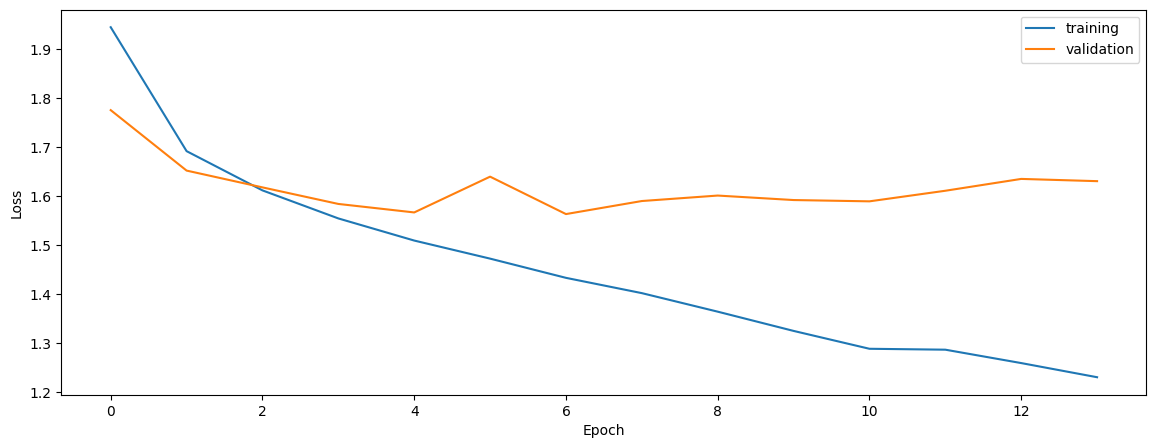

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.4602946805894626
0.394188360353531
0.32124665112556977


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.4614358506350293
0.4582616179001721
0.3489812835391126


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.46244283093460115
0.45670590824073054
0.3567367822626492


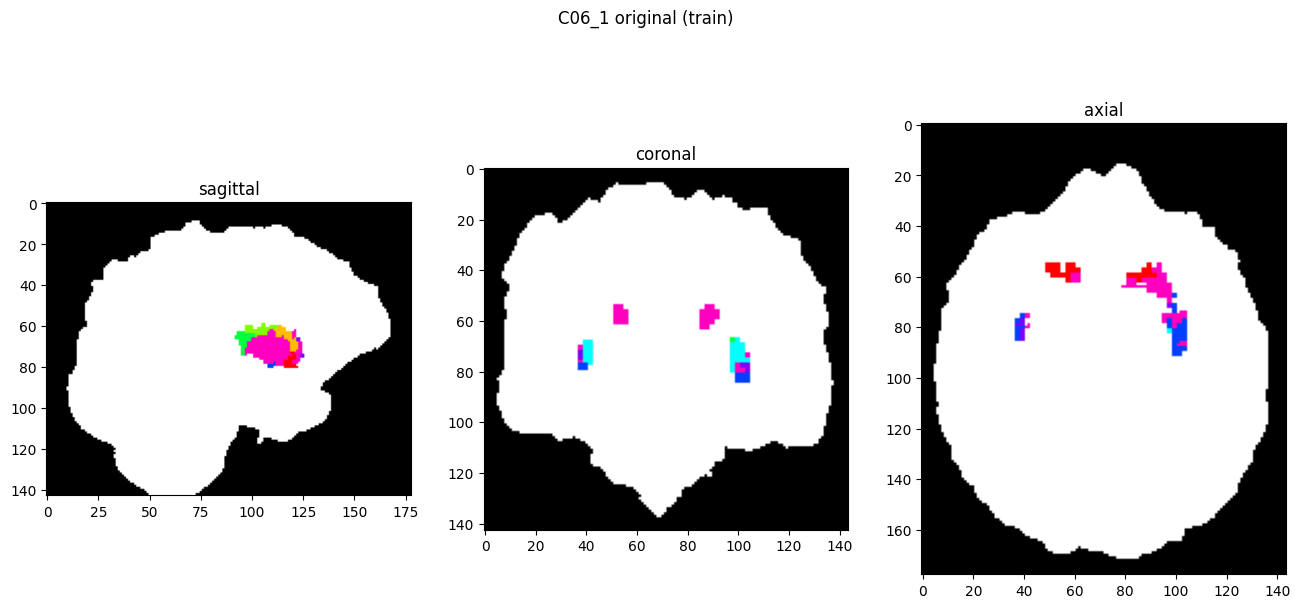

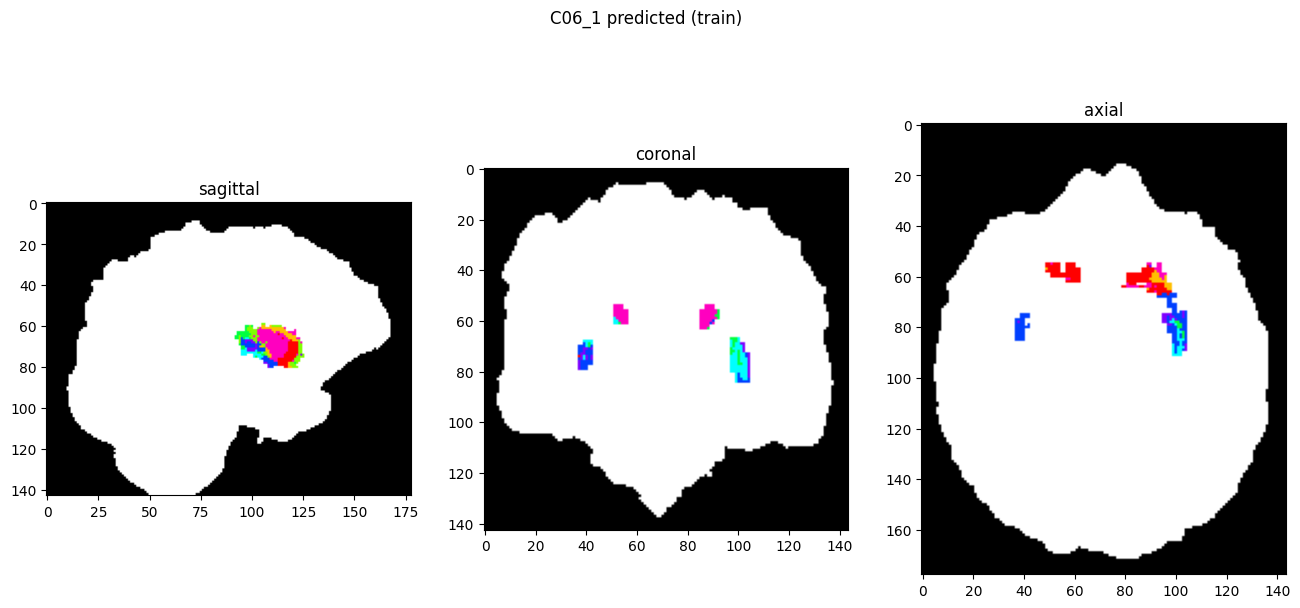

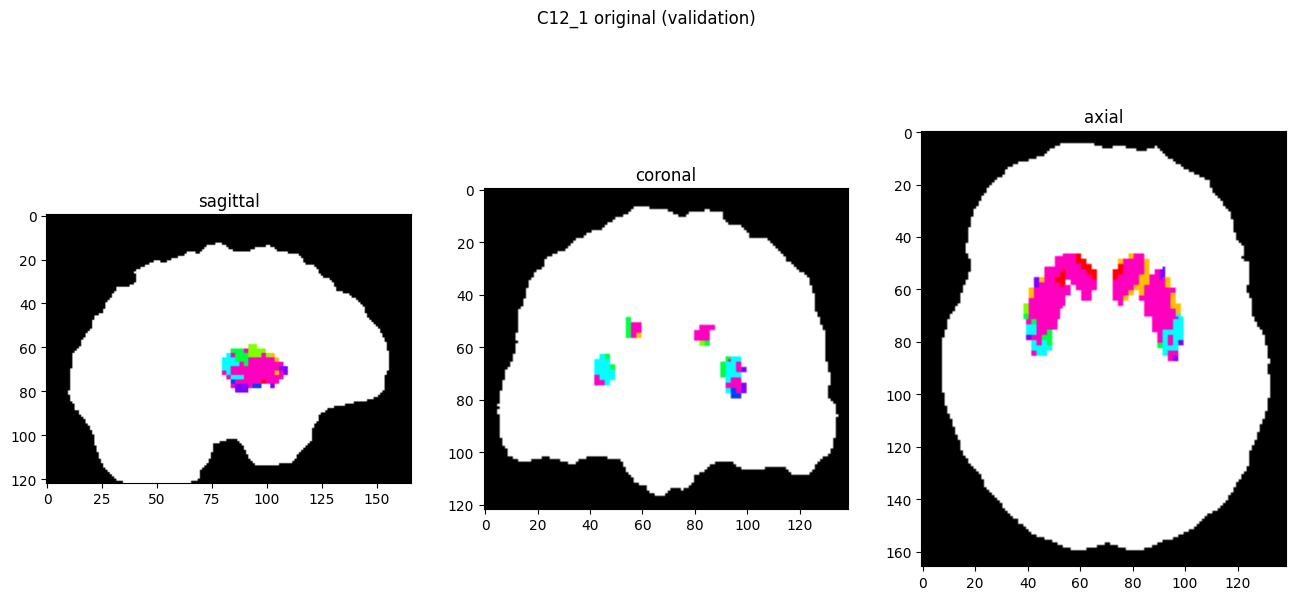

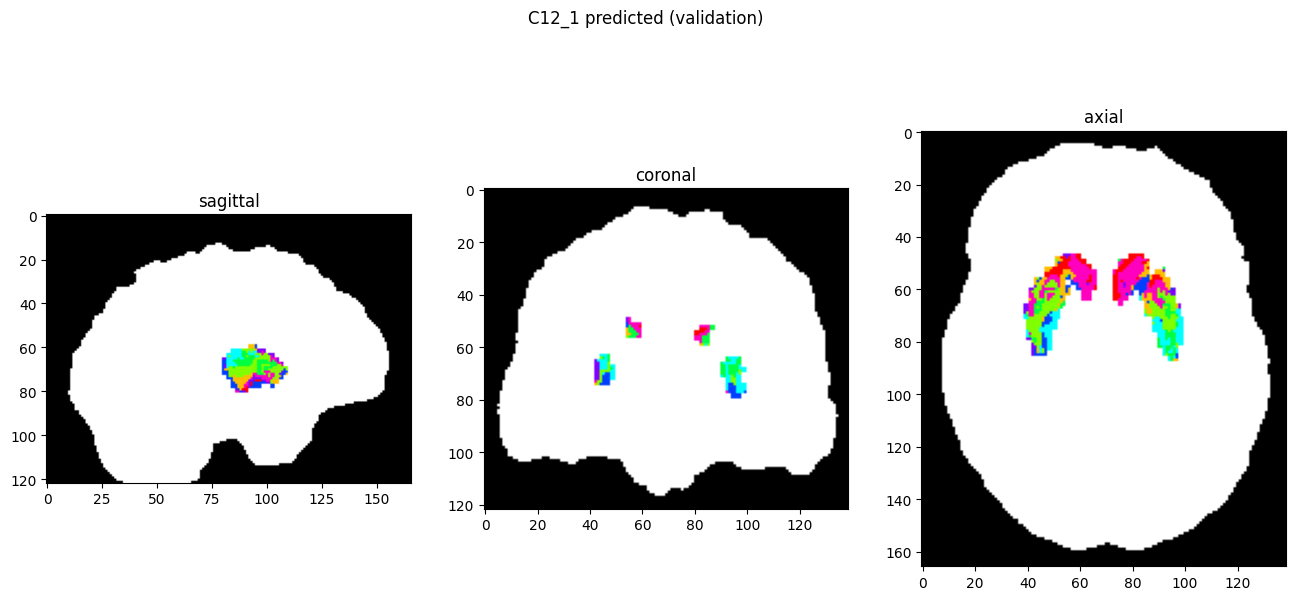

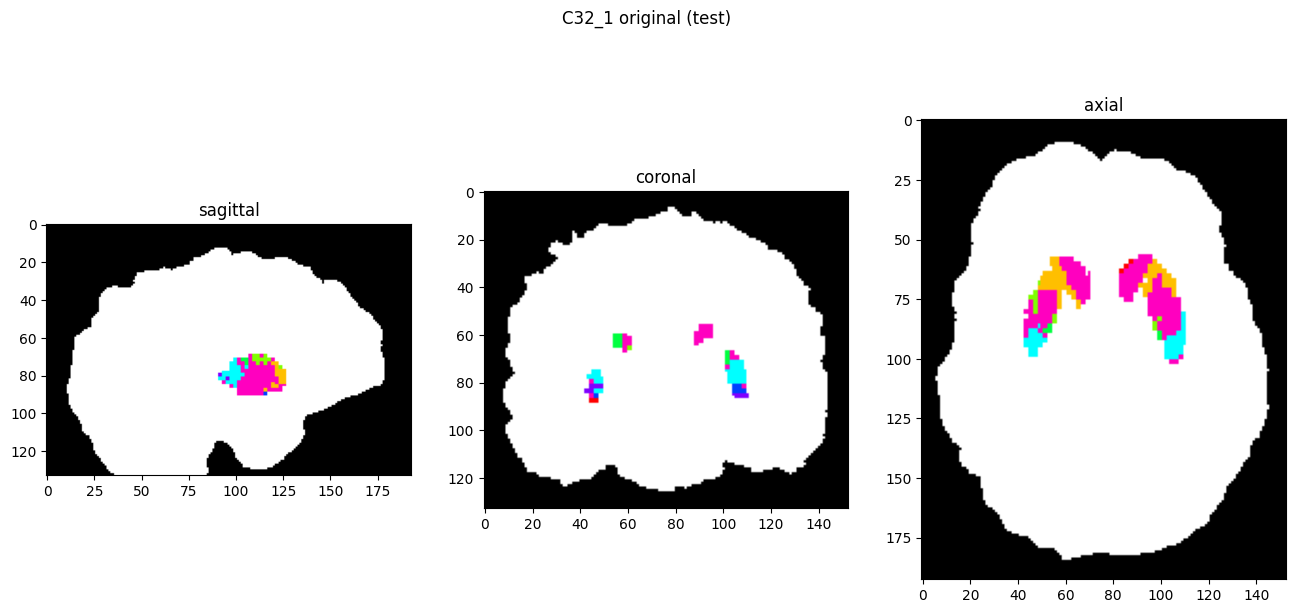

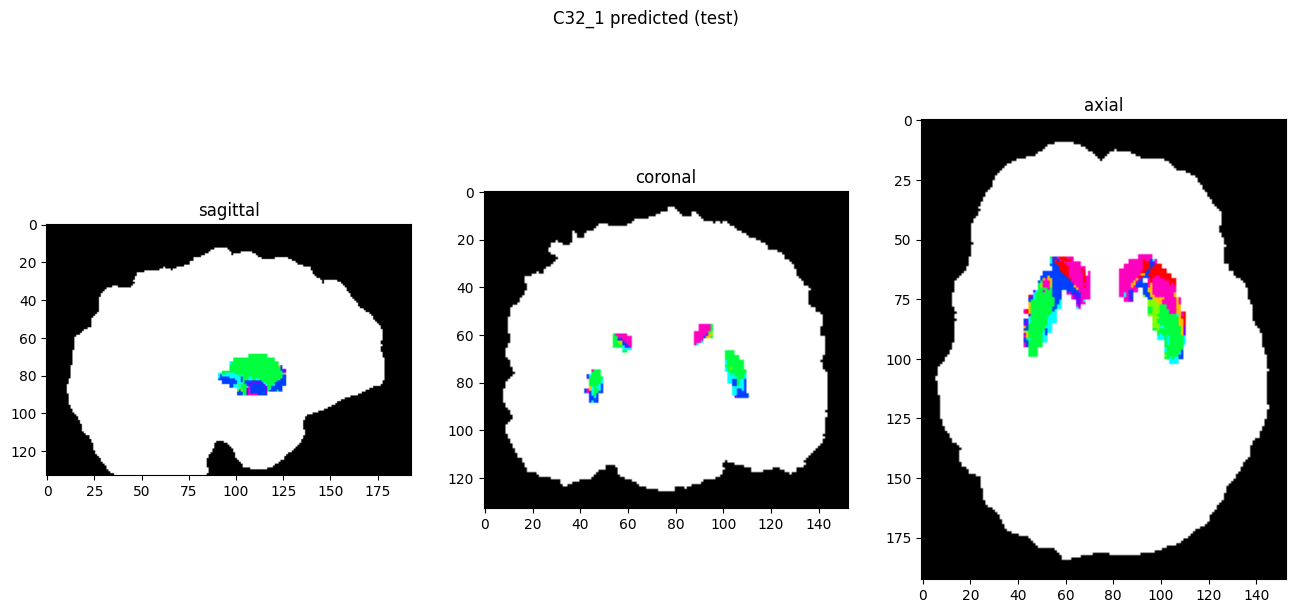

In [10]:
showResults(model, gen, threshold=0)